In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from scipy.stats import mannwhitneyu
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from lgde import Thresholding, LGDE, KNearestNeighbors, IKEA, LGDEWithCDlib, TextRank, evaluate_prediction, error_analysis

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [2]:
plt.rcParams.update({'font.size': 18})

In [3]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95, digits=3):
    """Computes mean confidence interval for point."""
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return round(m,digits), round(m-h,digits), round(m+h, digits)

# Application to a benchmark 20 Newsgroups dataset

## 1) Data input and pre-processing

In [4]:
# load fine-tuned embeddings for different dimensions
embedding_50d = pd.read_pickle("data/embeddings/glove_newsgroups_15_1.0_50d_5.0mu_df.pkl")
embedding_100d = pd.read_pickle("data/embeddings/glove_newsgroups_15_1.0_100d_5.0mu_df.pkl")
embedding_300d = pd.read_pickle("data/embeddings/glove_newsgroups_15_1.0_300d_5.0mu_df.pkl")

# load hyper-parameter tuning results
results_50d = pd.read_pickle("data/gs/gs_baselines_glove_newsgroups_15_1.0_50d_5.0mu_df.pkl")
results_100d = pd.read_pickle("data/gs/gs_baselines_glove_newsgroups_15_1.0_100d_5.0mu_df.pkl")
results_300d = pd.read_pickle("data/gs/gs_baselines_glove_newsgroups_15_1.0_300d_5.0mu_df.pkl")
results_tr = pd.read_pickle("data/gs/gs_textrank_newsgroups.pkl")
results_localmod_50d = pd.read_pickle("data/gs/gs_local_mod_50iter_glove_newsgroups_15_1.0_50d_5.0mu_df.pkl")
results_localmod_100d = pd.read_pickle("data/gs/gs_local_mod_50iter_glove_newsgroups_15_1.0_100d_5.0mu_df.pkl")
results_localmod_300d = pd.read_pickle("data/gs/gs_local_mod_50iter_glove_newsgroups_15_1.0_300d_5.0mu_df.pkl")

In [5]:
# retrieve word vectors at different dimensions
word_vecs_50d = np.zeros((embedding_50d["word_vector"].shape[0], embedding_50d["word_vector"][0].shape[0]))
for i in range(word_vecs_50d.shape[0]):
    word_vecs_50d[i, :] = embedding_50d["word_vector"][i]

word_vecs_100d = np.zeros((embedding_100d["word_vector"].shape[0], embedding_100d["word_vector"][0].shape[0]))
for i in range(word_vecs_100d.shape[0]):
    word_vecs_100d[i, :] = embedding_100d["word_vector"][i]

word_vecs_300d = np.zeros((embedding_300d["word_vector"].shape[0], embedding_300d["word_vector"][0].shape[0]))
for i in range(word_vecs_300d.shape[0]):
    word_vecs_300d[i, :] = embedding_300d["word_vector"][i]

In [6]:
# get word list
word_list = list(embedding_50d["word_string"])

# get document frequency
doc_freq = list(embedding_50d["doc_frequency"])

In [7]:
print("Number of words:", len(word_list))

Number of words: 10751


In [8]:
# fetch train and test data
newsgroups_train = fetch_20newsgroups(
    subset="train", remove=("headers", "footers", "quotes")
)
newsgroups_test = fetch_20newsgroups(
    subset="test", remove=("headers", "footers", "quotes")
)

# create binary split with 1: comp, misc and sci and 0: other groups
target_labels = np.asarray([1, 2, 3, 4, 5, 6, 11, 12, 13, 14])

# define training set
X_train = pd.Series(newsgroups_train["data"])
y_train = np.asarray(np.in1d(newsgroups_train["target"],target_labels),dtype=int)

# define test set
X_test = pd.Series(newsgroups_test["data"])
y_test = np.asarray(np.in1d(newsgroups_test["target"],target_labels),dtype=int)


In [9]:
print("Size of data:", round((len(y_train) + len(y_test)),3))
print("Relative size of test data:", round(len(y_test) / (len(y_train) + len(y_test)),3))

Size of data: 18846
Relative size of test data: 0.4


In [10]:
# compute document-term matrix for train
vectorizer = CountVectorizer(vocabulary=word_list)
word_counts_train = vectorizer.fit_transform(X_train)
dt_train = pd.DataFrame(word_counts_train.toarray(), columns=word_list)

# and for test
word_counts_test = vectorizer.fit_transform(X_test)
dt_test = pd.DataFrame(word_counts_test.toarray(), columns=word_list)

### 1.1) Compute likelihood ratios for words

In [11]:
# get all data
newsgroups = fetch_20newsgroups(
    subset="train", remove=("headers", "footers", "quotes")
)
X = pd.Series(newsgroups["data"])
y = np.asarray(np.in1d(newsgroups["target"],target_labels),dtype=int)

# get all positive documents
X_pos = np.asarray(X)[y>0]

# get all negative documents
X_neg = np.asarray(X)[y==0]

# compute binary document-term matrix for positive documents
binary_vectorizer = CountVectorizer(vocabulary=word_list, binary=True)
word_counts_pos = binary_vectorizer.fit_transform(X_pos)
dt_pos = pd.DataFrame(word_counts_pos.toarray(), columns=word_list)

# and for negative documents
word_counts_neg = binary_vectorizer.fit_transform(X_neg)
dt_neg = pd.DataFrame(word_counts_neg.toarray(), columns=word_list)

# compute probability
prob_pos = dt_pos.sum() / len(X_pos)
prob_neg = dt_neg.sum() / len(X_neg)

# define positive likelihood ratio
likelihood_ratio_positive = prob_pos / prob_neg

del dt_pos, dt_neg, word_counts_pos, X_pos, X_neg

## 2) Properties of seed dictionary

In [12]:
# seed dictionary is defined as names of positive groups
seed_dict = [
    "computer",
    "sys",
    "graphics",
    "os",
    "microsoft",
    "windows",
    "pc",
    "ibm",
    "hardware",
    "mac",
    "sale",
    "science",
    "cryptography",
    "electronics",
    "medicine",
    "space",
]


In [13]:
# evaluate effective seed dictionary on train
print("Train scores for seed dictionary:\n")
_,_,_ = evaluate_prediction(seed_dict, y_train, dt_train)

# evaluate effective seed dictionary on test
print("\nTest scores for seed dictionary:\n")
_,_,_ = evaluate_prediction(seed_dict, y_test, dt_test)

Train scores for seed dictionary:

              precision    recall  f1-score   support

       False      0.581     0.947     0.720      5420
        True      0.884     0.372     0.524      5894

    accuracy                          0.648     11314
   macro avg      0.733     0.660     0.622     11314
weighted avg      0.739     0.648     0.618     11314


Test scores for seed dictionary:

              precision    recall  f1-score   support

       False      0.581     0.944     0.719      3608
        True      0.878     0.373     0.524      3924

    accuracy                          0.647      7532
   macro avg      0.729     0.659     0.621      7532
weighted avg      0.736     0.647     0.617      7532



In [14]:
# compute likelihood ratios for seed keywords
likelihood_ratio_positive[seed_dict]

computer          8.845476
sys              63.450967
graphics        122.763828
os               55.174754
microsoft        21.610112
windows          21.112007
pc               33.309203
ibm               7.147639
hardware         26.463447
mac              16.224005
sale              5.562333
science           1.609264
cryptography     28.506956
electronics       8.933055
medicine          2.260632
space             6.400271
dtype: float64

## 3) Baseline TextRank

In [15]:
# unpack TextRank results
fscore_tr = results_tr["fscore"]
size_tr = results_tr["size"]
context_windows = results_tr["context_windows"]
n_top_ranks = results_tr["n_top_ranks"]
discovered_dicts_tr = results_tr["discovered_dicts"]

In [16]:
# apply size constraints to TextRank
min_size = 100
max_size = 150

fscore_sc_tr = fscore_tr.copy()
for ind_pair in np.argwhere(size_tr < min_size):
    fscore_sc_tr[ind_pair[0],ind_pair[1]] = np.nan
for ind_pair in np.argwhere(size_tr > max_size):
    fscore_sc_tr[ind_pair[0],ind_pair[1]] = np.nan

In [17]:
# compute best TextRank hyperparamers
ind_tr = tuple(np.argwhere(fscore_sc_tr == np.nanmax(fscore_sc_tr))[0])
best_cw = context_windows[ind_tr[0]]
best_n = n_top_ranks[ind_tr[1]]
tr_best_discovered_dict = discovered_dicts_tr[ind_tr[0]][ind_tr[1]]

print("Best context window:", best_cw)
print("Best n:", best_n)

Best context window: 2
Best n: 106


In [18]:
print("\nTrain scores for TextRank expanded dictionary:\n")
_,_,_ =  evaluate_prediction(seed_dict+tr_best_discovered_dict, y_train, dt_train)

print("\nTest scores for TextRank expanded dictionary:\n")
_,_,_ = evaluate_prediction(seed_dict+tr_best_discovered_dict, y_test, dt_test)


Train scores for TextRank expanded dictionary:

              precision    recall  f1-score   support

       False      0.607     0.120     0.201      5420
        True      0.534     0.928     0.678      5894

    accuracy                          0.541     11314
   macro avg      0.571     0.524     0.440     11314
weighted avg      0.569     0.541     0.450     11314


Test scores for TextRank expanded dictionary:

              precision    recall  f1-score   support

       False      0.572     0.123     0.202      3608
        True      0.532     0.915     0.673      3924

    accuracy                          0.536      7532
   macro avg      0.552     0.519     0.437      7532
weighted avg      0.551     0.536     0.447      7532



## 4) Comparison of train performance across dictionary sizes

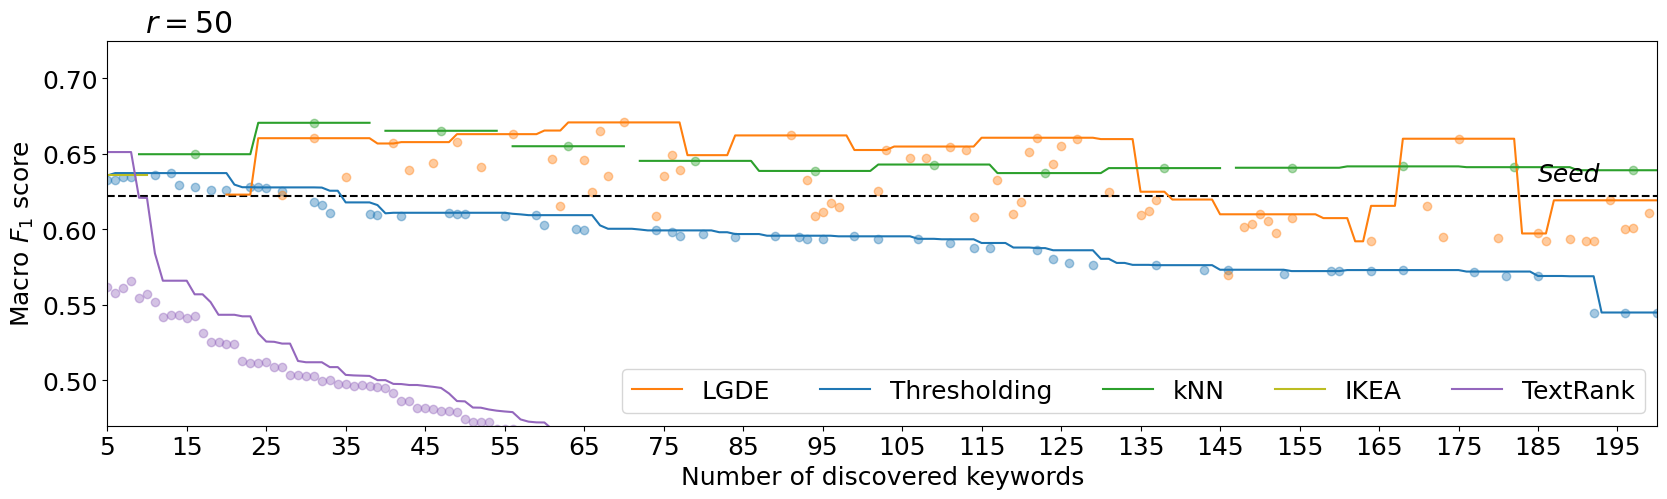

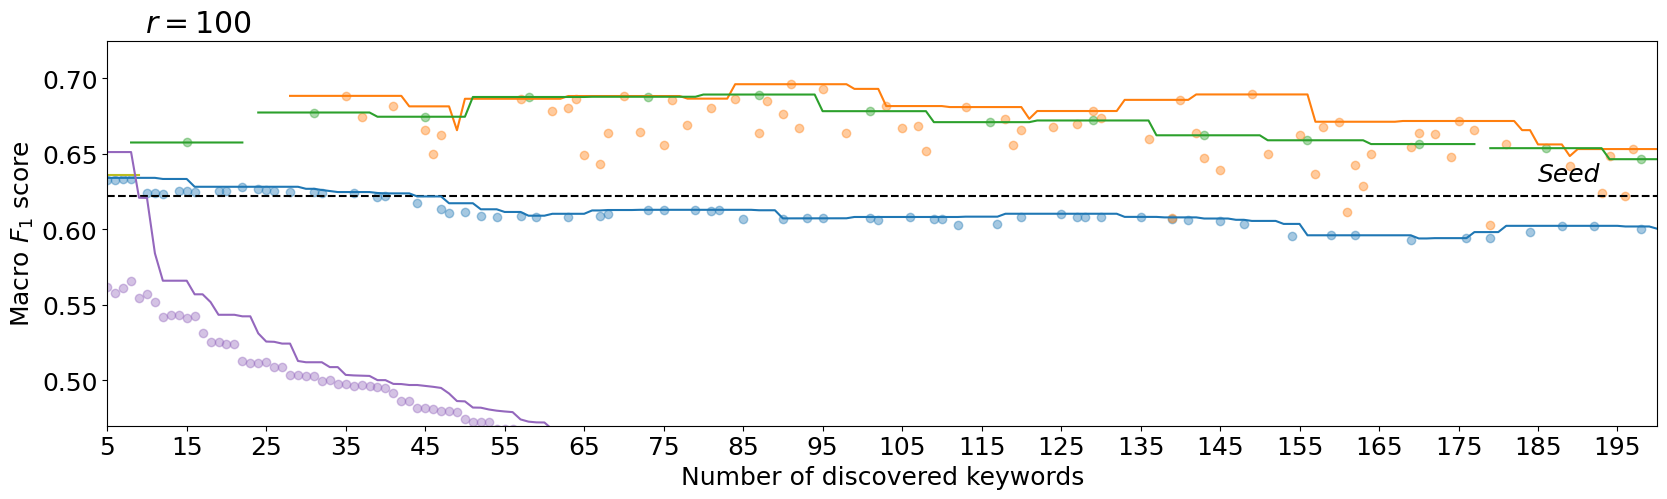

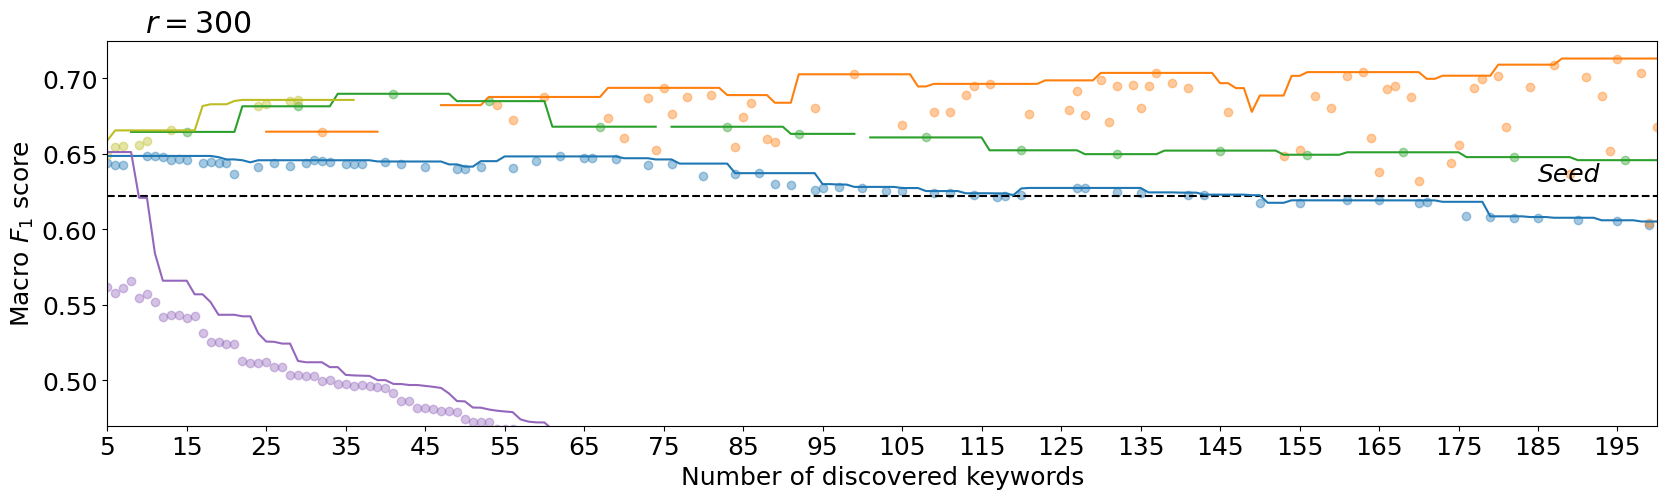

In [19]:
dimension_string = ["50","100","300"]

# iterate through all dimensions
for dim_ind, dim in enumerate(dimension_string):

        results = pd.read_pickle(f"data/gs/gs_baselines_glove_newsgroups_15_1.0_{dim}d_5.0mu_df.pkl")

        # unpack results for thresholding
        eps = results["th"]["eps"]
        fscore_th = results["th"]["fscore"]
        precision_th = results["th"]["precision"]
        recall_th = results["th"]["recall"]
        size_th = results["th"]["size"]

        # unpack results for kNN
        ks_knn = results["knn"]["ks"]
        fscore_knn = results["knn"]["fscore"]
        precision_knn = results["knn"]["precision"]
        recall_knn = results["knn"]["recall"]
        size_knn = results["knn"]["size"]

        # unpack results for IKEA
        eps_ikea = results["ikea"]["eps"]
        fscore_ikea = results["ikea"]["fscore"]
        precision_ikea = results["ikea"]["precision"]
        recall_ikea = results["ikea"]["recall"]
        size_ikea = results["ikea"]["size"]

        # unpack results for LGDE
        times = results["lgde"]["times"]
        ks = results["lgde"]["ks"]
        commmunities = results["lgde"]["communities"]
        fscore_lgde = results["lgde"]["fscore"]
        precision_lgde = results["lgde"]["precision"]
        recall_lgde = results["lgde"]["recall"]
        size_lgde = results["lgde"]["size"]

        ###################
        # comparison plot #
        ###################

        # keep only best F1 score per size for LGDE
        df_lgde_results = pd.DataFrame({"s":size_lgde.flatten(),"f1":fscore_lgde.flatten()})
        df_lgde_results = df_lgde_results.groupby(by="s").max()
        s_lgde = np.asarray(list(df_lgde_results.to_dict()["f1"].keys()),dtype=int)
        f_lgde = np.asarray(list(df_lgde_results.to_dict()["f1"].values()))

        # keep only best F1 score per size for thresholding
        df_th_results = pd.DataFrame({"s":size_th.flatten(),"f1":fscore_th.flatten()})
        df_th_results = df_th_results.groupby(by="s").max()
        s_th = np.asarray(list(df_th_results.to_dict()["f1"].keys()),dtype=int)
        f_th = np.asarray(list(df_th_results.to_dict()["f1"].values()))

        # keep only best F1 score per size for kNN
        df_knn_results = pd.DataFrame({"s":size_knn.flatten(),"f1":fscore_knn.flatten()})
        df_knn_results = df_knn_results.groupby(by="s").max()
        s_knn = np.asarray(list(df_knn_results.to_dict()["f1"].keys()),dtype=int)
        f_knn = np.asarray(list(df_knn_results.to_dict()["f1"].values()))

        # keep only best F1 score per size for ikea
        df_ikea_results = pd.DataFrame({"s":size_ikea.flatten(),"f1":fscore_ikea.flatten()})
        df_ikea_results = df_ikea_results.groupby(by="s").max()
        s_ikea = np.asarray(list(df_ikea_results.to_dict()["f1"].keys()),dtype=int)
        f_ikea = np.asarray(list(df_ikea_results.to_dict()["f1"].values()))

        # keep only best F1 score per size for TextRank (for best context window)
        df_tr_results = pd.DataFrame({"s":size_tr[ind_tr[0]].flatten(),"f1":fscore_tr[ind_tr[0]].flatten()})
        df_tr_results = df_tr_results.groupby(by="s").max()
        s_tr = np.asarray(list(df_tr_results.to_dict()["f1"].keys()),dtype=int)
        f_tr = np.asarray(list(df_tr_results.to_dict()["f1"].values()))

        # apply max pooling to LGDE
        block_size = 15
        f_lgde_max = []
        sizes = np.arange(1,int(s_lgde.max())+1)
        for i in range(len(sizes)):
            try:
                f_lgde_max.append(f_lgde[(sizes[i]-int(block_size/2)<=s_lgde) * (s_lgde<=sizes[i]+int(block_size/2))].max())
            except:
                f_lgde_max.append(np.nan)
        f_lgde_max = np.asarray(f_lgde_max)

        # apply max pooling to thresholding
        f_th_max = []
        for i in range(len(sizes)):
            f_th_block = f_th[(sizes[i]-int(block_size/2)<=s_th) * (s_th<=sizes[i]+int(block_size/2))]
            if len(f_th_block) > 0:
                f_th_max.append(f_th_block.max())
            else:
                f_th_max.append(np.nan)
        f_th_max = np.asarray(f_th_max)

        # apply max pooling to knn
        f_knn_max = []
        for i in range(len(sizes)):
            f_knn_block = f_knn[(sizes[i]-int(block_size/2)<=s_knn) * (s_knn<=sizes[i]+int(block_size/2))]
            if len(f_knn_block) > 0:
                f_knn_max.append(f_knn_block.max())
            else:
                f_knn_max.append(np.nan)
        f_knn_max = np.asarray(f_knn_max)

        # apply max pooling to ikea
        f_ikea_max = []
        for i in range(len(sizes)):
            f_ikea_block = f_ikea[(sizes[i]-int(block_size/2)<=s_ikea) * (s_ikea<=sizes[i]+int(block_size/2))]
            if len(f_ikea_block) > 0:
                f_ikea_max.append(f_ikea_block.max())
            else:
                f_ikea_max.append(np.nan)
        f_ikea_max = np.asarray(f_ikea_max)

        # apply max pooling to TextRank
        f_tr_max = []
        for i in range(len(sizes)):
            f_tr_block = f_tr[(sizes[i]-int(block_size/2)<=s_tr) * (s_tr<=sizes[i]+int(block_size/2))]
            if len(f_tr_block) > 0:
                f_tr_max.append(f_tr_block.max())
            else:
                f_tr_max.append(np.nan)
        f_tr_max = np.asarray(f_tr_max)

        # plot
        fig, ax = plt.subplots(1, figsize=(20, 5))
        
        # plot seed train score
        ax.axhline(y=0.622 , c="black",ls="--")
        ax.annotate("Seed", xy = (185, 0.622 + 0.01), c="black", fontstyle='italic')

        # scatter plote train scores of different methods
        ax.scatter(s_th[s_th<=s_lgde.max()],f_th[s_th<=s_lgde.max()],alpha=0.4)
        ax.scatter(s_knn[s_knn<=s_lgde.max()],f_knn[s_knn<=s_lgde.max()],alpha=0.4, c="C2")
        ax.scatter(s_ikea[s_ikea<=s_lgde.max()],f_ikea[s_ikea<=s_lgde.max()],alpha=0.4, c="C8")
        ax.scatter(s_tr[s_tr<=s_lgde.max()],f_tr[s_tr<=s_lgde.max()],alpha=0.4, c="C4")
        ax.scatter(s_lgde,f_lgde, alpha=0.4, c="C1")

        # plot max pooled train scores
        ax.plot(sizes,f_lgde_max, c="C1",label="LGDE")
        ax.plot(sizes, f_th_max, c="C0",label="Thresholding")
        ax.plot(sizes,f_knn_max, c="C2",label="kNN")
        ax.plot(sizes,f_ikea_max, c="C8",label="IKEA")
        ax.plot(sizes,f_tr_max, c="C4",label="TextRank")
        
        # set labels etc.
        if dim_ind == 0:
            ax.legend(loc=4,ncol=5)
        ax.set(ylim=(0.47,0.725),xlim=(5,200),xticks=np.arange(5,201,10))
        plt.title(f"    $r=${dimension_string[dim_ind]}",loc="left")
        ax.set(xlabel="Number of discovered keywords", ylabel="Macro $F_1$ score")

        # store plots
        plt.savefig("figures/" +dimension_string[dim_ind]+'comparison-baselines.pdf', bbox_inches='tight')
        plt.show()

The IKEA dictionaries are either too small or too large and are not considered for further comparison.

## 5) Detailed comparison for dimension $r=50$

In [20]:
# size constraints
min_size = 100
max_size = 150

In [21]:
##############
# GS results #
##############

# unpack results for thresholding
eps = results_50d["th"]["eps"]
fscore_th = results_50d["th"]["fscore"]
precision_th = results_50d["th"]["precision"]
recall_th = results_50d["th"]["recall"]
size_th = results_50d["th"]["size"]

# unpack results for kNN
ks_knn = results_50d["knn"]["ks"]
fscore_knn = results_50d["knn"]["fscore"]
precision_knn = results_50d["knn"]["precision"]
recall_knn = results_50d["knn"]["recall"]
size_knn = results_50d["knn"]["size"]

# unpack results_50d for IKEA
eps_ikea = results_50d["ikea"]["eps"]
fscore_ikea = results_50d["ikea"]["fscore"]
precision_ikea = results_50d["ikea"]["precision"]
recall_ikea = results_50d["ikea"]["recall"]
size_ikea = results_50d["ikea"]["size"]

# unpack results_50d for CkNN +  LSWL
ks_lswl = results_50d["lswl"]["ks"]
fscore_lswl = results_50d["lswl"]["fscore"]
precision_lswl = results_50d["lswl"]["precision"]
recall_lswl = results_50d["lswl"]["recall"]
size_lswl = results_50d["lswl"]["size"]

# unpack results for LGDE
times = results_50d["lgde"]["times"]
ks = results_50d["lgde"]["ks"]
commmunities = results_50d["lgde"]["communities"]
fscore_lgde = results_50d["lgde"]["fscore"]
precision_lgde = results_50d["lgde"]["precision"]
recall_lgde = results_50d["lgde"]["recall"]
size_lgde = results_50d["lgde"]["size"]

# apply size constraints to thresholding
fscore_sc_th = fscore_th.copy()
fscore_sc_th[min_size > size_th] = np.nan
fscore_sc_th[size_th > max_size] = np.nan

# apply size constraints to kNN
fscore_sc_knn = fscore_knn.copy()
fscore_sc_knn[min_size > size_knn] = np.nan
fscore_sc_knn[size_knn > max_size] = np.nan

# apply size constraints to IKEA
fscore_sc_ikea = fscore_ikea.copy()
fscore_sc_ikea[min_size > size_ikea] = np.nan
fscore_sc_ikea[size_ikea > max_size] = np.nan

# apply size constraints to CkNN +  LSWL
fscore_sc_lswl = fscore_lswl.copy()
fscore_sc_lswl[min_size > size_lswl] = np.nan
fscore_sc_lswl[size_lswl > max_size] = np.nan

# apply size constraints to lgde
fscore_sc_lgde = fscore_lgde.copy()
for ind_pair in np.argwhere(size_lgde < min_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.nan
for ind_pair in np.argwhere(size_lgde > max_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.nan

# compute best thresholding hyperparameter
ind_th = np.nanargmax(fscore_sc_th)
best_epsilon_50d = eps[ind_th]

# compute best knn hyperparameter
ind_knn = np.nanargmax(fscore_sc_knn)
best_k_50d_knn = ks_knn[ind_knn]

# compute best lswl hyperparameter
ind_lswl = np.nanargmax(fscore_sc_lswl)
best_k_50d_lswl = ks_lswl[ind_lswl]

# compute best LGDE hyperparamers
ind_lgde = tuple(np.argwhere(fscore_sc_lgde == np.nanmax(fscore_sc_lgde))[0])
best_k_50d = ks[ind_lgde[0]]
best_t_50d = times[ind_lgde[1]]

### 5.1) Thresholding


### Thresholding ###

Best epsilon at $r=50$: 0.891


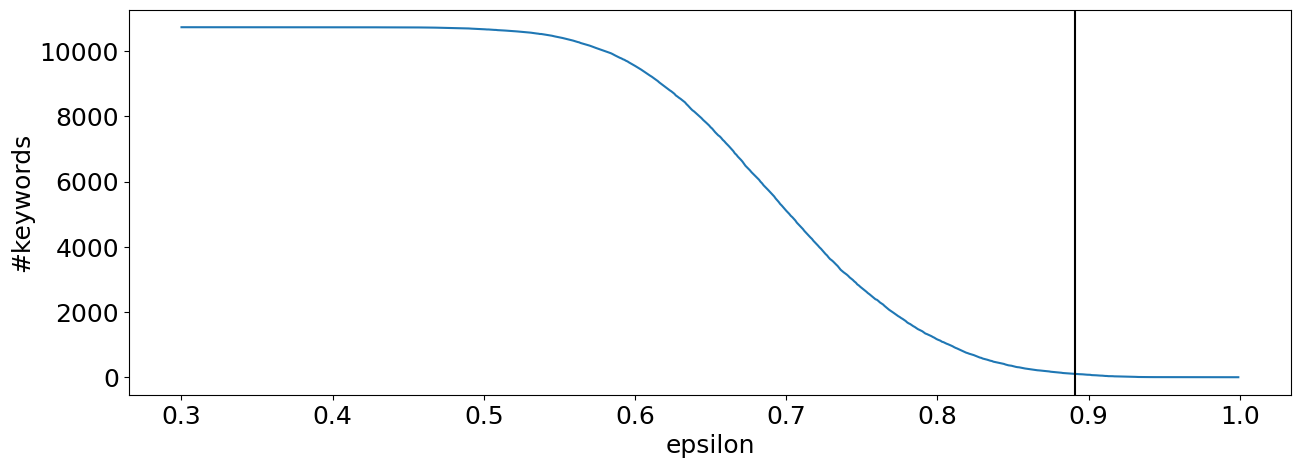

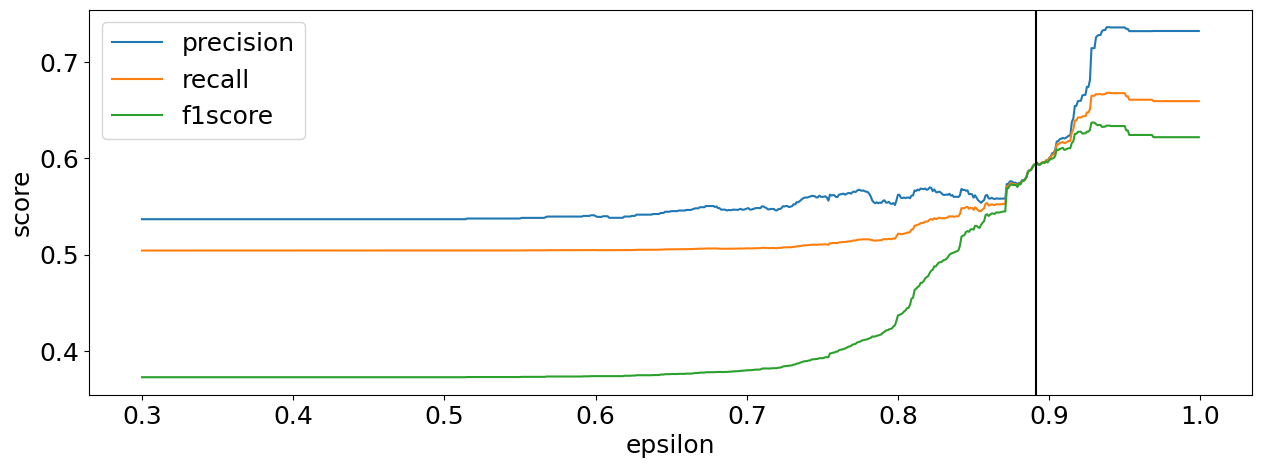

Number of discovered keywords at $r=50$: 102 

Epsilon balls:

computer --> ['relief', 'worse', 'cold', 'case', 'original', 'associated', 'john', 'various', 'ad', 'clever', 'questioned', 'calls', 'modify', 'computer', 'speed', '300', 'tried', 'size', 'sell', 'comments', 'techniques', 'claims', 'memoirs', 'conventional', 'reporter', 'farm', 'services', 'reveal', 'linux', 'obtain', 'peculiar', 'transportation', 'raw', 'storm', 'truecolor', 'intact', 'specialist', 'remained', 'retail', 'nominal', 'outlets', 'lest', 'housed', 'halfway']
sys --> ['sys']
graphics --> ['orchid', 'graphics', 'post', 'matt', 'devices', 'golden', 'ms', 'hear', 'week', 'knocking', 'guidance', 'text', 'hat', 'plenty', 'situations', 'transmissions', 'correspondence', 'firing', 'composed', 'ala', 'camp', 'echo', 'spite', '1984', 'threshold', 'wright', 'ds', 'sucked', 'mad', 'deed', 'focusing', 'bumper', 'wholesale', '134', 'joel', 'perfection', 'accommodate', 'scorer', 'radiosity']
os --> ['os']
microsoft --> ['micr

In [22]:
################
# Thresholding #
################

print("\n### Thresholding ###\n")

print("Best epsilon at $r=50$:",round(best_epsilon_50d,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,size_th)
ax.axvline(x=best_epsilon_50d, c = 'black')
ax.set(xlabel="epsilon", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,precision_th,label="precision")
ax.plot(eps,recall_th,label="recall")
ax.plot(eps,fscore_th,label="f1score")
ax.axvline(x=best_epsilon_50d, c = 'black')
ax.set(xlabel="epsilon",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal epsilon
thres_50d = Thresholding(seed_dict,word_list,word_vecs_50d)
thres_50d.expand(best_epsilon_50d)

print("Number of discovered keywords at $r=50$:", thres_50d.n_discovered,"\n")

print("Epsilon balls:\n")
for keyword in thres_50d.seed_dict[:15]:
    print(keyword,"-->",thres_50d.epsilon_balls_[keyword])

print("\nDiscovered words:", sorted(thres_50d.discovered_dict_))

print("\nTrain scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(thres_50d.expanded_dict_, y_train, dt_train)

print("\nTest scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_50d.expanded_dict_, y_test, dt_test)

# free up memory
del thres_50d

### 5.2) kNN


### kNN ###

Best k at $r=50$: 7


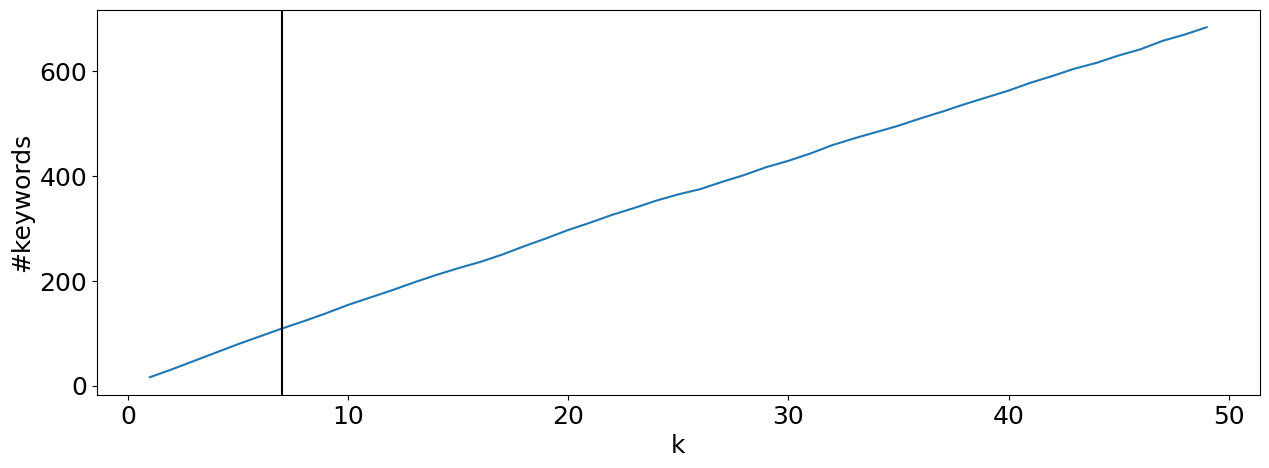

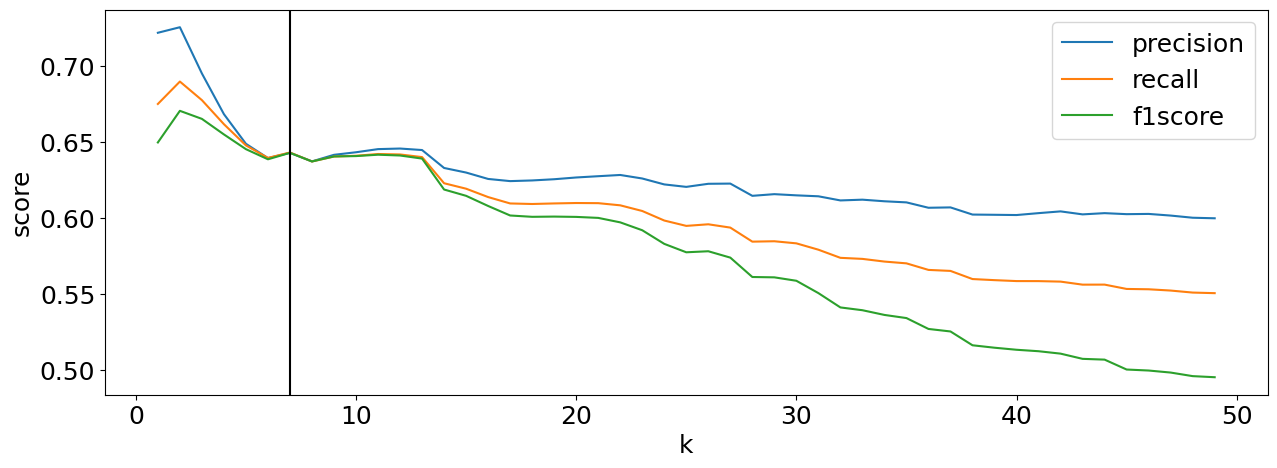

Number of discovered keywords at $r=50$: 109 

k-nearest neighbors:

computer --> ['computer', 'calls', 'outlets', 'conventional', 'transportation', 'speed', '300', 'various']
sys --> ['sys', 'ql', 'crt', 'ver', 'modem', 'comp', 'md5', 'bbs']
graphics --> ['graphics', 'devices', 'orchid', 'bumper', 'composed', 'post', 'situations', 'correspondence']
os --> ['os', 'que', 'ram', 'dos', 'deleted', 'yd', 'sp', 'imaging']
microsoft --> ['microsoft', 'developers', 'hardware', 'client', 'intel', 'communications', 'chapter', 'software']
windows --> ['windows', 'portable', 'window', 'platforms', 'log', 'boxes', 'stacks', 'door']
pc --> ['pc', 'multimedia', 'disk', 'dram', 'vp', 'app', 'instant', 'processors']
ibm --> ['ibm', 'ge', 'makers', 'mobile', 'fears', 'purchases', 'sponsor', 'hardware']
hardware --> ['hardware', 'xerox', 'storing', 'threshold', 'offers', 'cost', 'modem', 'wi']
mac --> ['mac', 'launchers', 'filter', 'carter', 'accounts', 'pt', 'cd', 'fitted']
sale --> ['sale', 'setup', '

In [23]:
#######
# kNN #
#######

print("\n### kNN ###\n")

print("Best k at $r=50$:",round(best_k_50d_knn,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_knn,size_knn)
ax.axvline(x=best_k_50d_knn, c = 'black')
ax.set(xlabel="k", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_knn,precision_knn,label="precision")
ax.plot(ks_knn,recall_knn,label="recall")
ax.plot(ks_knn,fscore_knn,label="f1score")
ax.axvline(x=best_k_50d_knn, c = 'black')
ax.set(xlabel="k",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal k
knn_50d = KNearestNeighbors(seed_dict,word_list,word_vecs_50d)
knn_50d.expand(best_k_50d_knn)

print("Number of discovered keywords at $r=50$:", knn_50d.n_discovered,"\n")

print("k-nearest neighbors:\n")
for keyword in knn_50d.seed_dict[:15]:
    print(keyword,"-->",knn_50d.neighbors_[keyword])

print("\nDiscovered words:", sorted(knn_50d.discovered_dict_))

print("\nTrain scores for kNN expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(knn_50d.expanded_dict_, y_train, dt_train)

print("\nTest scores for kNN expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(knn_50d.expanded_dict_, y_test, dt_test)

# free up memory
del knn_50d

### 5.3) Other local community detection methods


### LSWL / SIWO ###

Best k at $r=50$: 6


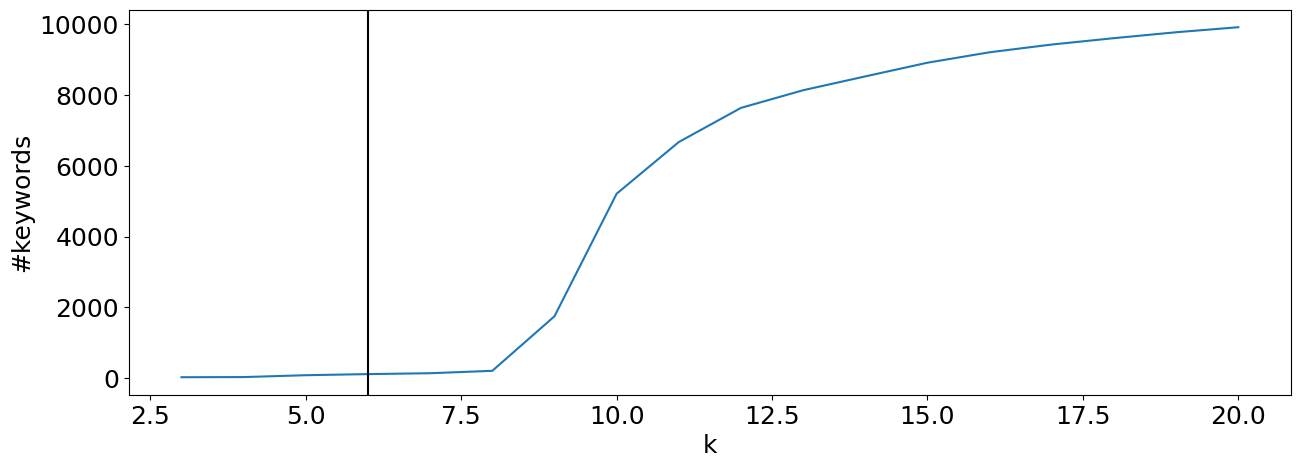

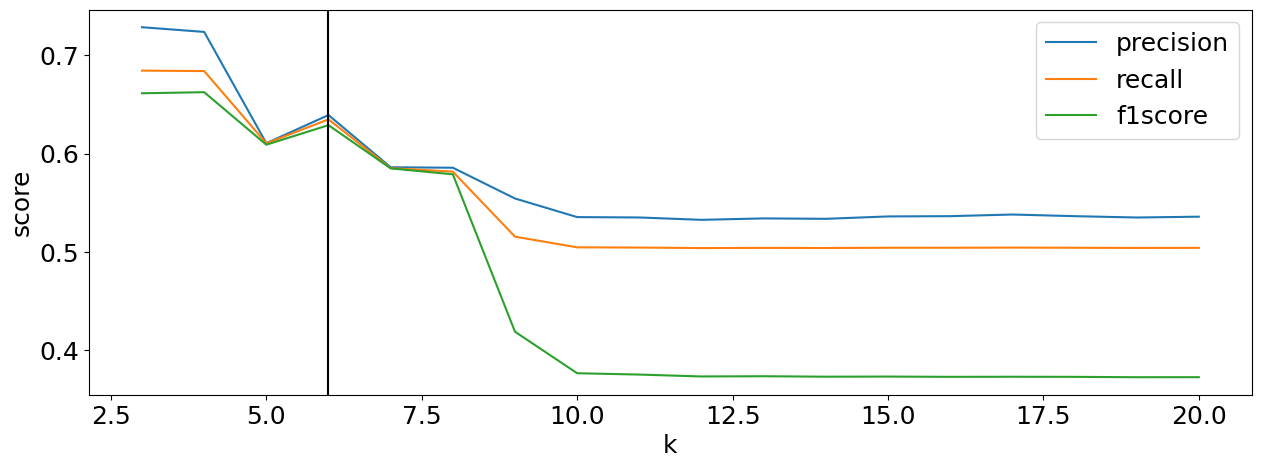

100%|██████████| 16/16 [00:00<00:00, 155.81it/s]

Number of discovered keywords at $r=50$: 113 

Semantic communities:

computer --> ['computer', 'speed', 'conventional', 'transportation']
sys --> ['sys', 'intergraph', 'ql']
graphics --> ['graphics', 'post', 'devices', 'ms', 'holds', 'convex', 'knocking', 'ala', 'wright', 'prevail', 'configurations', 'valley', 'theoretically', '134', 'lj', 'accommodate']
os --> ['os', 'dos', 'yd']
microsoft --> ['chip', 'intel', 'microsoft', 'compuserve', 'micron', 'compaq', 'hp', 'microsystems', 'hewlett', 'packard', 'motorola', 'novell', 'fujitsu', 'dell', 'semiconductor']
windows --> ['hut', 'windows', 'log', 'stacks', 'huts']
pc --> ['app', 'pc']
ibm --> ['ibm', 'mobile', 'interfere', 'ge', '15th']
hardware --> ['hardware', 'lud', 'text', 'firing', 'rs232', 'wi', 'fpu', 'threshold', 'ds', 'mad', 'deed', 'stdio', 'keywords', 'jsh', 'storing', 'flown', 'tia', 'joel', 'md5', 'lisp', 'peripherals', 'scorer']
mac --> ['mac']
sale --> ['setup', 'sale', 'motherboard', 'national', 'helps', 'ba', 'approach

In [24]:
########
# LSWL #
########

print("\n### LSWL / SIWO ###\n")

print("Best k at $r=50$:",round(best_k_50d_lswl,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_lswl,size_lswl)
ax.axvline(x=best_k_50d_lswl, c = 'black')
ax.set(xlabel="k", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_lswl,precision_lswl,label="precision")
ax.plot(ks_lswl,recall_lswl,label="recall")
ax.plot(ks_lswl,fscore_lswl,label="f1score")
ax.axvline(x=best_k_50d_lswl, c = 'black')
ax.set(xlabel="k",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal k
lswl_50d = LGDEWithCDlib(seed_dict,word_list,word_vecs_50d)
lswl_50d.expand(best_k_50d_lswl, method="lswl")

print("Number of discovered keywords at $r=50$:", lswl_50d.n_discovered,"\n")

print("Semantic communities:\n")
for keyword in lswl_50d.seed_dict[:15]:
    print(keyword,"-->",lswl_50d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lswl_50d.discovered_dict_))

print("\nTrain scores for LSWL expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(lswl_50d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LSWL expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(lswl_50d.expanded_dict_, y_test, dt_test)

# free up memory
del lswl_50d

In [25]:
#########
# Mod R #
#########

# unpack dictionary
modr_size = results_localmod_50d["modr"]["size"]
modr_fscore_train = results_localmod_50d["modr"]["fscore_train"]
modr_fscore_test = results_localmod_50d["modr"]["fscore_test"]
modr_ks = results_localmod_50d["modr"]["ks"]

# apply size constraints
modr_fscore_train_sc = []
modr_fscore_test_sc = []

for i in range(len(modr_ks)):
    # comput size constraint indices per k
    sc_ind = (modr_size[i] <= max_size) * (modr_size[i] >= min_size)
    modr_fscore_train_sc.append(modr_fscore_train[i][sc_ind])
    modr_fscore_test_sc.append(modr_fscore_test[i][sc_ind])

# find best k based on mean train F1 scores of admissible dictionaries
modr_fscore_train_sc_mean = np.array([np.array(scores_k).mean() if len(scores_k) > 0 else np.nan for scores_k in modr_fscore_train_sc])
modr_best_k_ind = np.nanargmax(modr_fscore_train_sc_mean) # best k only has 14 admissible dictionaries, we choose second-best below
modr_best_k_ind = np.argsort(-modr_fscore_train_sc_mean)[1]
modr_best_k = modr_ks[modr_best_k_ind]
print("Best k for 'modr':",modr_best_k)
print("Number of admissible dictionaries:", len(modr_fscore_train_sc[modr_best_k_ind]))

# compute 95% CIs for train and test F1 scores
modr_fscore_train_m, modr_fscore_train_l, modr_fscore_train_r = mean_confidence_interval(modr_fscore_train_sc[modr_best_k_ind])
print(f"Average train F1 score for 'modr': {modr_fscore_train_m} ({modr_fscore_train_l}--{modr_fscore_train_r})")
modr_fscore_test_m, modr_fscore_test_l, modr_fscore_test_r = mean_confidence_interval(modr_fscore_test_sc[modr_best_k_ind])
print(f"Average test F1 score for 'modr': {modr_fscore_test_m} ({modr_fscore_test_l}--{modr_fscore_test_r})")

#########
# Mod M #
#########

# unpack dictionary
modm_size = results_localmod_50d["modm"]["size"]
modm_fscore_train = results_localmod_50d["modm"]["fscore_train"]
modm_fscore_test = results_localmod_50d["modm"]["fscore_test"]
modm_ks = results_localmod_50d["modm"]["ks"]

# apply size constraints
modm_fscore_train_sc = []
modm_fscore_test_sc = []

for i in range(len(modm_ks)):
    # comput size constraint indices per k
    sc_ind = (modm_size[i] <= max_size) * (modm_size[i] >= min_size)
    modm_fscore_train_sc.append(modm_fscore_train[i][sc_ind])
    modm_fscore_test_sc.append(modm_fscore_test[i][sc_ind])

# find best k based on mean train F1 scores of admissible dictionaries
modm_fscore_train_sc_mean = np.array([np.array(scores_k).mean() if len(scores_k) > 0 else np.nan for scores_k in modm_fscore_train_sc])
modm_best_k_ind = np.nanargmax(modm_fscore_train_sc_mean)
modm_best_k = modm_ks[modm_best_k_ind]
print("\nBest k for 'modm':",modm_best_k)
print("Number of admissible dictionaries:", len(modm_fscore_train_sc[modm_best_k_ind]))

# compute 95% CIs for train and test F1 scores
modm_fscore_train_m, modm_fscore_train_l, modm_fscore_train_r = mean_confidence_interval(modm_fscore_train_sc[modm_best_k_ind])
print(f"Average train F1 score for 'modm': {modm_fscore_train_m} ({modm_fscore_train_l}--{modm_fscore_train_r})")
modm_fscore_test_m, modm_fscore_test_l, modm_fscore_test_r = mean_confidence_interval(modm_fscore_test_sc[modm_best_k_ind])
print(f"Average test F1 score for 'modm': {modm_fscore_test_m} ({modm_fscore_test_l}--{modm_fscore_test_r})")

Best k for 'modr': 6
Number of admissible dictionaries: 35
Average train F1 score for 'modr': 0.619 (0.617--0.621)
Average test F1 score for 'modr': 0.606 (0.604--0.608)

Best k for 'modm': 7
Number of admissible dictionaries: 39
Average train F1 score for 'modm': 0.644 (0.642--0.646)
Average test F1 score for 'modm': 0.634 (0.632--0.637)


### 5.4) LGDE


### LGDE ###

Best hyperparameters at $r=50$:k=3, t=8


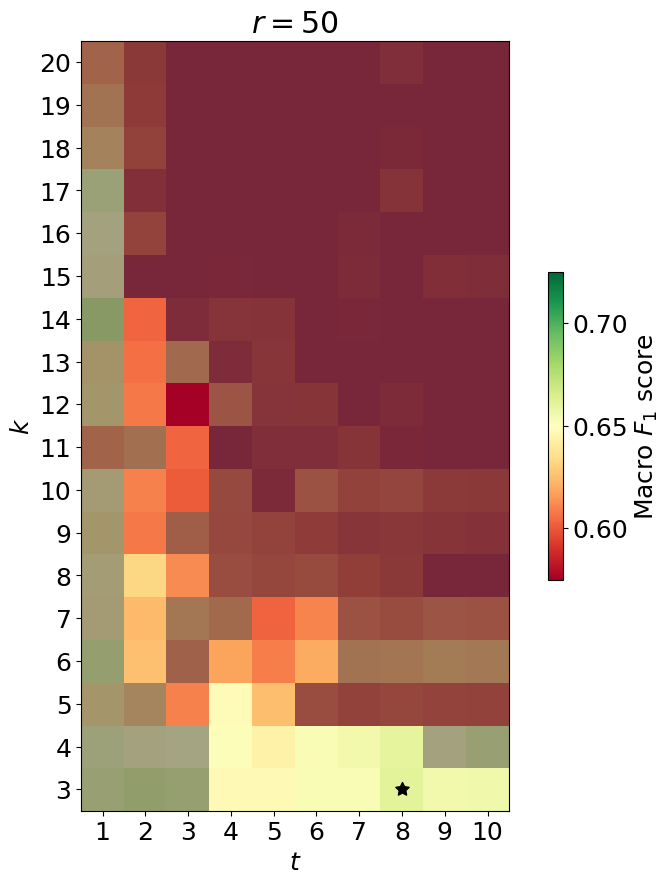

100%|██████████| 16/16 [00:13<00:00,  1.14it/s]


Number of discovered keywords: 122 

Semantic communities:

computer --> ['computer']
sys --> ['sys', 'ql', 'yr', 'rr', '223', 'goalies', 'sd', 'wisc', 'ez', 'adaptor', 'isdn']
graphics --> ['graphics', 'devices', 'orchid', 'deed', 'mad', 'perfection', 'jsh', 'scorer', 'firing', 'threshold', 'lisp', 'stdio', 'wi', 'ds', 'tia', 'electron', 'slots', 'elias']
os --> ['os', 'que', 'ram', 'yd', 'dos', 'mas', 'lo']
microsoft --> ['microsoft', 'client', 'appointment', 'salary']
windows --> ['windows', 'platforms', 'platform', 'log', 'window', 'portable', 'hut', 'shack', 'door', 'gates', 'sitting', 'stayed', 'hands', 'shoulders', 'lay', 'foundations', 'family', 'noble', 'heritage', 'liberty', 'virgin']
pc --> ['pc', 'dram', 'processors', 'computers', 'multimedia', 'op', 'instant', 'collecting', 'dump', 'seize', 'fleeing', 'forcing', 'wiped', 'fewer', 'hopes']
ibm --> ['ibm', 'makers', 'ge', 'ag', 'phigs', 'checked', 'sumex', 'interviewed', 'interfere', 'shopper', 'situations', 'statistic', 'c

In [26]:
########
# LGDE #
########

print("\n### LGDE ###\n")
print(f"Best hyperparameters at $r=50$:k={best_k_50d}, t={best_t_50d}")

# plot F1 score
fig, ax = plt.subplots(1, figsize=(10, 10))
im = ax.imshow(np.ones_like(fscore_lgde),cmap='Greys',origin='lower',alpha=0.7, vmin=0,vmax=1)
im = ax.imshow(fscore_lgde,cmap='RdYlGn',origin='lower',alpha=0.5,vmin=0.575,vmax=0.725)
im = ax.imshow(fscore_sc_lgde,cmap='RdYlGn',origin='lower',vmin=0.575,vmax=0.725)
ax.set(xlabel="$t$", ylabel="$k$", xticks=np.arange(len(times)),yticks=np.arange(len(ks)), xticklabels=times, yticklabels=ks)
ax.scatter(ind_lgde[1],ind_lgde[0],color='black',marker=(5, 1),s=100)
plt.colorbar(im,shrink=0.4,label="Macro $F_1$ score")
plt.title('$r=50$')
plt.savefig('figures/lgde_f1score-50d.pdf', bbox_inches='tight')
plt.show()

# expand with the optimal k and t
lgde_50d = LGDE(seed_dict,word_list,word_vecs_50d)
lgde_50d.expand(k=best_k_50d, t=best_t_50d)

print("\nNumber of discovered keywords:", lgde_50d.n_discovered,"\n")
print("Semantic communities:\n")
for keyword in lgde_50d.seed_dict:
    print(keyword,"-->",lgde_50d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lgde_50d.discovered_dict_))

print("\nTrain scores for LGDE expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(lgde_50d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LGDE expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(lgde_50d.expanded_dict_, y_test, dt_test)

In [27]:
print("### LGDE 50d ###\n")
_, seed_error_50d = error_analysis(lgde_50d, likelihood_ratio_positive, return_df=True)

### LGDE 50d ###

ERROR ANALYSIS DISCOVERED KWs:


LR            Seed (sim)
223          0.459790           sys (0.65) 
appointment  0.689684    microsoft (0.686) 
camp         0.285387          ibm (0.825) 
cigarette    0.574737  electronics (0.679) 
deed         0.000000     graphics (0.917) 
door         0.666362      windows (0.804) 
elias        0.000000     graphics (0.649) 
family       0.561513      windows (0.574) 
fewer        0.601263           pc (0.693) 
firing       0.317096     graphics (0.911) 
fleeing      0.000000           pc (0.609) 
forcing      0.543388           pc (0.667) 
foundations  0.229895      windows (0.591) 
goalies      0.000000          sys (0.642) 
hands        0.565043      windows (0.666) 
heritage     0.114947      windows (0.561) 
hopes        0.229895           pc (0.633) 
instant      0.424421           pc (0.797) 
interfere    0.306526          ibm (0.804) 
interviewed  0.131368          ibm (0.684) 
jsh          0.000000     graphics (0.875) 
lay          0.210737      windows (0.599) 
liberty      0.248535      windows (0.604) 
mad          0.272468     graphics (0.903) 
makers       0.919579          ibm (0.882) 
milton       0.344842         sale (0.935) 
nissan       0.197053         sale (0.906) 
noble        0.344842      windows (0.446) 
perfection   0.000000     graphics (0.899) 
que          0.204351           os (0.826) 
rocky        0.153263         sale (0.895) 
salary       0.306526    microsoft (0.653) 
scorer       0.000000     graphics (0.892) 
seize        0.344842           pc (0.672) 
separated    0.532388        space (0.737) 
shoulders    0.306526      windows (0.609) 
sitting      0.606531      windows (0.701) 
situations   0.321853          ibm (0.844) 
statistic    0.172421          ibm (0.788) 
stayed       0.078821      windows (0.599) 
sunroof      0.919579          ibm (0.716) 
virgin       0.216372      windows (0.647) 
wiped        0.141474           pc (0.644)

ERROR ANALYSIS SEED KWs:


Seed LR  # community  LR <= 1 (in %)     Min LR  Median LR  \
computer        8.845476            1            0.00   8.845476   8.845476   
sys            63.450967           11           22.22   0.000000   2.145685   
graphics      122.763828           18           50.00   0.000000   0.894212   
os             55.174754            7           14.29   0.204351  12.874109   
microsoft      21.610112            4           50.00   0.306526   5.402528   
windows        21.112007           21           57.14   0.078821   0.606531   
pc             33.309203           15           53.85   0.000000   0.601263   
ibm             7.147639           18           46.67   0.131368   1.430457   
hardware       26.463447            2            0.00  26.463447  26.463447   
mac            16.224005            1            0.00  16.224005  16.224005   
sale            5.562333           11           33.33   0.153263   5.254738   
science         1.609264            1            0.00   1.609264   1.609264   
cryptography   28.506956            2            0.00  28.506956  28.506956   
electronics     8.933055            5           20.00   0.574737   6.896844   
medicine        2.260632            2            0.00   1.430457   1.845544   
space           6.400271           19            5.56   0.532388   5.153475   

                Mean LR      Max LR  # Inf LR  
computer       8.845476    8.845476         0  
sys           10.244794   63.450967         2  
graphics      11.302031  122.763828         4  
os            58.724622  257.482185         0  
microsoft      8.180424   21.610112         0  
windows        5.182926   27.587377         0  
pc             5.188495   33.309203         2  
ibm            2.061589    8.276213         3  
hardware      26.463447   26.463447         1  
mac           16.224005   16.224005         0  
sale           4.491988   11.034951         2  
science        1.609264    1.609264         0  
cryptography  28.506956   28.506956         1  
electronics    7.496137   20.018533         0  
medicine       1.845544    2.260632         0  
space          8.507240   35.863590         1

In [29]:
# compute Pearson correlations between semantic community stats
corr_p = seed_error_50d.corr()
corr_p.style.background_gradient(cmap='coolwarm')

R2: 0.102


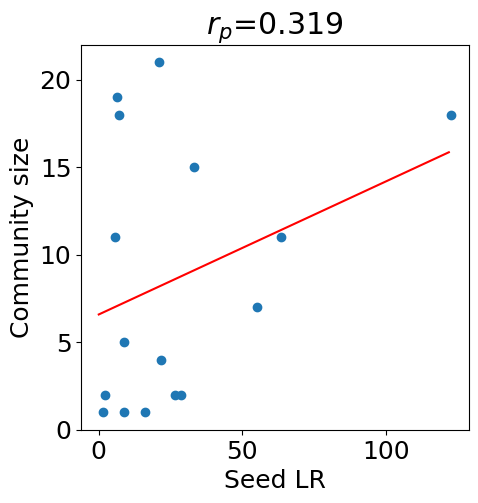

R2: 0.109


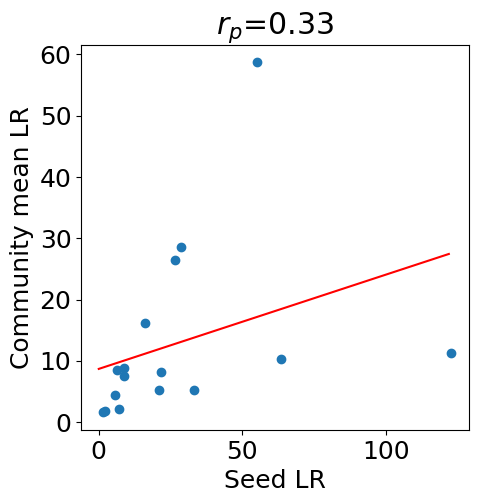

In [30]:
# plot correltaion between seed LR and community size
X = np.array(seed_error_50d["Seed LR"])
y = seed_error_50d["# community"]

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(X,y)
# plot linear regression line
reg = LinearRegression().fit(X.reshape(-1,1), y)
print("R2:", round(reg.score(X.reshape(-1,1), y),3))
ax.plot(reg.predict(np.arange(0,max(X)).reshape(-1,1)), color="red")

ax.set(xlabel="Seed LR", ylabel = "Community size", title=f"$r_p$={round(corr_p['Seed LR']['# community'],3)}")
plt.savefig('figures/lgde_corr_seed_size-50d.pdf', bbox_inches='tight')
plt.show()

# plot correlation between seed LR and mean community LR
X = np.array(seed_error_50d["Seed LR"])
y = seed_error_50d["Mean LR"]
X = X[~ np.isnan(y)]
y = y[~ np.isnan(y)]

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(X,y)
# plot linear regression line
reg = LinearRegression().fit(X.reshape(-1,1), y)
print("R2:", round(reg.score(X.reshape(-1,1), y),3))
ax.plot(reg.predict(np.arange(0,max(X)).reshape(-1,1)), color="red")

ax.set(xlabel="Seed LR", ylabel = "Community mean LR", title=f"$r_p$={round(corr_p['Seed LR']['Mean LR'],3)}")
plt.savefig('figures/lgde_corr_seed_lr-50d.pdf', bbox_inches='tight')
plt.show()

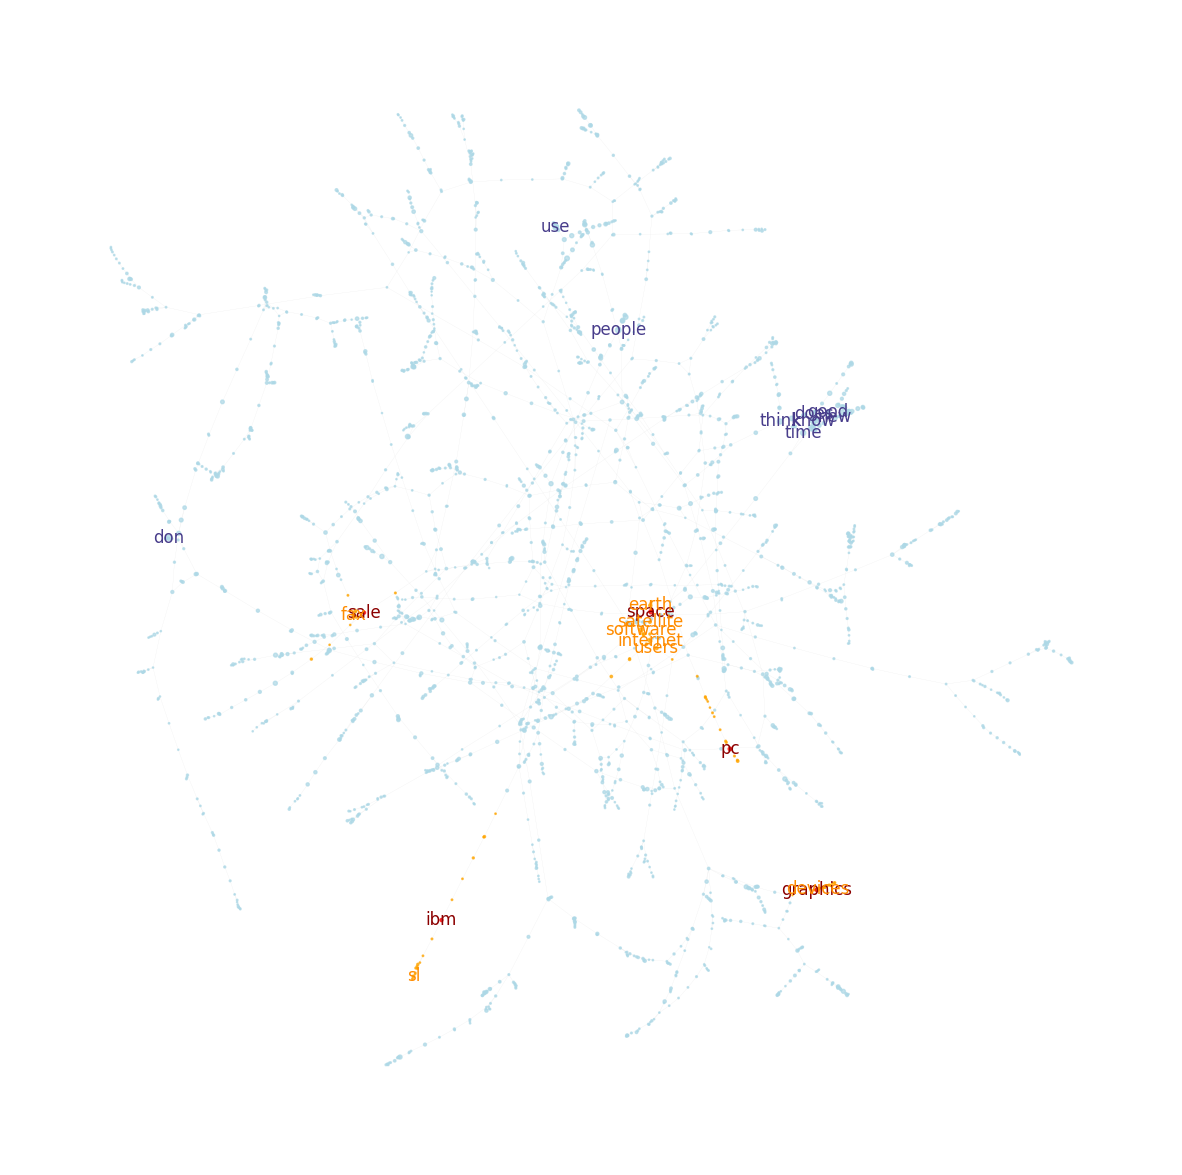

In [31]:
# visualise semantic network
lgde_50d.construct_nx_graph()
fig = lgde_50d.plot_semantic_network(n_top=15,doc_freq=list(doc_freq),lcc_only=True,node_size_factor=0.2,alpha=0.7,edge_width=0.1,plot_with_other_words=True)
fig.savefig("figures/newsgroups_semantic_network_50d.pdf",dpi=fig.dpi,bbox_inches="tight")

The keyword 'computer' is a singleton semantic community.


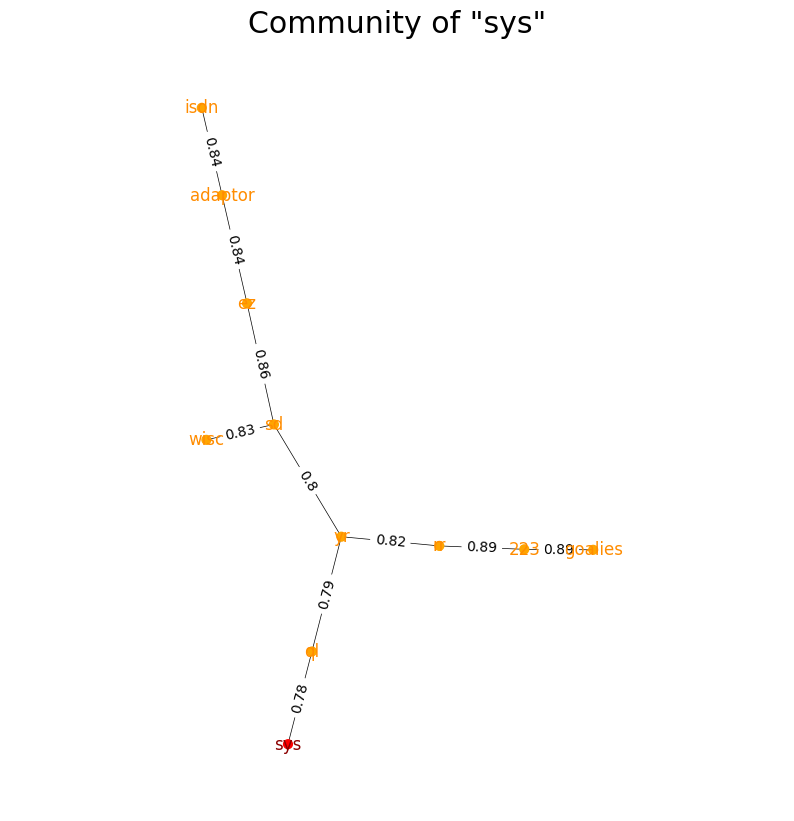

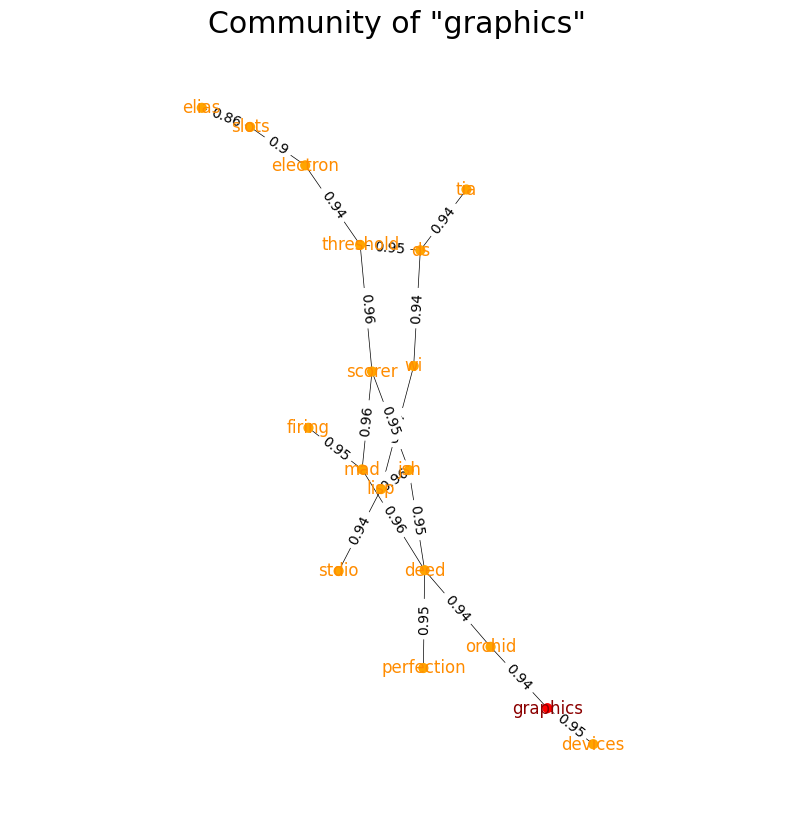

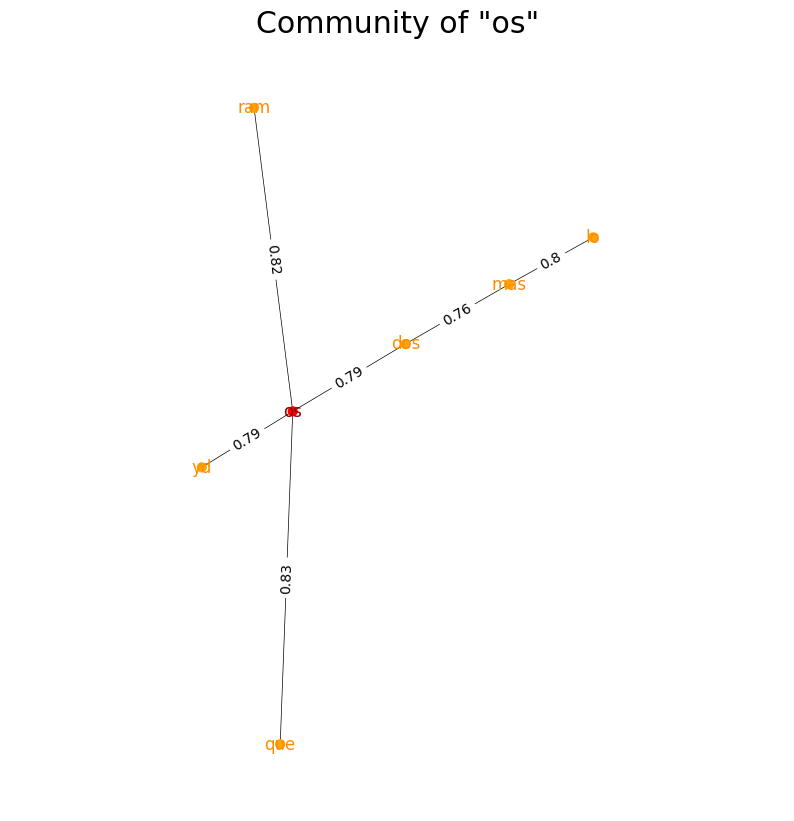

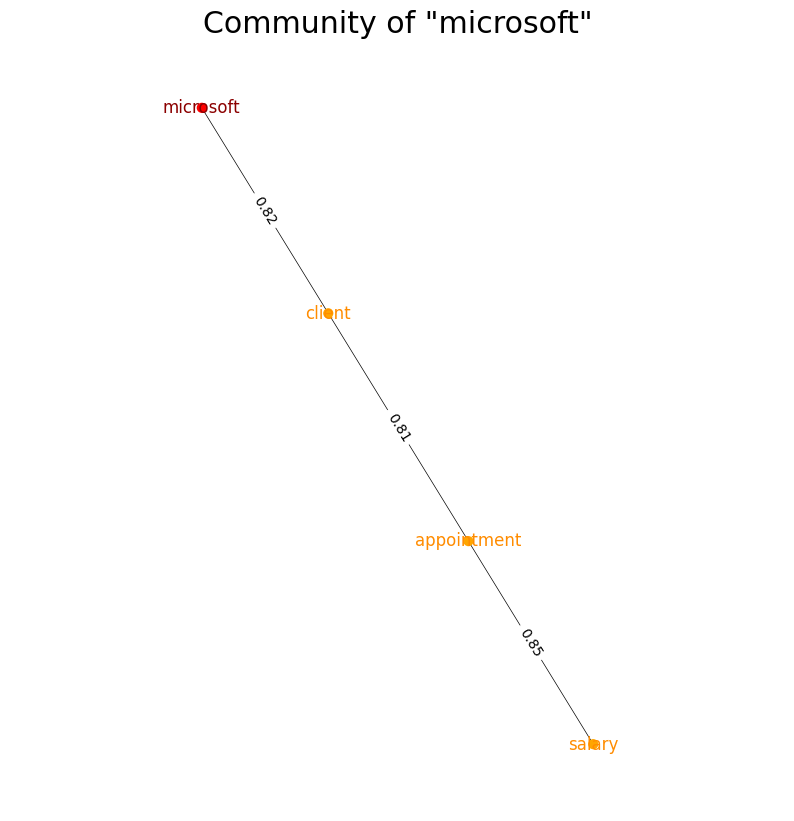

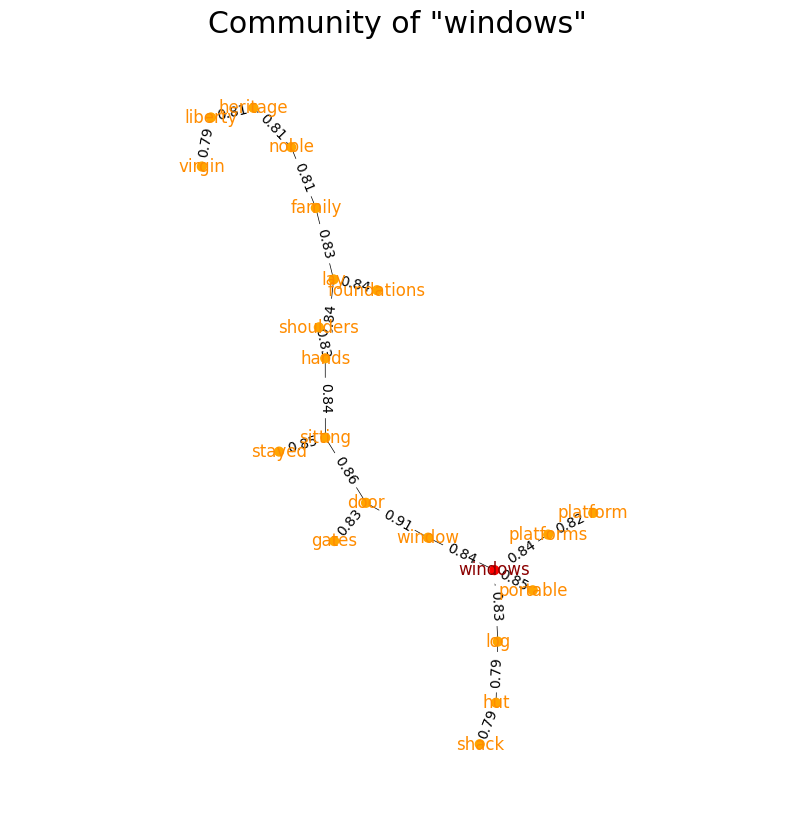

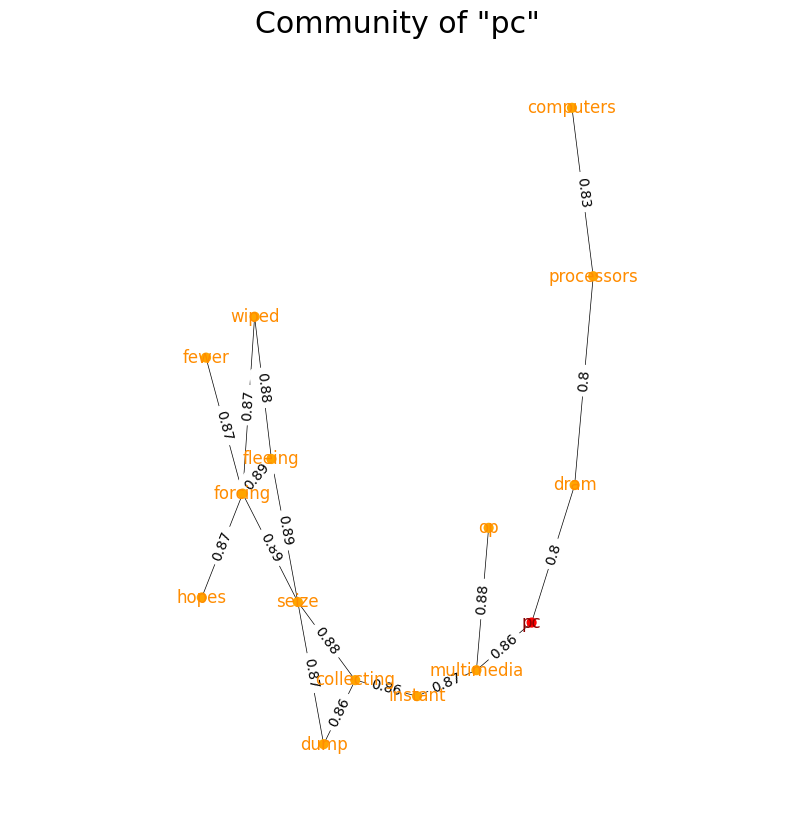

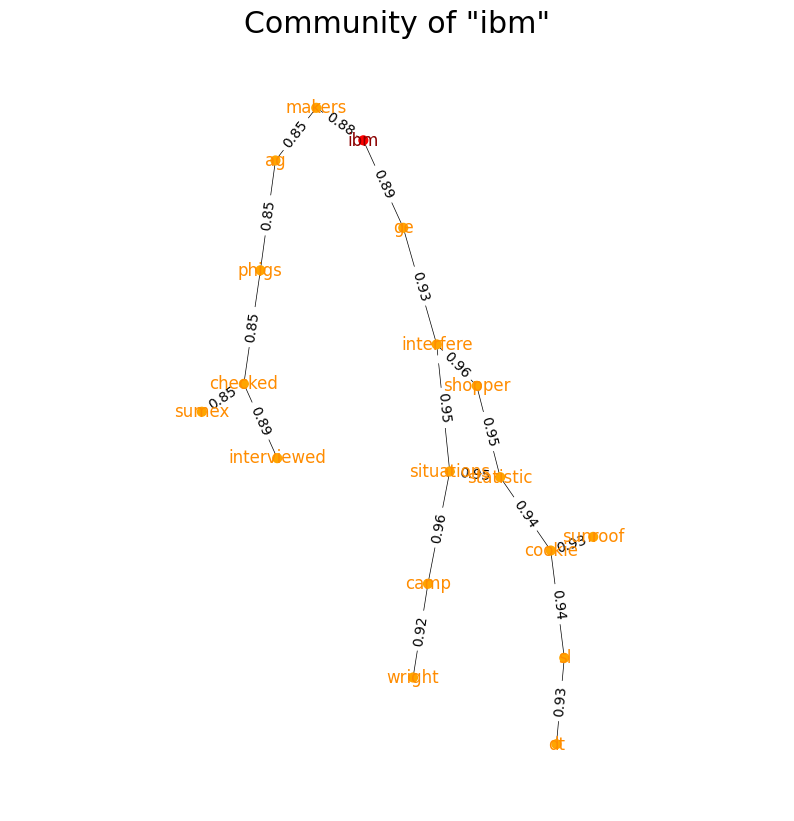

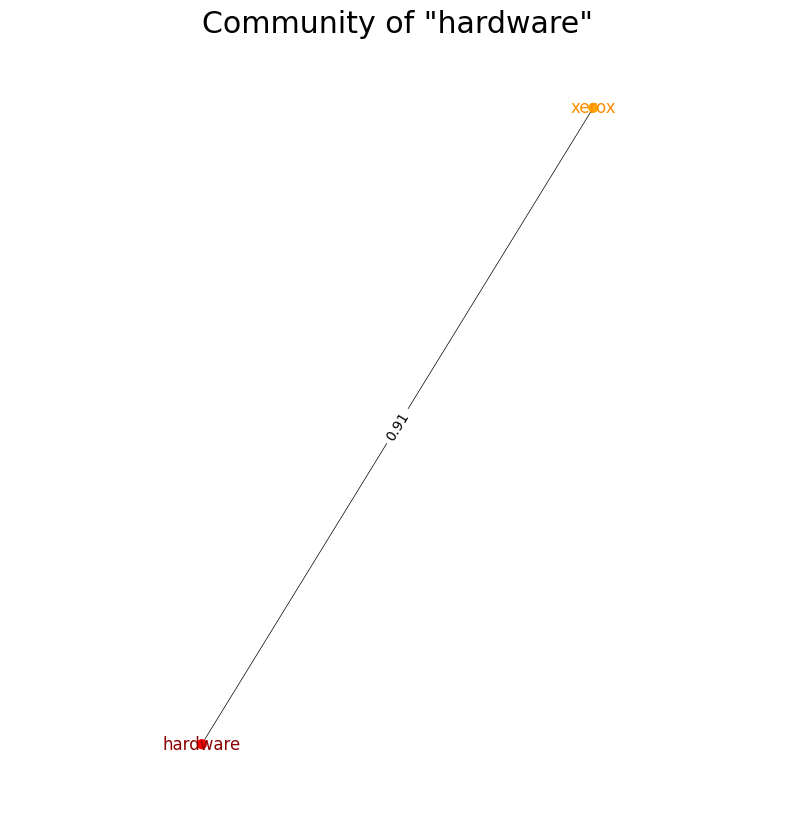

The keyword 'mac' is a singleton semantic community.


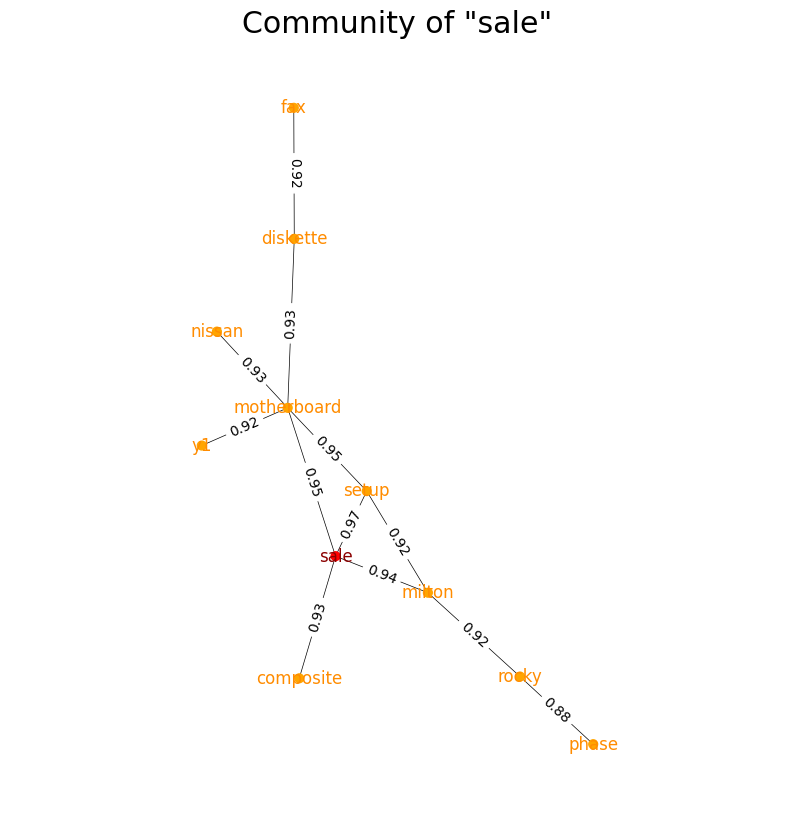

The keyword 'science' is a singleton semantic community.


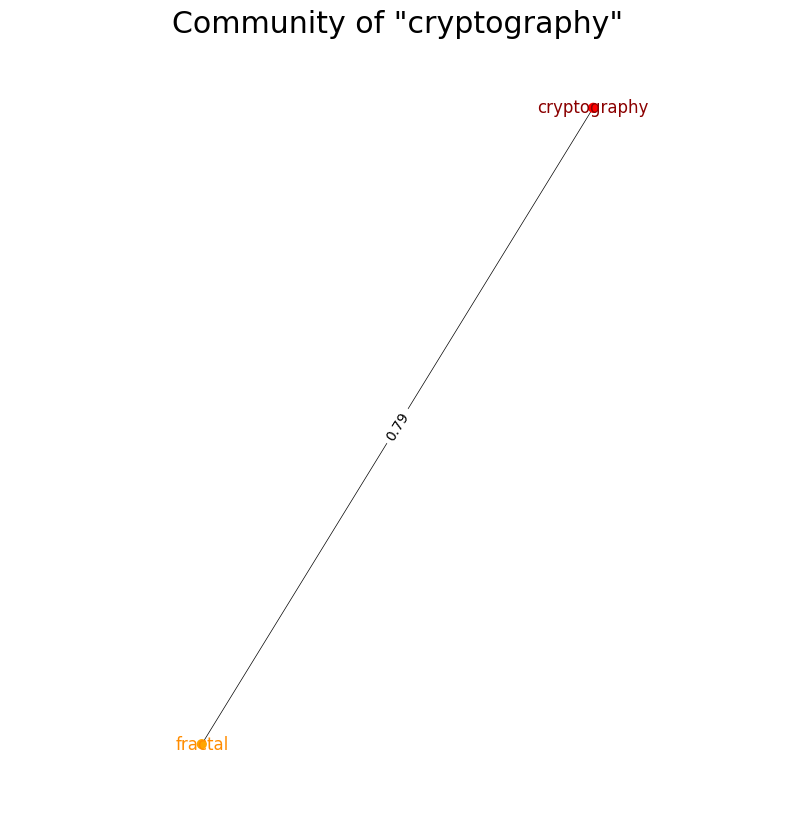

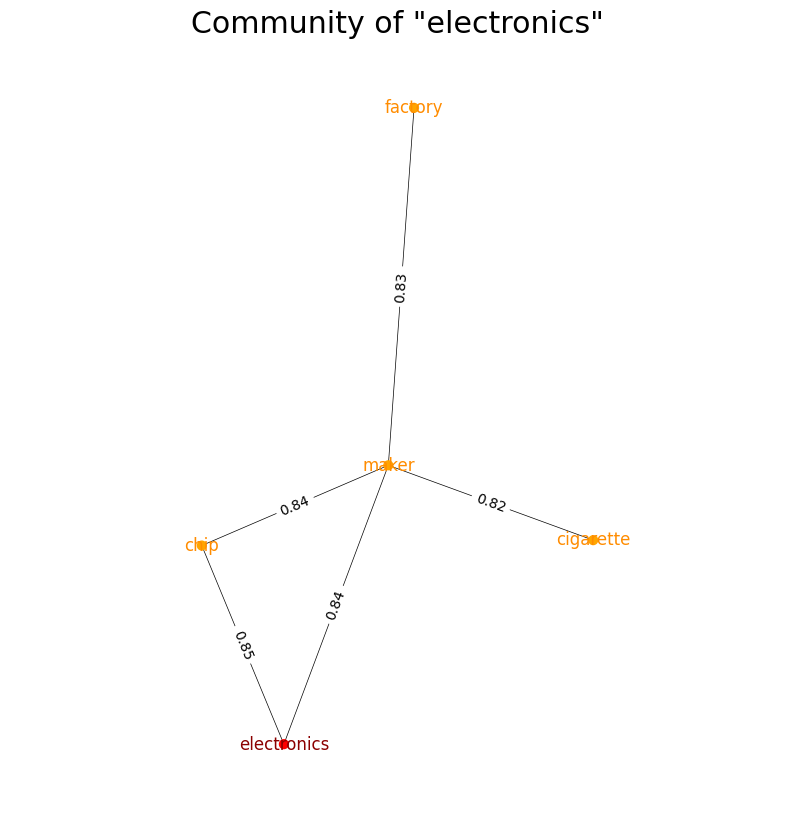

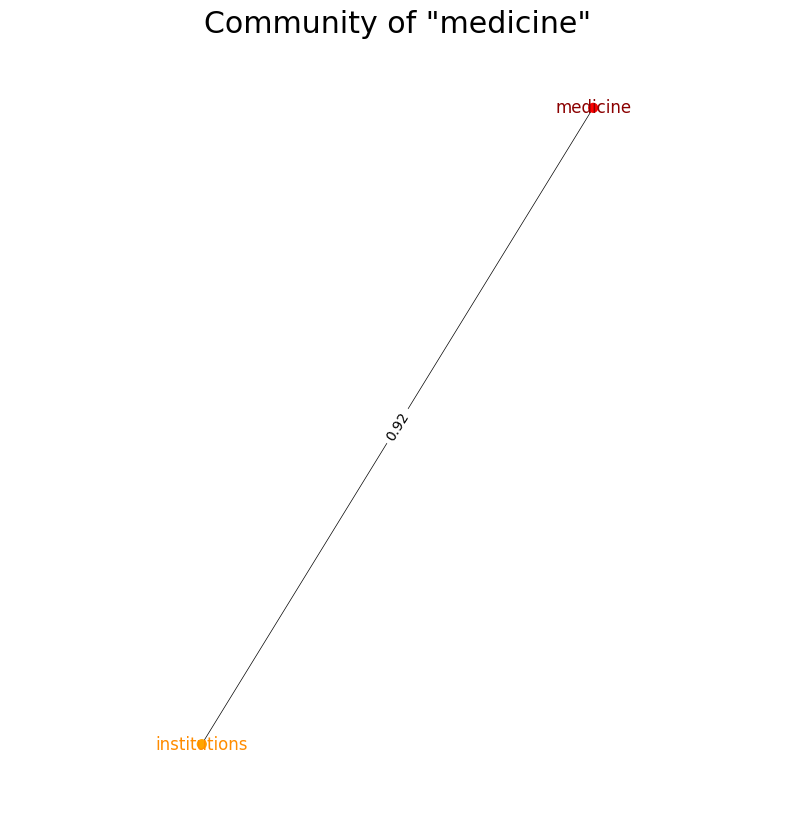

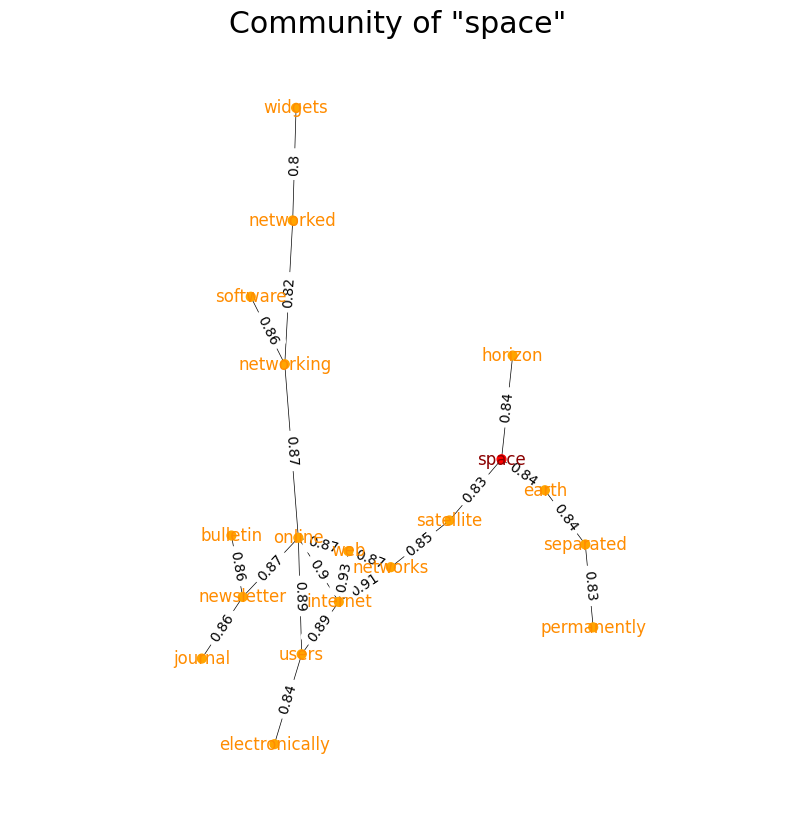

In [32]:
# plot semantic communities
lgde_50d.plot_semantic_communities(figsize=(10,10),path="figures/50d-")

### 5.5) Significance tests

In [33]:
# get thresholding of same size as LGDE
eps_samesize = eps[np.argmin(size_th>len(lgde_50d.discovered_dict_))]
thres_50d_prime = Thresholding(seed_dict,word_list,word_vecs_50d)
thres_50d_prime.expand(eps_samesize)

# evaluate thresholding on test data
print("\nTest scores for same size thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_50d_prime.expanded_dict_, y_test, dt_test)

# determine which words are only found by LGDE or thresholding
lgde_only_50 =  list(set(lgde_50d.discovered_dict_) -  set(thres_50d_prime.discovered_dict_))
thres_only_50_prime = list(set(thres_50d_prime.discovered_dict_) - set(lgde_50d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE")

print("\nMedian LR+ Thresholding:", round(np.median(likelihood_ratio_positive[thres_only_50_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_50]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_50],likelihood_ratio_positive[thres_only_50_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del thres_50d_prime
del thres_only_50_prime


Test scores for same size thresholding expanded dictionary at $r=50$:

              precision    recall  f1-score   support

       False      0.557     0.552     0.554      3608
        True      0.591     0.596     0.594      3924

    accuracy                          0.575      7532
   macro avg      0.574     0.574     0.574      7532
weighted avg      0.575     0.575     0.575      7532


COMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE

Median LR+ Thresholding: 0.92
Median LR+ LGDE: 2.15
Mann-Whitney U test with alternative "greater": p = 0.00108


In [34]:
#######
# kNN #
#######

# get kNN of same size as LGDE
ks_knn_samesize = ks_knn[np.argmin(np.abs(size_knn - len(lgde_50d.discovered_dict_)))]
knn_50d_prime = KNearestNeighbors(seed_dict,word_list,word_vecs_50d)
knn_50d_prime.expand(ks_knn_samesize)

# determine which words are only found by LGDE or kNN
lgde_only_50 =  list(set(lgde_50d.discovered_dict_) -  set(knn_50d_prime.discovered_dict_))
knn_only_50d_prime = list(set(knn_50d_prime.discovered_dict_) - set(lgde_50d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST kNN OF SAME SIZE")

print("\nMedian LR+ kNN:", round(np.median(likelihood_ratio_positive[knn_only_50d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_50]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_50],likelihood_ratio_positive[knn_only_50d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_50],likelihood_ratio_positive[knn_only_50d_prime],alternative='less',method='exact')
print('Mann-Whitney U test with alternative "less": p =', np.around(p,5))

# free up memory
del knn_50d_prime


COMPARISON BETWEEN BEST LGDE AND BEST kNN OF SAME SIZE

Median LR+ kNN: 1.99
Median LR+ LGDE: 1.61
Mann-Whitney U test with alternative "greater": p = 0.97493
Mann-Whitney U test with alternative "less": p = 0.02526


In [35]:
############
# TextRank #
############

# get TextRank of same size as LGDE
ind_tr_samesize = np.argmin(np.abs(size_tr[ind_tr[0]] - len(lgde_50d.discovered_dict_)))
tr_50d_prime = discovered_dicts_tr[ind_tr[0]][ind_tr_samesize]

# determine which words are only found by LGDE or TextRank
lgde_only_50 =  list(set(lgde_50d.discovered_dict_) -  set(tr_50d_prime))
tr_only_50d_prime = list(set(tr_50d_prime) - set(lgde_50d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST TextRank OF SAME SIZE")

print("\nMedian LR+ TextRank:", round(np.median(likelihood_ratio_positive[tr_only_50d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_50]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_50],likelihood_ratio_positive[tr_only_50d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,7))


COMPARISON BETWEEN BEST LGDE AND BEST TextRank OF SAME SIZE

Median LR+ TextRank: 1.17
Median LR+ LGDE: 2.02
Mann-Whitney U test with alternative "greater": p = 0.0945484


In [36]:
# free up memory
del lgde_50d

## 6) Detailed comparison for dimension $r=100$

In [37]:
##############
# GS results #
##############

# unpack results for thresholding
eps = results_100d["th"]["eps"]
fscore_th = results_100d["th"]["fscore"]
precision_th = results_100d["th"]["precision"]
recall_th = results_100d["th"]["recall"]
size_th = results_100d["th"]["size"]

# unpack results for kNN
ks_knn = results_100d["knn"]["ks"]
fscore_knn = results_100d["knn"]["fscore"]
precision_knn = results_100d["knn"]["precision"]
recall_knn = results_100d["knn"]["recall"]
size_knn = results_100d["knn"]["size"]

# unpack results_100d for IKEA
eps_ikea = results_100d["ikea"]["eps"]
fscore_ikea = results_100d["ikea"]["fscore"]
precision_ikea = results_100d["ikea"]["precision"]
recall_ikea = results_100d["ikea"]["recall"]
size_ikea = results_100d["ikea"]["size"]

# unpack results_100d for CkNN + LSWL
ks_lswl = results_100d["lswl"]["ks"]
fscore_lswl = results_100d["lswl"]["fscore"]
precision_lswl = results_100d["lswl"]["precision"]
recall_lswl = results_100d["lswl"]["recall"]
size_lswl = results_100d["lswl"]["size"]

# unpack results for LGDE
times = results_100d["lgde"]["times"]
ks = results_100d["lgde"]["ks"]
commmunities = results_100d["lgde"]["communities"]
fscore_lgde = results_100d["lgde"]["fscore"]
precision_lgde = results_100d["lgde"]["precision"]
recall_lgde = results_100d["lgde"]["recall"]
size_lgde = results_100d["lgde"]["size"]

# apply size constraints to thresholding
fscore_sc_th = fscore_th.copy()
fscore_sc_th[min_size > size_th] = np.nan
fscore_sc_th[size_th > max_size] = np.nan

# apply size constraints to kNN
fscore_sc_knn = fscore_knn.copy()
fscore_sc_knn[min_size > size_knn] = np.nan
fscore_sc_knn[size_knn > max_size] = np.nan

# apply size constraints to CkNN + LSWL
fscore_sc_lswl = fscore_lswl.copy()
fscore_sc_lswl[min_size > size_lswl] = np.nan
fscore_sc_lswl[size_lswl > max_size] = np.nan 

# apply size constraints to lgde
fscore_sc_lgde = fscore_lgde.copy()
for ind_pair in np.argwhere(size_lgde < min_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.nan
for ind_pair in np.argwhere(size_lgde > max_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.nan

# compute best thresholding hyperparameter
ind_th = np.nanargmax(fscore_sc_th)
best_epsilon_100d = eps[ind_th]

# compute best knn hyperparameter
ind_knn = np.nanargmax(fscore_sc_knn)
best_k_100d_knn = ks_knn[ind_knn]

# compute best lswl hyperparameter
ind_lswl = np.nanargmax(fscore_sc_lswl)
best_k_100d_lswl = ks_lswl[ind_lswl]

# compute best LGDE hyperparamers
ind_lgde = tuple(np.argwhere(fscore_sc_lgde == np.nanmax(fscore_sc_lgde))[0])
best_k_100d = ks[ind_lgde[0]]
best_t_100d = times[ind_lgde[1]]

### 6.1) Thresholding


### Thresholding ###

Best epsilon at $r=100$: 0.807


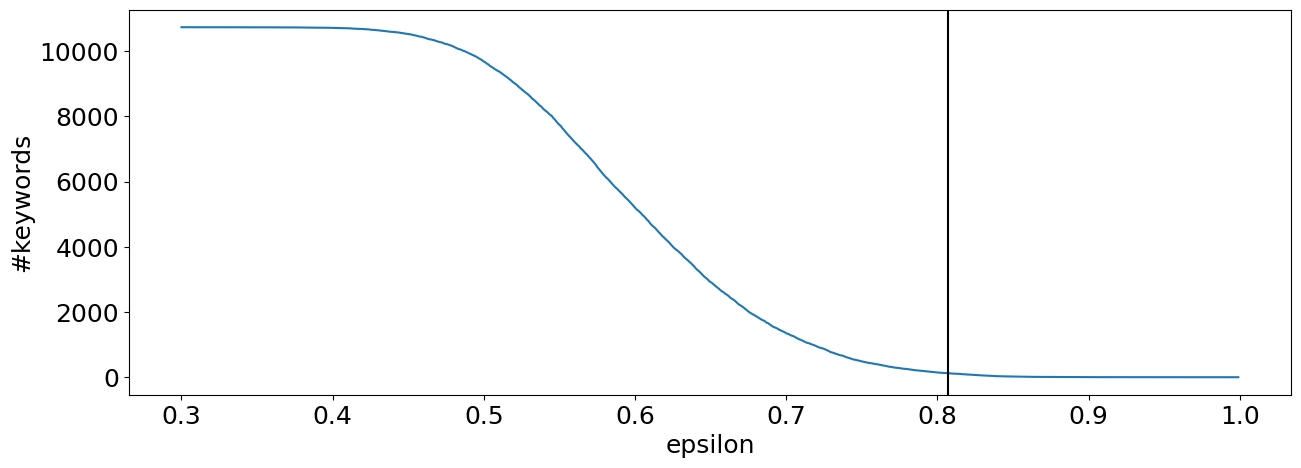

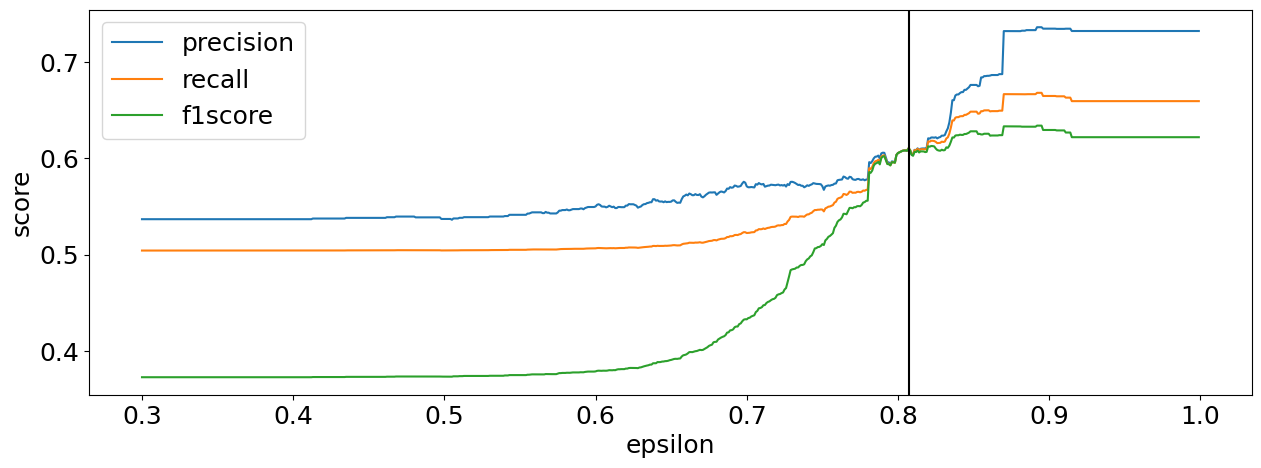

Number of discovered keywords at $r=100$: 125 

Epsilon balls:

computer --> ['case', 'original', 'associated', 'various', 'clever', 'calls', 'computer', 'speed', 'tried', 'techniques', 'claims', 'conventional', 'reporter', 'farm', 'services', 'reveal', 'linux', 'peculiar', 'transportation', 'raw', 'truecolor', 'classroom', 'specialist', 'retail', 'marketing', 'outlets', 'lest', 'housed', 'halfway']
sys --> ['sys']
graphics --> ['orchid', 'graphics', 'post', 'matt', 'devices', 'golden', 'ms', 'holds', 'hear', 'week', 'convex', 'knocking', 'pentium', 'guidance', 'text', 'upenn', 'voltage', 'degrees', 'hat', 'db', 'plenty', 'statistic', 'situations', 'cookie', 'transmissions', 'correspondence', 'firing', 'composed', 'clh', 'shopper', 'modems', 'hopkins', 'wi', 'minorities', 'ala', 'eric', 'camp', 'echo', 'sport', 'fpu', 'thier', 'spite', 'dynamic', 'threshold', 'wright', 'ds', 'sucked', 'deed', 'focusing', 'jsh', 'coat', 'electron', 'theoretically', 'bumper', 'wholesale', '134', 'tia', '

In [38]:
################
# Thresholding #
################

print("\n### Thresholding ###\n")

print("Best epsilon at $r=100$:",round(best_epsilon_100d,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,size_th)
ax.axvline(x=best_epsilon_100d, c = 'black')
ax.set(xlabel="epsilon", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,precision_th,label="precision")
ax.plot(eps,recall_th,label="recall")
ax.plot(eps,fscore_th,label="f1score")
ax.axvline(x=best_epsilon_100d, c = 'black')
ax.set(xlabel="epsilon",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal epsilon
thres_100d = Thresholding(seed_dict,word_list,word_vecs_100d)
thres_100d.expand(best_epsilon_100d)

print("Number of discovered keywords at $r=100$:", thres_100d.n_discovered,"\n")

print("Epsilon balls:\n")
for keyword in thres_100d.seed_dict[:15]:
    print(keyword,"-->",thres_100d.epsilon_balls_[keyword])

print("\nDiscovered words:", sorted(thres_100d.discovered_dict_))

print("\nTrain scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(thres_100d.expanded_dict_, y_train, dt_train)

print("\nTest scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_100d.expanded_dict_, y_test, dt_test)

# free up memory
del thres_100d

### 6.2) kNN


### kNN ###

Best k at $r=100$: 7


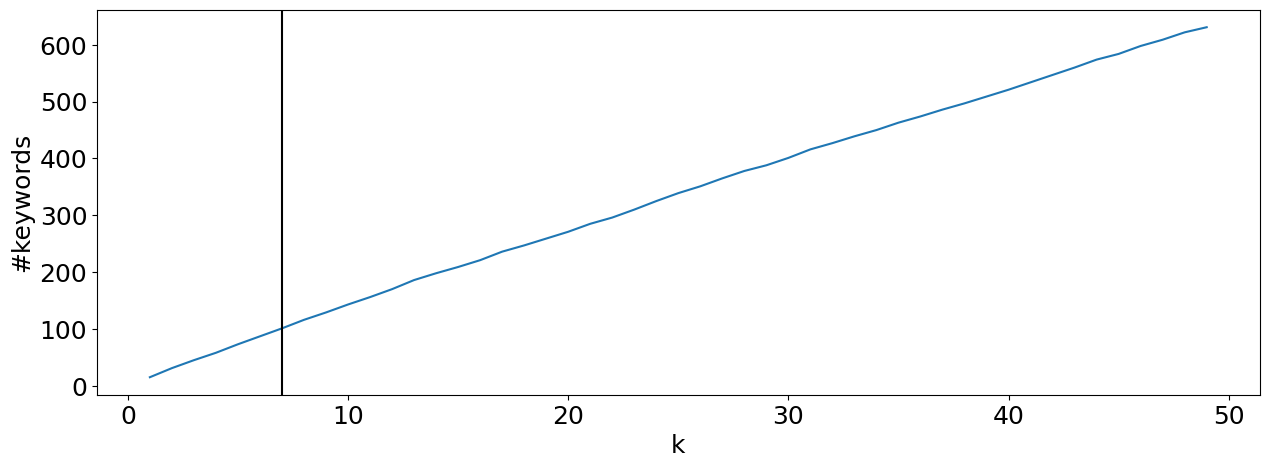

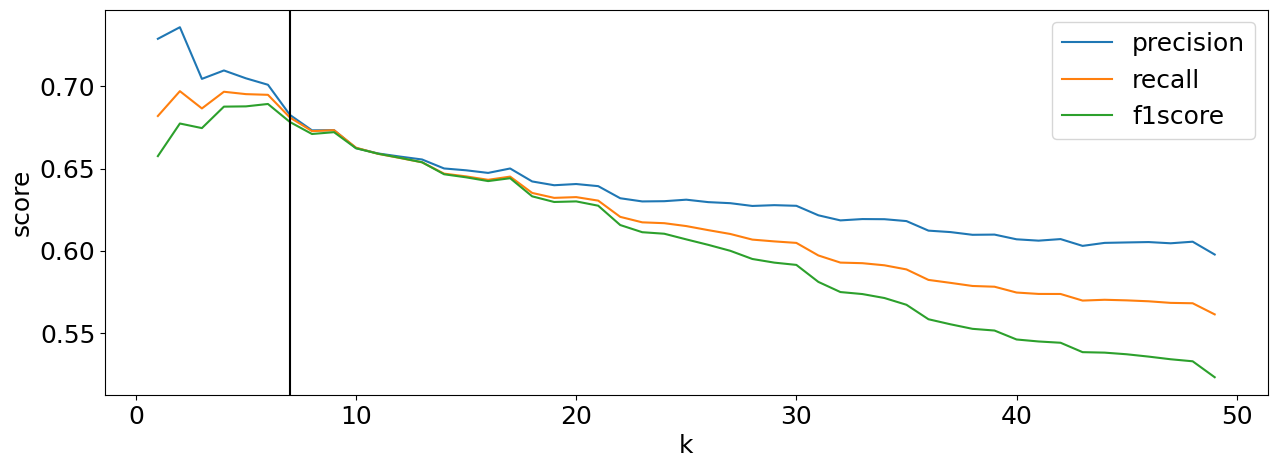

Number of discovered keywords at $r=100$: 101 

k-nearest neighbors:

computer --> ['computer', 'various', 'outlets', 'conventional', 'transportation', 'retail', 'services', 'specialist']
sys --> ['sys', 'comp', 'tmp', 'bbs', '6e', 'md5', '030', '3k']
graphics --> ['graphics', 'orchid', 'devices', 'bumper', 'composed', 'ds', 'radiosity', 'post']
os --> ['os', 'ram', 'ported', 'unix', 'dos', 'app', 'macintosh', 'pc']
microsoft --> ['microsoft', 'intel', 'software', 'apple', 'ibm', 'compaq', 'client', 'developers']
windows --> ['windows', 'window', 'portable', 'door', 'apple', 'install', 'platforms', 'disk']
pc --> ['pc', 'computer', 'multimedia', 'software', 'console', 'computers', 'online', 'macintosh']
ibm --> ['ibm', 'ge', 'xerox', 'intel', 'makers', 'hardware', 'microsoft', 'packard']
hardware --> ['hardware', 'modem', 'wi', 'panasonic', 'offers', 'storing', 'ds', 'lisp']
mac --> ['mac', 'carter', 'launchers', 'hubble', 'cd', 'manifest', 'immune', 'penguin']
sale --> ['sale', 'mothe

In [39]:
#######
# kNN #
#######

print("\n### kNN ###\n")

print("Best k at $r=100$:",round(best_k_100d_knn,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_knn,size_knn)
ax.axvline(x=best_k_100d_knn, c = 'black')
ax.set(xlabel="k", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_knn,precision_knn,label="precision")
ax.plot(ks_knn,recall_knn,label="recall")
ax.plot(ks_knn,fscore_knn,label="f1score")
ax.axvline(x=best_k_100d_knn, c = 'black')
ax.set(xlabel="k",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal k
knn_100d = KNearestNeighbors(seed_dict,word_list,word_vecs_100d)
knn_100d.expand(best_k_100d_knn)

print("Number of discovered keywords at $r=100$:", knn_100d.n_discovered,"\n")

print("k-nearest neighbors:\n")
for keyword in knn_100d.seed_dict[:15]:
    print(keyword,"-->",knn_100d.neighbors_[keyword])

print("\nDiscovered words:", sorted(knn_100d.discovered_dict_))

print("\nTrain scores for kNN expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(knn_100d.expanded_dict_, y_train, dt_train)

print("\nTest scores for kNN expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(knn_100d.expanded_dict_, y_test, dt_test)

# free up memory
del knn_100d

### 6.3) Other local community detection methods


### LSWL / SIWO ###

Best k at $r=100$: 7


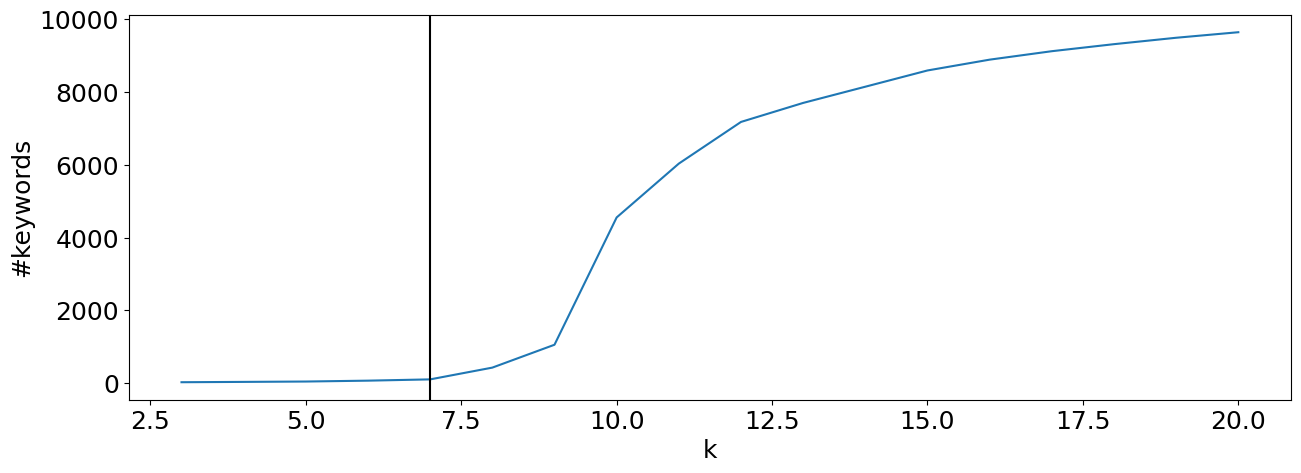

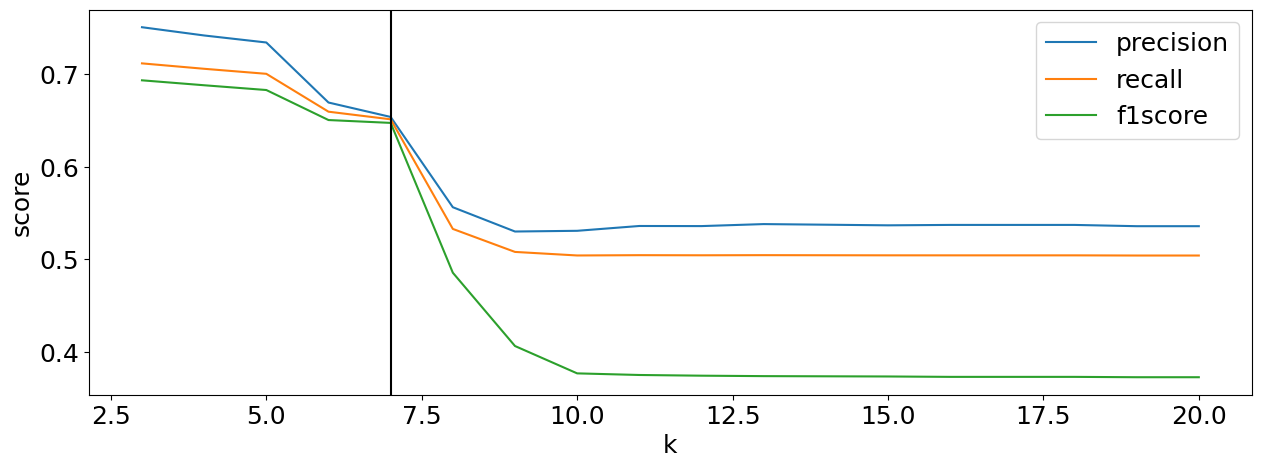

100%|██████████| 16/16 [00:00<00:00, 163.66it/s]

Number of discovered keywords at $r=100$: 108 

Semantic communities:

computer --> ['computer', 'sector', 'sell', 'services', 'linux', 'owning', 'transportation', 'specialist', 'retail', 'marketing']
sys --> ['comp', 'sys', 'tmp']
graphics --> ['orchid', 'graphics', 'devices', 'golden', 'ms', 'lud', 'firing', 'composed', 'rs232', 'wi', 'ala', 'fpu', 'threshold', 'ds', 'deed', 'stdio', 'jsh', 'electron', '134', 'perfection', 'lisp', 'scorer', 'radiosity']
os --> ['os', 'app', 'downloaded', 'downloading', 'uploaded', 'upload', 'roms', 'sdk']
microsoft --> ['intel', 'ibm', 'microsoft', 'micron', 'compaq', 'hp', 'apple', 'hewlett', 'packard', 'motorola', 'sony', 'toshiba', 'adaptec', 'fujitsu', 'dell', 'lg', 'kodak']
windows --> ['window', 'windows', 'door', 'tower', 'gate', 'gates', 'entrance']
pc --> ['pc', 'op', 'collecting', 'destination', 'multimedia', 'instant']
ibm --> ['intel', 'ibm', 'microsoft', 'micron', 'compaq', 'hp', 'apple', 'hewlett', 'packard', 'motorola', 'sony', 'toshib

In [40]:
########
# LSWL #
########

print("\n### LSWL / SIWO ###\n")

print("Best k at $r=100$:",round(best_k_100d_lswl,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_lswl,size_lswl)
ax.axvline(x=best_k_100d_lswl, c = 'black')
ax.set(xlabel="k", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_lswl,precision_lswl,label="precision")
ax.plot(ks_lswl,recall_lswl,label="recall")
ax.plot(ks_lswl,fscore_lswl,label="f1score")
ax.axvline(x=best_k_100d_lswl, c = 'black')
ax.set(xlabel="k",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal k
lswl_100d = LGDEWithCDlib(seed_dict,word_list,word_vecs_100d)
lswl_100d.expand(best_k_100d_lswl, method="lswl")

print("Number of discovered keywords at $r=100$:", lswl_100d.n_discovered,"\n")

print("Semantic communities:\n")
for keyword in lswl_100d.seed_dict[:15]:
    print(keyword,"-->",lswl_100d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lswl_100d.discovered_dict_))

print("\nTrain scores for LSWL expanded dictionary at $r=100$:\n")
_,_,_ =  evaluate_prediction(lswl_100d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LSWL expanded dictionary at $r=100$:\n")
_,_,_ = evaluate_prediction(lswl_100d.expanded_dict_, y_test, dt_test)

# free up memory
del lswl_100d

In [41]:
#########
# Mod R #
#########

# unpack dictionary
modr_size = results_localmod_100d["modr"]["size"]
modr_fscore_train = results_localmod_100d["modr"]["fscore_train"]
modr_fscore_test = results_localmod_100d["modr"]["fscore_test"]
modr_ks = results_localmod_100d["modr"]["ks"]

# apply size constraints
modr_fscore_train_sc = []
modr_fscore_test_sc = []

for i in range(len(modr_ks)):
    # comput size constraint indices per k
    sc_ind = (modr_size[i] <= max_size) * (modr_size[i] >= min_size)
    modr_fscore_train_sc.append(modr_fscore_train[i][sc_ind])
    modr_fscore_test_sc.append(modr_fscore_test[i][sc_ind])

# find best k based on mean train F1 scores of admissible dictionaries
modr_fscore_train_sc_mean = np.array([np.array(scores_k).mean() if len(scores_k) > 0 else np.nan for scores_k in modr_fscore_train_sc])
modr_best_k_ind = np.nanargmax(modr_fscore_train_sc_mean)
modr_best_k = modr_ks[modr_best_k_ind]
print("Best k for 'modr':",modr_best_k)
print("Number of admissible dictionaries:", len(modr_fscore_train_sc[modr_best_k_ind]))


# compute 95% CIs for train and test F1 scores
modr_fscore_train_m, modr_fscore_train_l, modr_fscore_train_r = mean_confidence_interval(modr_fscore_train_sc[modr_best_k_ind])
print(f"Average train F1 score for 'modr': {modr_fscore_train_m} ({modr_fscore_train_l}--{modr_fscore_train_r})")
modr_fscore_test_m, modr_fscore_test_l, modr_fscore_test_r = mean_confidence_interval(modr_fscore_test_sc[modr_best_k_ind],digits=4)
print(f"Average test F1 score for 'modr': {modr_fscore_test_m} ({modr_fscore_test_l}--{modr_fscore_test_r})")

#########
# Mod M #
#########

# unpack dictionary
modm_size = results_localmod_100d["modm"]["size"]
modm_fscore_train = results_localmod_100d["modm"]["fscore_train"]
modm_fscore_test = results_localmod_100d["modm"]["fscore_test"]
modm_ks = results_localmod_100d["modm"]["ks"]

# apply size constraints
modm_fscore_train_sc = []
modm_fscore_test_sc = []

for i in range(len(modm_ks)):
    # comput size constraint indices per k
    sc_ind = (modm_size[i] <= max_size) * (modm_size[i] >= min_size)
    modm_fscore_train_sc.append(modm_fscore_train[i][sc_ind])
    modm_fscore_test_sc.append(modm_fscore_test[i][sc_ind])

# find best k based on mean train F1 scores of admissible dictionaries
modm_fscore_train_sc_mean = np.array([np.array(scores_k).mean() if len(scores_k) > 0 else np.nan for scores_k in modm_fscore_train_sc])
modm_best_k_ind = np.nanargmax(modm_fscore_train_sc_mean)
modm_best_k = modm_ks[modm_best_k_ind]
print("\nBest k for 'modm':",modm_best_k)
print("Number of admissible dictionaries:", len(modm_fscore_train_sc[modm_best_k_ind]))

# compute 95% CIs for train and test F1 scores
modm_fscore_train_m, modm_fscore_train_l, modm_fscore_train_r = mean_confidence_interval(modm_fscore_train_sc[modm_best_k_ind])
print(f"Average train F1 score for 'modm': {modm_fscore_train_m} ({modm_fscore_train_l}--{modm_fscore_train_r})")
modm_fscore_test_m, modm_fscore_test_l, modm_fscore_test_r = mean_confidence_interval(modm_fscore_test_sc[modm_best_k_ind])
print(f"Average test F1 score for 'modm': {modm_fscore_test_m} ({modm_fscore_test_l}--{modm_fscore_test_r})")

Best k for 'modr': 11
Number of admissible dictionaries: 50
Average train F1 score for 'modr': 0.659 (0.659--0.66)
Average test F1 score for 'modr': 0.6505 (0.6502--0.6508)

Best k for 'modm': 7
Number of admissible dictionaries: 50
Average train F1 score for 'modm': 0.666 (0.665--0.666)
Average test F1 score for 'modm': 0.659 (0.658--0.66)


### 6.4) LGDE


### LGDE ###

Best hyperparameters at $r=100$:k=5, t=8


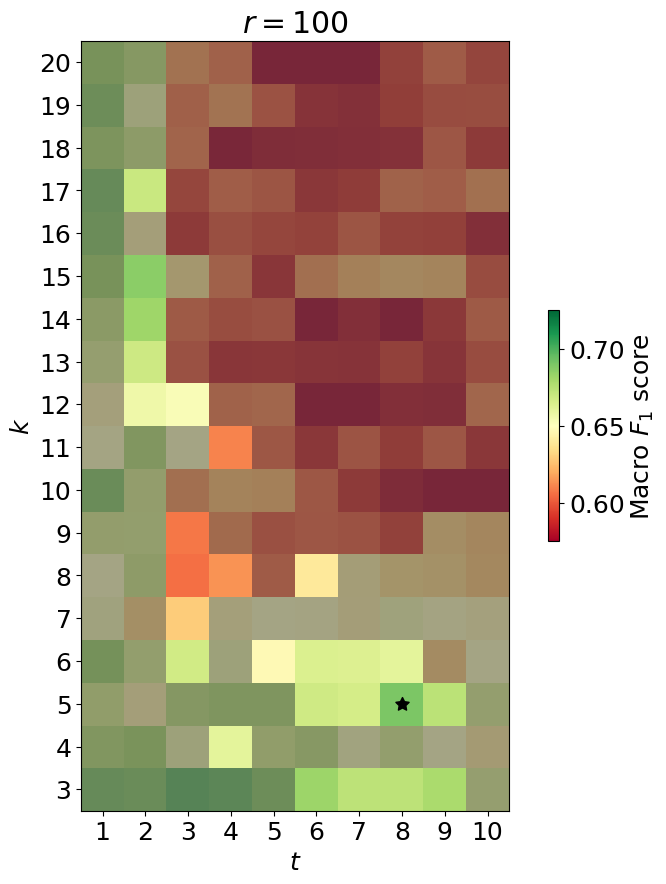

100%|██████████| 16/16 [02:03<00:00,  7.75s/it]


Number of discovered keywords: 149 

Semantic communities:

computer --> ['computer', 'linux']
sys --> ['sys', 'comp', 'tmp', 'tm', 'prism', 'ts', 'moto', 'sho', 'cg', 'mod', 'gq', 'blurb', '80ns', 'hd', 'cdrom', 'costing', '0l', 'xwindows', '7u', 'linked', 'mandate']
graphics --> ['graphics']
os --> ['os', 'dos', 'da', 'ram', 'vesa', 'stealth', 'ported', 'proton', 'micro', 'emulator', 'freeware']
microsoft --> ['microsoft', 'apple', 'intel', 'semiconductor', 'motorola', 'compaq', 'hewlett', 'hp', 'packard', 'dell', 'fujitsu', 'toshiba', 'lg', 'novell', 'microsystems', 'kodak', 'sony', 'kt', 'micron', 'adaptec']
windows --> ['portable', 'handheld', 'logitech', 'console', 'nintendo', 'startup', 'pc', 'dram', 'multimedia', 'processors', 'deluxe', 'combo', 'mini', 'procomm', 'workgroups', 'vhs', 'op', 'integrated', 'instant', 'stereo', 'vcr', 'radios', 'cd', 'mono', 'amplifier', 'cassette', 'formats', 'software', 'emulation', 'format', 'file', 'logo', 'menus', 'microphone', 'tuned', 'tun

In [42]:
########
# LGDE #
########

print("\n### LGDE ###\n")
print(f"Best hyperparameters at $r=100$:k={best_k_100d}, t={best_t_100d}")

# plot F1 score
fig, ax = plt.subplots(1, figsize=(10, 10))
im = ax.imshow(np.ones_like(fscore_lgde),cmap='Greys',origin='lower',alpha=0.7, vmin=0,vmax=1)
im = ax.imshow(fscore_lgde,cmap='RdYlGn',origin='lower',alpha=0.5,vmin=0.575,vmax=0.725)
im = ax.imshow(fscore_sc_lgde,cmap='RdYlGn',origin='lower',vmin=0.575,vmax=0.725)
ax.set(xlabel="$t$", ylabel="$k$", xticks=np.arange(len(times)),yticks=np.arange(len(ks)), xticklabels=times, yticklabels=ks)
ax.scatter(ind_lgde[1],ind_lgde[0],color='black',marker=(5, 1),s=100)
plt.colorbar(im,shrink=0.3,label="Macro $F_1$ score")
plt.title('$r=100$')
plt.savefig('figures/lgde_f1score-100d.pdf', bbox_inches='tight')
plt.show()

# expand with the optimal k and t
lgde_100d = LGDE(seed_dict,word_list,word_vecs_100d)
lgde_100d.expand(k=best_k_100d, t=best_t_100d)

print("\nNumber of discovered keywords:", lgde_100d.n_discovered,"\n")
print("Semantic communities:\n")
for keyword in lgde_100d.seed_dict:
    print(keyword,"-->",lgde_100d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lgde_100d.discovered_dict_))

print("\nTrain scores for LGDE expanded dictionary at $r=100$:\n")
_,_,_ = evaluate_prediction(lgde_100d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LGDE expanded dictionary at $r=100$:\n")
_,_,_ = evaluate_prediction(lgde_100d.expanded_dict_, y_test, dt_test)

In [43]:
print("### LGDE 100d ###\n")
_, seed_error_100d = error_analysis(lgde_100d, likelihood_ratio_positive,return_df=True)

### LGDE 100d ###

ERROR ANALYSIS DISCOVERED KWs:


LR        Seed (sim)
103           0.561965     sale (0.848) 
20th          0.212211     sale (0.768) 
biology       0.689684  science (0.778) 
birth         0.442760     sale (0.836) 
blurb         0.919579      sys (0.398) 
ceased        0.919579     sale (0.844) 
da            0.432743       os (0.579) 
degree        0.500122  science (0.639) 
divisions     0.000000     sale (0.861) 
elias         0.000000     sale (0.697) 
handheld      0.387191  windows (0.658) 
inconsistent  0.613053     sale (0.782) 
instant       0.424421  windows (0.534) 
mandate       0.162279      sys (0.346) 
milton        0.344842     sale (0.862) 
moto          0.108186      sys (0.508) 
national      0.640771     sale (0.836) 
nissan        0.197053     sale (0.846) 
rocky         0.153263     sale (0.775) 
sho           0.153263      sys (0.374) 
soderstrom    0.000000     sale (0.752) 
teaches       0.183916  science (0.657) 
thesis        0.501589  science (0.692) 
threads       0.574737  windows (0.616) 
ts            0.735663      sys (0.489) 
tuned         0.848842   windows (0.55)

ERROR ANALYSIS SEED KWs:


Seed LR  # community  LR <= 1 (in %)      Min LR   Median LR  \
computer        8.845476            2            0.00    8.845476   21.434954   
sys            63.450967           21           27.78    0.108186    2.605474   
graphics      122.763828            1            0.00  122.763828  122.763828   
os             55.174754           11           11.11    0.432743   11.034951   
microsoft      21.610112           20            0.00    2.145685    6.391076   
windows        21.112007           47           10.53    0.387191    4.597896   
pc             33.309203            1            0.00   33.309203   33.309203   
ibm             7.147639            1            0.00    7.147639    7.147639   
hardware       26.463447            1            0.00   26.463447   26.463447   
mac            16.224005            1            0.00   16.224005   16.224005   
sale            5.562333           28           50.00    0.000000    1.072842   
science         1.609264           17           23.53    0.183916    1.662316   
cryptography   28.506956           10            0.00    2.069053   13.180636   
electronics     8.933055           23            0.00    2.145685    8.276213   
medicine        2.260632            1            0.00    2.260632    2.260632   
space           6.400271            1            0.00    6.400271    6.400271   

                 Mean LR      Max LR  # Inf LR  
computer       21.434954   34.024432         0  
sys             9.061280   63.450967         3  
graphics      122.763828  122.763828         0  
os             49.487077  257.482185         2  
microsoft       9.712707   25.748219         6  
windows         8.863078   33.309203         9  
pc             33.309203   33.309203         0  
ibm             7.147639    7.147639         0  
hardware       26.463447   26.463447         0  
mac            16.224005   16.224005         0  
sale            3.232497   17.012216         4  
science         2.001140    7.356634         0  
cryptography   36.208432  154.489311         4  
electronics    10.107431   25.748219         6  
medicine        2.260632    2.260632         0  
space           6.400271    6.400271         0

In [44]:
# compute Pearson correlations between semantic community stats
corr_p = seed_error_100d.corr()
corr_p.style.background_gradient(cmap='coolwarm')

R2: 0.013


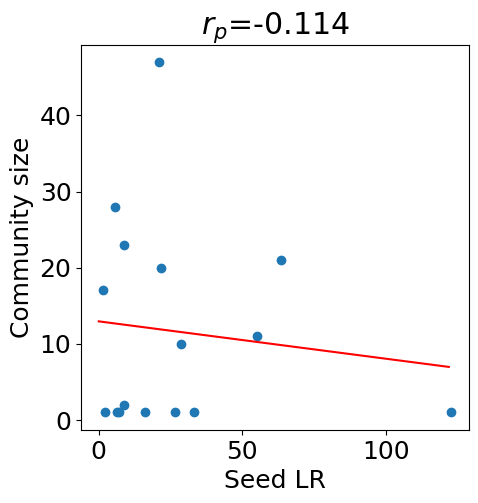

R2: 0.785


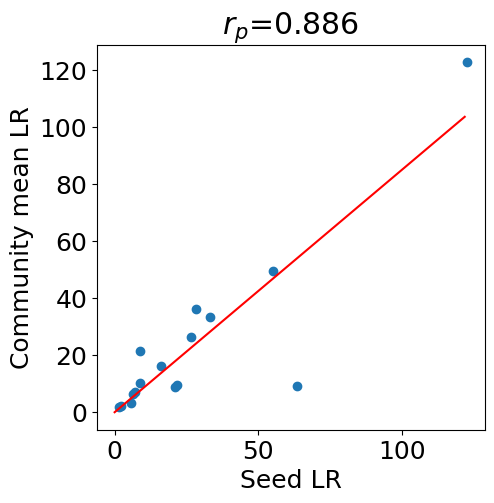

In [45]:
# plot correltaion between seed LR and community size
X = np.array(seed_error_100d["Seed LR"])
y = seed_error_100d["# community"]

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(X,y)
# plot linear regression line
reg = LinearRegression().fit(X.reshape(-1,1), y)
print("R2:", round(reg.score(X.reshape(-1,1), y),3))
ax.plot(reg.predict(np.arange(0,max(X)).reshape(-1,1)), color="red")

ax.set(xlabel="Seed LR", ylabel = "Community size", title=f"$r_p$={round(corr_p['Seed LR']['# community'],3)}")
plt.savefig('figures/lgde_corr_seed_size-100d.pdf', bbox_inches='tight')
plt.show()

# plot correlation between seed LR and mean community LR
X = np.array(seed_error_100d["Seed LR"])
y = seed_error_100d["Mean LR"]
X = X[~ np.isnan(y)]
y = y[~ np.isnan(y)]

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(X,y)
# plot linear regression line
reg = LinearRegression().fit(X.reshape(-1,1), y)
print("R2:", round(reg.score(X.reshape(-1,1), y),3))
ax.plot(reg.predict(np.arange(0,max(X)).reshape(-1,1)), color="red")

ax.set(xlabel="Seed LR", ylabel = "Community mean LR", title=f"$r_p$={round(corr_p['Seed LR']['Mean LR'],3)}")
plt.savefig('figures/lgde_corr_seed_lr-100d.pdf', bbox_inches='tight')
plt.show()

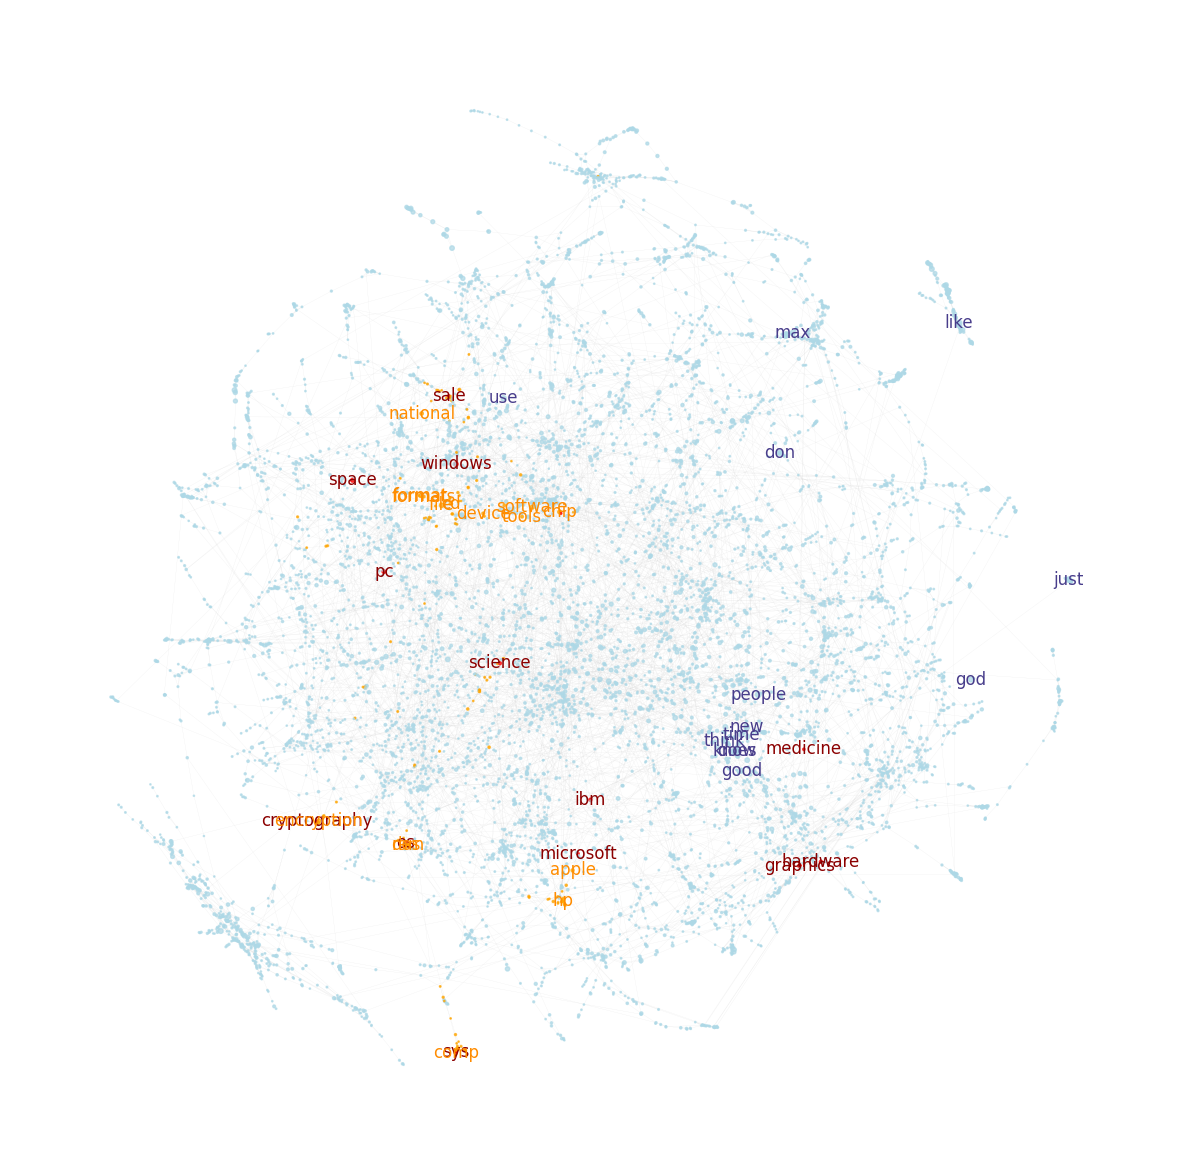

In [46]:
# visualise semantic network
lgde_100d.construct_nx_graph()
fig = lgde_100d.plot_semantic_network(n_top=15,doc_freq=list(doc_freq),lcc_only=True,node_size_factor=0.2,alpha=0.7,edge_width=0.1,plot_with_other_words=True)
fig.savefig("figures/newsgroups_semantic_network_100d.pdf",dpi=fig.dpi,bbox_inches="tight")

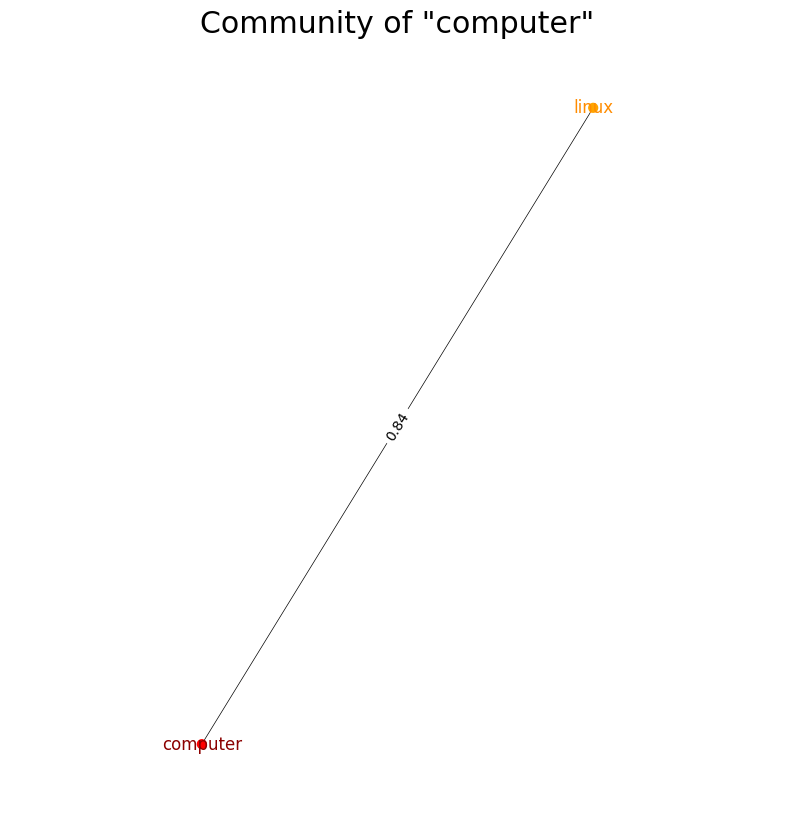

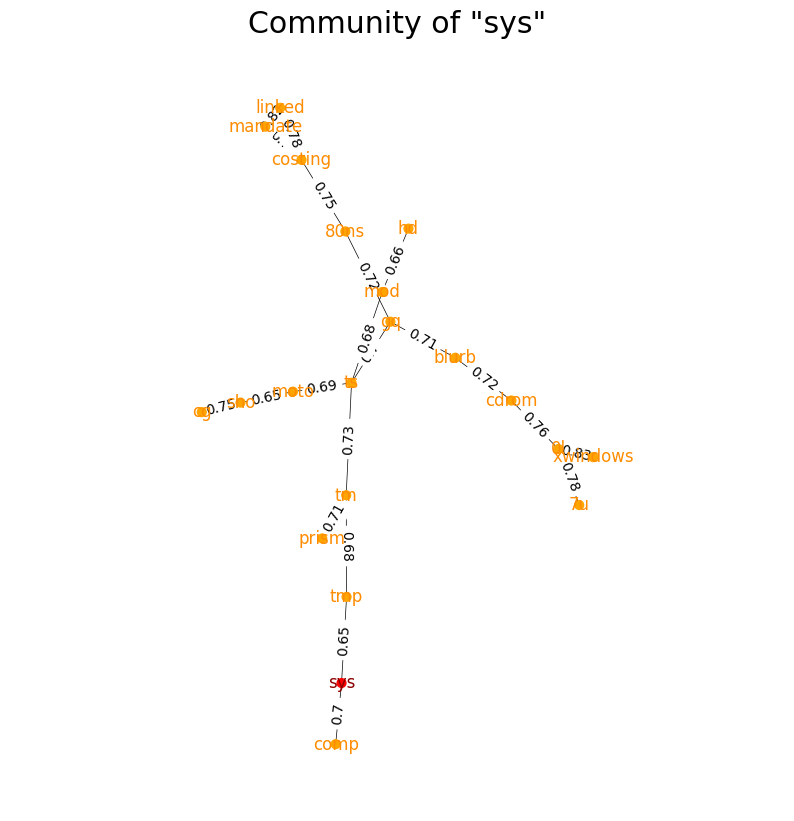

The keyword 'graphics' is a singleton semantic community.


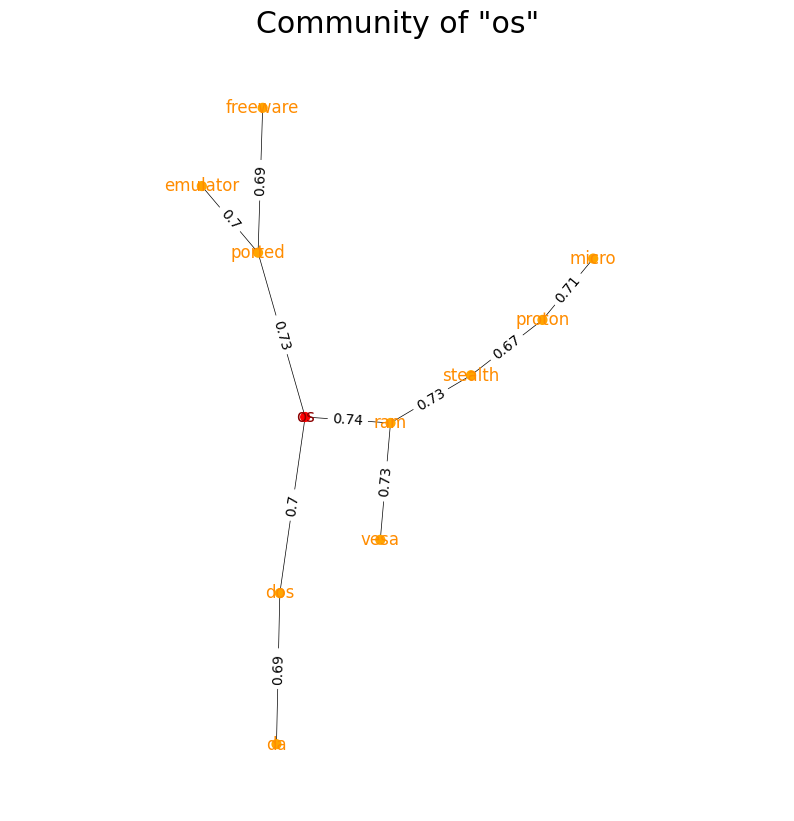

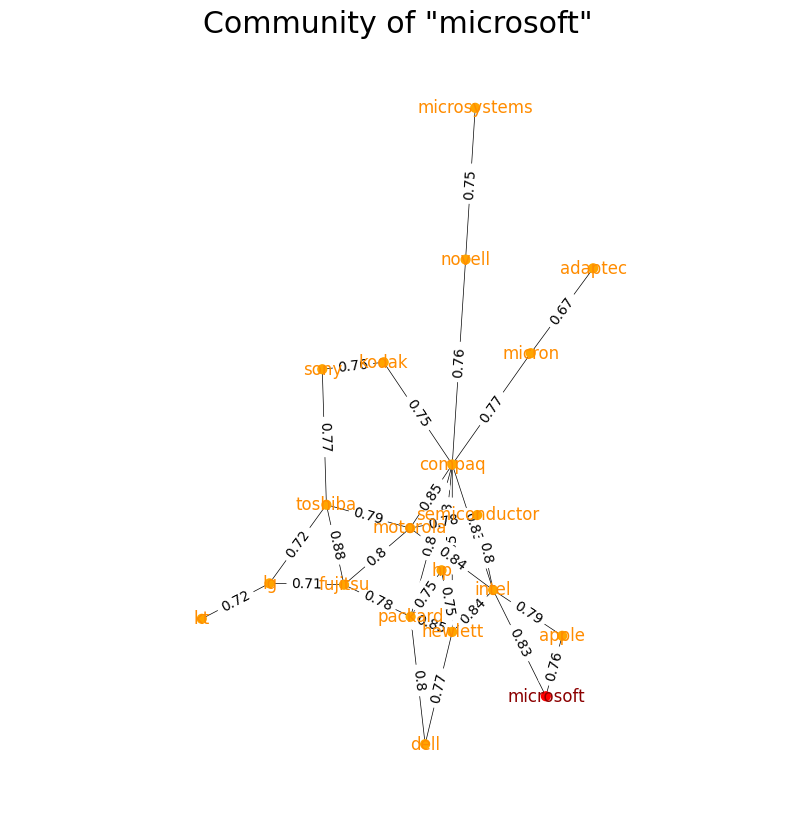

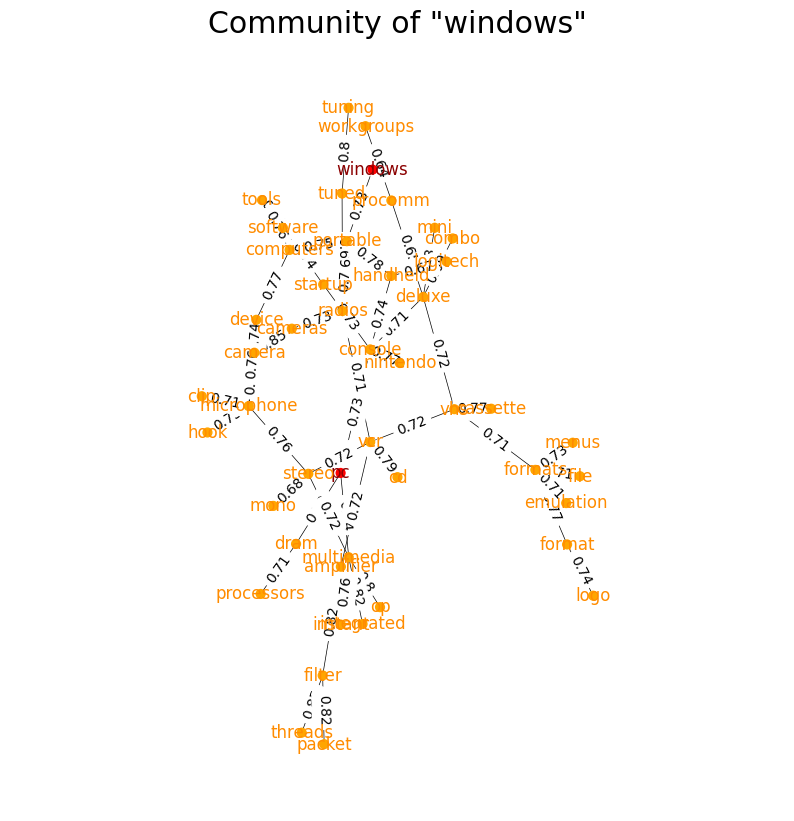

The keyword 'pc' is a singleton semantic community.
The keyword 'ibm' is a singleton semantic community.
The keyword 'hardware' is a singleton semantic community.
The keyword 'mac' is a singleton semantic community.


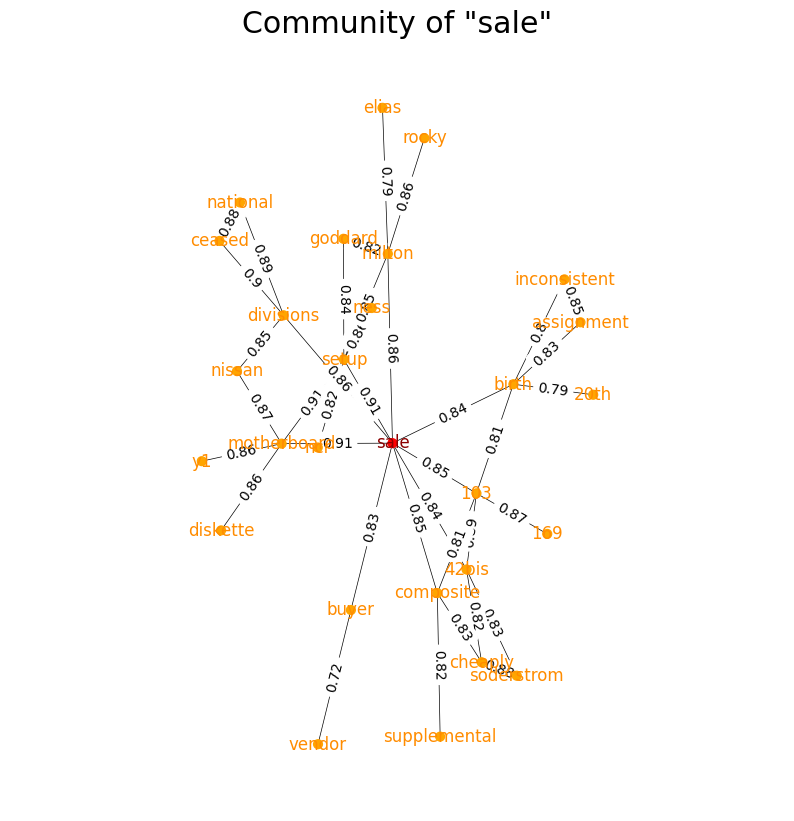

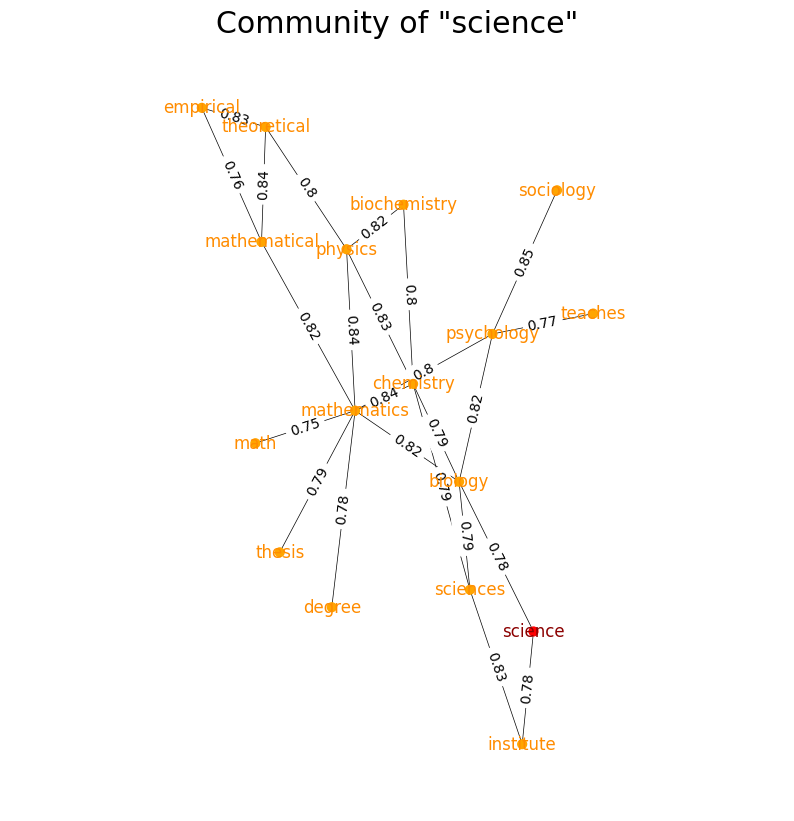

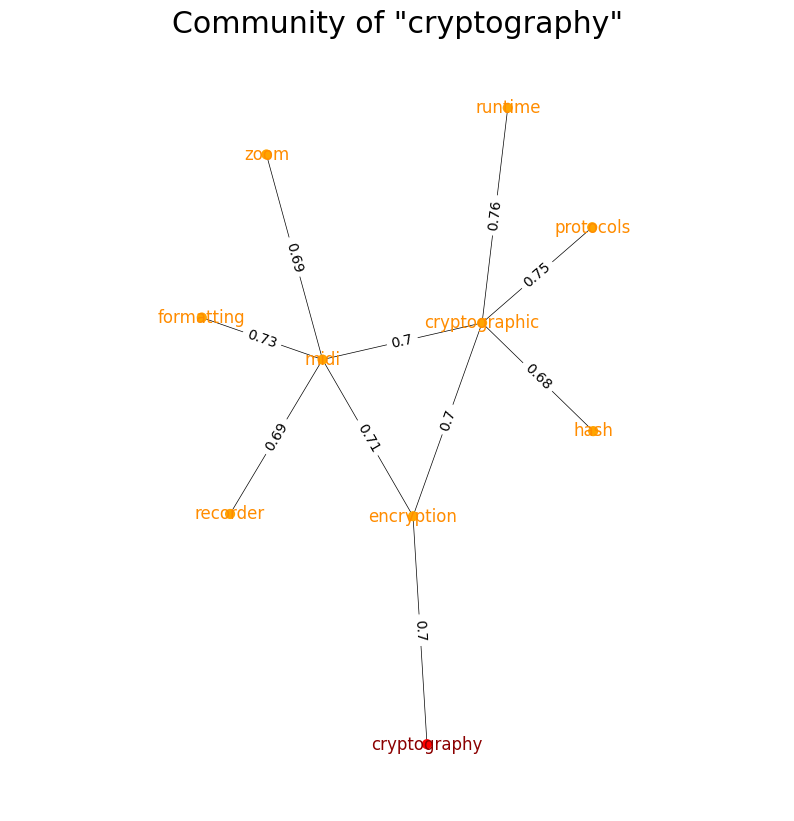

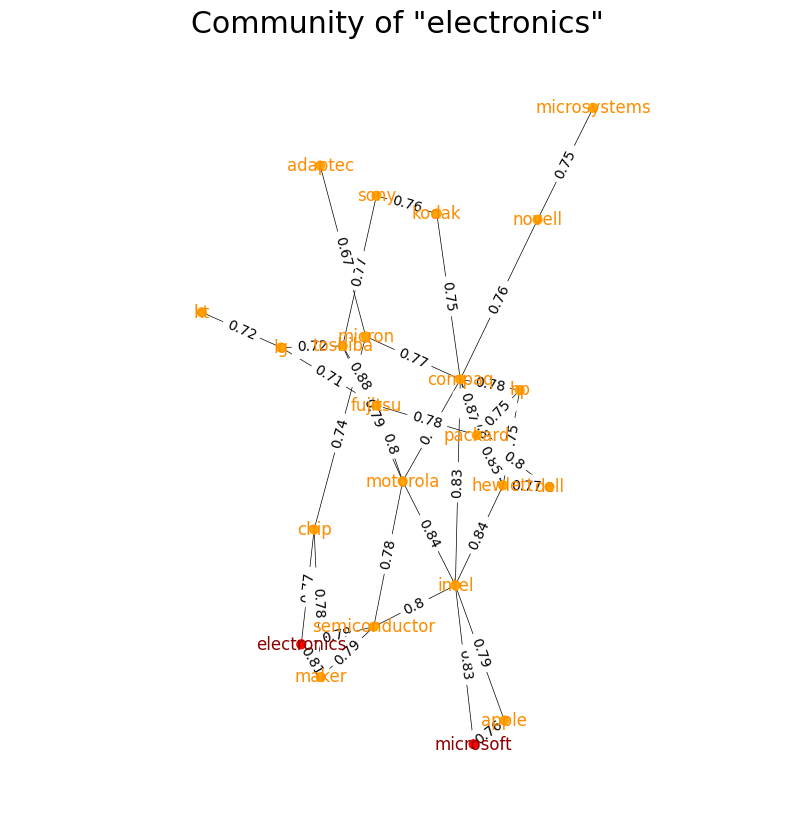

The keyword 'medicine' is a singleton semantic community.
The keyword 'space' is a singleton semantic community.


In [47]:
# plot semantic communities
lgde_100d.plot_semantic_communities(figsize=(10,10),path="figures/100d-")

### 6.5) Significance tests

In [48]:
# get thresholding of same size as LGDE
eps_samesize = eps[np.argmin(size_th>len(lgde_100d.discovered_dict_))]
thres_100d_prime = Thresholding(seed_dict,word_list,word_vecs_100d)
thres_100d_prime.expand(eps_samesize)

# evaluate thresholding on test data
print("\nTest scores for same size thresholding expanded dictionary at $r=100$:\n")
_,_,_ = evaluate_prediction(thres_100d_prime.expanded_dict_, y_test, dt_test)

# determine which words are only found by LGDE or thresholding
lgde_only_100 =  list(set(lgde_100d.discovered_dict_) -  set(thres_100d_prime.discovered_dict_))
thres_only_100_prime = list(set(thres_100d_prime.discovered_dict_) - set(lgde_100d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE")

print("\nMedian LR+ Thresholding:", round(np.median(likelihood_ratio_positive[thres_only_100_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_100]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_100],likelihood_ratio_positive[thres_only_100_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del thres_100d_prime
del thres_only_100_prime


Test scores for same size thresholding expanded dictionary at $r=100$:

              precision    recall  f1-score   support

       False      0.565     0.565     0.565      3608
        True      0.600     0.601     0.601      3924

    accuracy                          0.584      7532
   macro avg      0.583     0.583     0.583      7532
weighted avg      0.584     0.584     0.584      7532


COMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE

Median LR+ Thresholding: 1.47
Median LR+ LGDE: 4.98
Mann-Whitney U test with alternative "greater": p = 0.0


In [49]:
#######
# kNN #
#######

# get kNN of same size as LGDE
ks_knn_samesize = ks_knn[np.argmin(np.abs(size_knn - len(lgde_100d.discovered_dict_)))]
knn_100d_prime = KNearestNeighbors(seed_dict,word_list,word_vecs_100d)
knn_100d_prime.expand(ks_knn_samesize)

# determine which words are only found by LGDE or kNN
lgde_only_100 =  list(set(lgde_100d.discovered_dict_) -  set(knn_100d_prime.discovered_dict_))
knn_only_100d_prime = list(set(knn_100d_prime.discovered_dict_) - set(lgde_100d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST kNN OF SAME SIZE")

print("\nMedian LR+ kNN:", round(np.median(likelihood_ratio_positive[knn_only_100d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_100]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_100],likelihood_ratio_positive[knn_only_100d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del knn_100d_prime



COMPARISON BETWEEN BEST LGDE AND BEST kNN OF SAME SIZE

Median LR+ kNN: 2.57
Median LR+ LGDE: 3.98
Mann-Whitney U test with alternative "greater": p = 0.09434


In [50]:
############
# TextRank #
############

# get TextRank of same size as LGDE
ind_tr_samesize = np.argmin(np.abs(size_tr[ind_tr[0]] - len(lgde_100d.discovered_dict_)))
tr_100d_prime = discovered_dicts_tr[ind_tr[0]][ind_tr_samesize]

# determine which words are only found by LGDE or TextRank
lgde_only_100 =  list(set(lgde_100d.discovered_dict_) -  set(tr_100d_prime))
tr_only_100d_prime = list(set(tr_100d_prime) - set(lgde_100d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST TextRank OF SAME SIZE")

print("\nMedian LR+ TextRank:", round(np.median(likelihood_ratio_positive[tr_only_100d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_100]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_100],likelihood_ratio_positive[tr_only_100d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,7))


COMPARISON BETWEEN BEST LGDE AND BEST TextRank OF SAME SIZE

Median LR+ TextRank: 1.17
Median LR+ LGDE: 4.6
Mann-Whitney U test with alternative "greater": p = 0.0


In [51]:
# free up memory
del lgde_100d

## 7) Detailed comparison for dimension $r=300$

In [52]:
##############
# GS results #
##############

# unpack results for thresholding
eps = results_300d["th"]["eps"]
fscore_th = results_300d["th"]["fscore"]
precision_th = results_300d["th"]["precision"]
recall_th = results_300d["th"]["recall"]
size_th = results_300d["th"]["size"]

# unpack results for kNN
ks_knn = results_300d["knn"]["ks"]
fscore_knn = results_300d["knn"]["fscore"]
precision_knn = results_300d["knn"]["precision"]
recall_knn = results_300d["knn"]["recall"]
size_knn = results_300d["knn"]["size"]

# unpack results_300d for IKEA
eps_ikea = results_300d["ikea"]["eps"]
fscore_ikea = results_300d["ikea"]["fscore"]
precision_ikea = results_300d["ikea"]["precision"]
recall_ikea = results_300d["ikea"]["recall"]
size_ikea = results_300d["ikea"]["size"]

# unpack results_300d for CkNN + LSWL
ks_lswl = results_300d["lswl"]["ks"]
fscore_lswl = results_300d["lswl"]["fscore"]
precision_lswl = results_300d["lswl"]["precision"]
recall_lswl = results_300d["lswl"]["recall"]
size_lswl = results_300d["lswl"]["size"]

# unpack results for LGDE
times = results_300d["lgde"]["times"]
ks = results_300d["lgde"]["ks"]
commmunities = results_300d["lgde"]["communities"]
fscore_lgde = results_300d["lgde"]["fscore"]
precision_lgde = results_300d["lgde"]["precision"]
recall_lgde = results_300d["lgde"]["recall"]
size_lgde = results_300d["lgde"]["size"]

# apply size constraints to thresholding
fscore_sc_th = fscore_th.copy()
fscore_sc_th[min_size > size_th] = np.nan
fscore_sc_th[size_th > max_size] = np.nan

# apply size constraints to kNN
fscore_sc_knn = fscore_knn.copy()
fscore_sc_knn[min_size > size_knn] = np.nan
fscore_sc_knn[size_knn > max_size] = np.nan


# apply size constraints to CkNN + LSWL
fscore_sc_lswl = fscore_lswl.copy()
fscore_sc_lswl[min_size > size_lswl] = np.nan
fscore_sc_lswl[size_lswl > max_size] = np.nan

# apply size constraints to lgde
fscore_sc_lgde = fscore_lgde.copy()
for ind_pair in np.argwhere(size_lgde < min_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.nan
for ind_pair in np.argwhere(size_lgde > max_size):
    fscore_sc_lgde[ind_pair[0],ind_pair[1]] = np.nan

# compute best thresholding hyperparameter
ind_th = np.nanargmax(fscore_sc_th)
best_epsilon_300d = eps[ind_th]

# compute best knn hyperparameter
ind_knn = np.nanargmax(fscore_sc_knn)
best_k_300d_knn = ks_knn[ind_knn]

# compute best lswl hyperparameter
ind_lswl = np.nanargmax(fscore_sc_lswl)
best_k_300d_lswl = ks_lswl[ind_lswl]

# compute best LGDE hyperparamers
ind_lgde = tuple(np.argwhere(fscore_sc_lgde == np.nanmax(fscore_sc_lgde))[0])
best_k_300d = ks[ind_lgde[0]]
best_t_300d = times[ind_lgde[1]]

### 7.1) Thresholding


### Thresholding ###

Best epsilon at $r=50$: 0.673


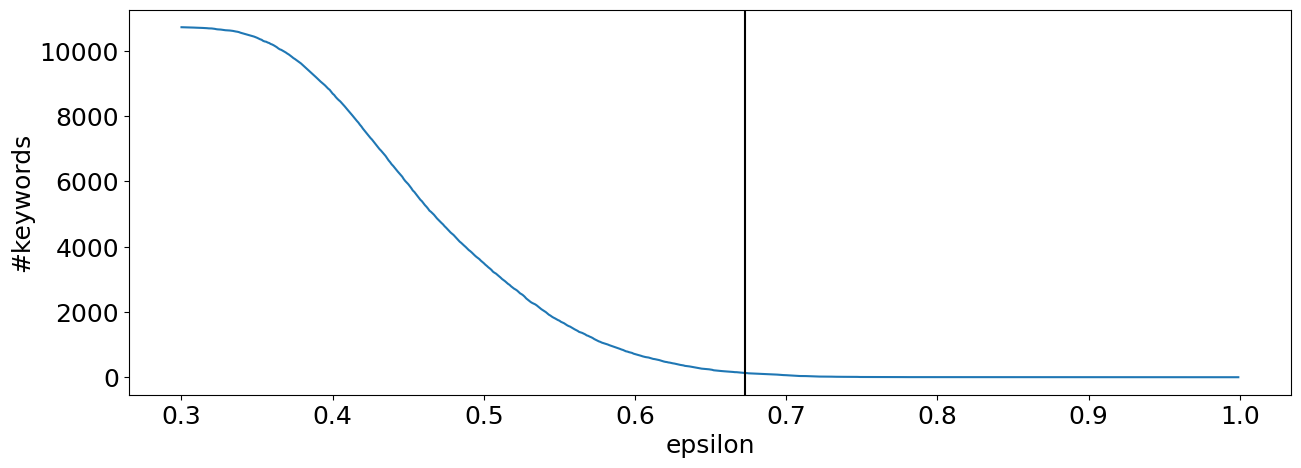

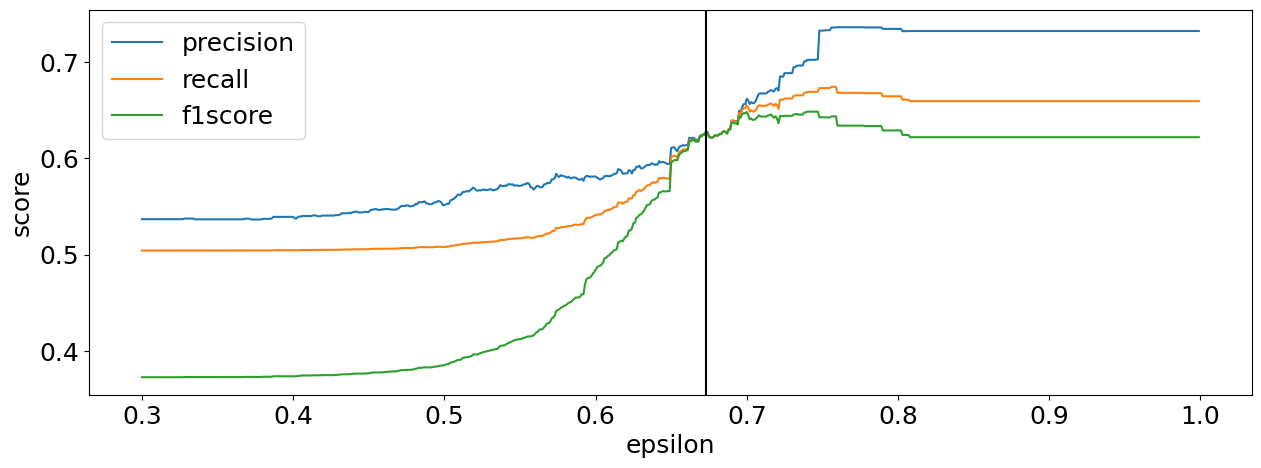

Number of discovered keywords at $r=50$: 128 

Epsilon balls:

computer --> ['case', 'computers', 'various', 'clever', 'calls', 'computer', 'tried', 'software', 'server', 'services', 'linux', 'transportation', 'truecolor', 'classroom', 'specialist', 'marketing', 'outlets', 'housed']
sys --> ['sys']
graphics --> ['orchid', 'graphics', 'post', 'devices', 'excellent', 'golden', 'ms', 'holds', 'hear', 'server', 'week', 'hardware', 'pentium', 'guidance', 'operating', 'text', 'upenn', 'voltage', 'plenty', 'statistic', 'situations', 'transmissions', 'correspondence', 'firing', 'composed', 'clh', 'interfere', 'shopper', 'modems', 'ala', 'eric', 'sport', 'spite', 'dynamic', 'threshold', 'ds', 'sucked', 'excuses', 'configurations', 'focusing', 'jsh', 'continuously', 'bumper', 'wholesale', 'originals', 'accommodate', 'radiosity', 'yu']
os --> ['os']
microsoft --> ['intel', 'software', 'ibm', 'microsoft', 'apple']
windows --> ['window', 'windows']
pc --> ['pc', 'macintosh', 'pcs']
ibm --> ['intel'

In [53]:
################
# Thresholding #
################

print("\n### Thresholding ###\n")

print("Best epsilon at $r=50$:",round(best_epsilon_300d,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,size_th)
ax.axvline(x=best_epsilon_300d, c = 'black')
ax.set(xlabel="epsilon", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(eps,precision_th,label="precision")
ax.plot(eps,recall_th,label="recall")
ax.plot(eps,fscore_th,label="f1score")
ax.axvline(x=best_epsilon_300d, c = 'black')
ax.set(xlabel="epsilon",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal epsilon
thres_300d = Thresholding(seed_dict,word_list,word_vecs_300d)
thres_300d.expand(best_epsilon_300d)

print("Number of discovered keywords at $r=50$:", thres_300d.n_discovered,"\n")

print("Epsilon balls:\n")
for keyword in thres_300d.seed_dict[:15]:
    print(keyword,"-->",thres_300d.epsilon_balls_[keyword])

print("\nDiscovered words:", sorted(thres_300d.discovered_dict_))

print("\nTrain scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(thres_300d.expanded_dict_, y_train, dt_train)

print("\nTest scores for thresholding expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(thres_300d.expanded_dict_, y_test, dt_test)

# free up memory
del thres_300d

### 7.2) kNN


### kNN ###

Best k at $r=300$: 8


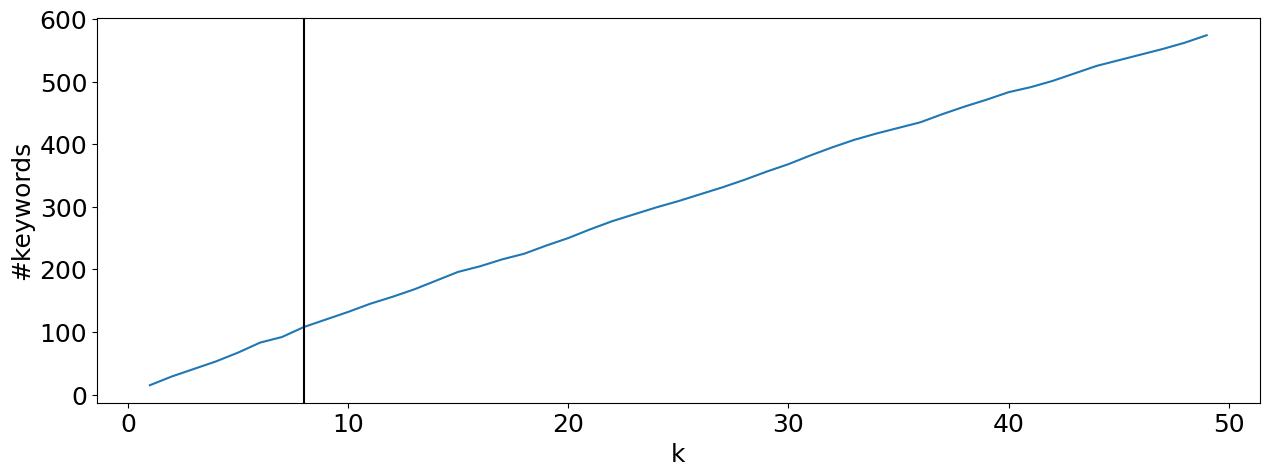

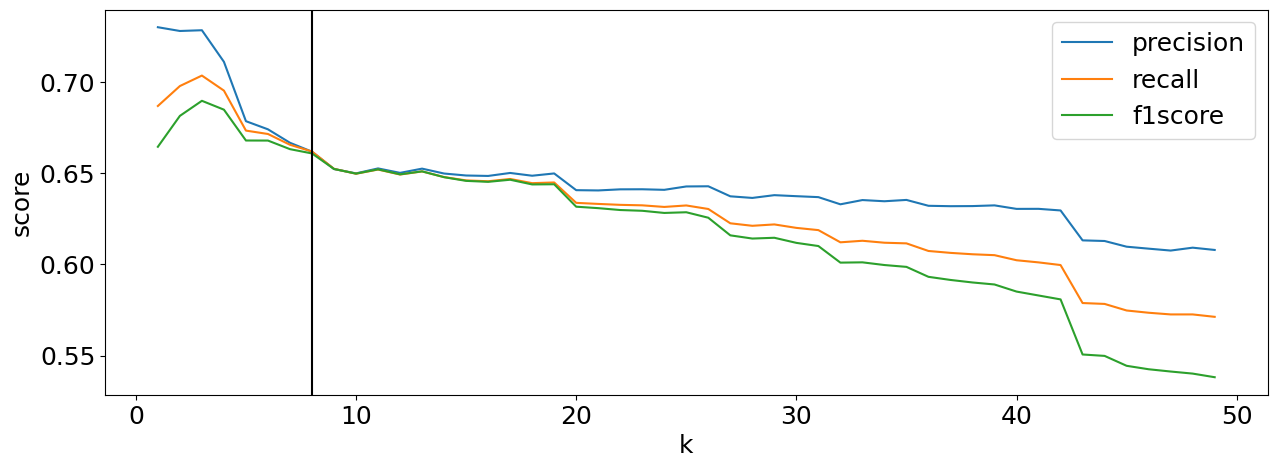

Number of discovered keywords at $r=300$: 108 

k-nearest neighbors:

computer --> ['computer', 'computers', 'various', 'specialist', 'calls', 'truecolor', 'transportation', 'linux', 'tried']
sys --> ['sys', 'comp', 'rll', 'floppies', 'ln', 'ql', 'bbs', 'cos', 'autocad']
graphics --> ['graphics', 'devices', 'orchid', 'bumper', 'ds', 'post', 'composed', 'jsh', 'situations']
os --> ['os', 'macintosh', 'linux', 'ported', 'dos', 'risc', 'unix', 'macs', 'powerpc']
microsoft --> ['microsoft', 'intel', 'software', 'ibm', 'apple', 'windows', 'novell', 'hewlett', 'microsystems']
windows --> ['windows', 'window', 'microsoft', 'macintosh', 'software', 'glass', 'door', 'doors', 'platforms']
pc --> ['pc', 'pcs', 'macintosh', 'software', 'computers', 'computer', 'console', 'ibm', 'multimedia']
ibm --> ['ibm', 'intel', 'hewlett', 'ge', 'xerox', 'compaq', 'dell', 'microsoft', 'packard']
hardware --> ['hardware', 'application', 'modem', 'software', 'graphics', 'offers', 'jsh', 'ds', 'cost']
mac --> ['m

In [54]:
#######
# kNN #
#######

print("\n### kNN ###\n")

print("Best k at $r=300$:",round(best_k_300d_knn,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_knn,size_knn)
ax.axvline(x=best_k_300d_knn, c = 'black')
ax.set(xlabel="k", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_knn,precision_knn,label="precision")
ax.plot(ks_knn,recall_knn,label="recall")
ax.plot(ks_knn,fscore_knn,label="f1score")
ax.axvline(x=best_k_300d_knn, c = 'black')
ax.set(xlabel="k",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal k
knn_300d = KNearestNeighbors(seed_dict,word_list,word_vecs_300d)
knn_300d.expand(best_k_300d_knn)

print("Number of discovered keywords at $r=300$:", knn_300d.n_discovered,"\n")

print("k-nearest neighbors:\n")
for keyword in knn_300d.seed_dict[:15]:
    print(keyword,"-->",knn_300d.neighbors_[keyword])

print("\nDiscovered words:", sorted(knn_300d.discovered_dict_))

print("\nTrain scores for kNN expanded dictionary at $r=50$:\n")
_,_,_ =  evaluate_prediction(knn_300d.expanded_dict_, y_train, dt_train)

print("\nTest scores for kNN expanded dictionary at $r=50$:\n")
_,_,_ = evaluate_prediction(knn_300d.expanded_dict_, y_test, dt_test)

# free up memory
del knn_300d

### 7.3) Other local community detection methods


### LSWL / SIWO ###

Best k at $r=300$: 6


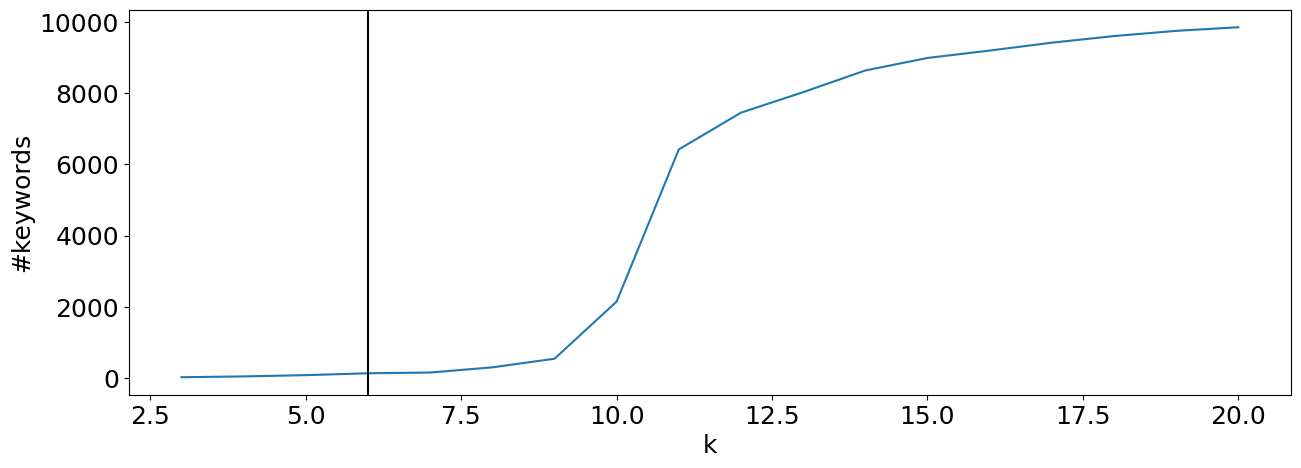

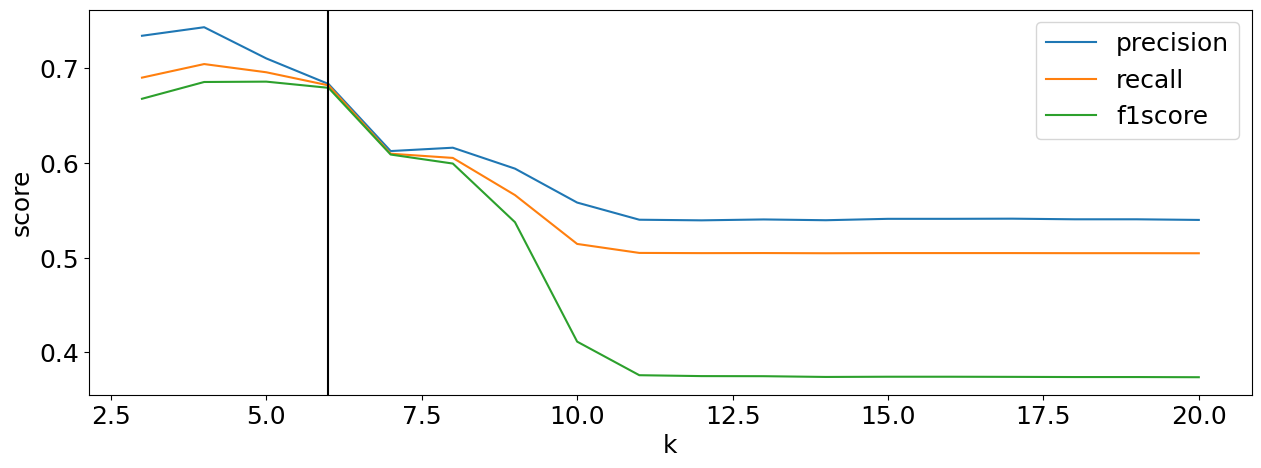

100%|██████████| 16/16 [00:00<00:00, 183.56it/s]

Number of discovered keywords at $r=300$: 138 

Semantic communities:

computer --> ['relief', 'case', 'quoting', 'various', 'questioned', 'calls', 'computer', 'tried', 'comments', 'claims', 'reporter', 'obtain']
sys --> ['sys', 'ql']
graphics --> ['orchid', 'graphics', 'golden', 'composed', 'ala']
os --> ['os', 'powerbook', 'powerpc', 'macintosh', 'macs']
microsoft --> ['intel', 'ibm', 'microsoft', 'compaq', 'hp', 'apple', 'microsystems', 'hewlett', 'packard', 'ge', 'motorola', 'sony', 'toshiba', 'xerox', 'fujitsu', 'dell']
windows --> ['glass', 'window', 'windows', 'door', 'doors', 'entrance']
pc --> ['computers', 'pc', 'servers', 'pcs', 'mainframe']
ibm --> ['intel', 'ibm', 'microsoft', 'compaq', 'hp', 'apple', 'microsystems', 'hewlett', 'packard', 'ge', 'motorola', 'sony', 'toshiba', 'xerox', 'fujitsu', 'dell']
hardware --> ['software', 'hardware', 'application', 'developers', 'programmer', 'programmers']
mac --> ['mac', 'cd', 'collaboration', 'copied']
sale --> ['setup', 'sale', '

In [55]:
########
# LSWL #
########

print("\n### LSWL / SIWO ###\n")

print("Best k at $r=300$:",round(best_k_300d_lswl,3))

# plot size
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_lswl,size_lswl)
ax.axvline(x=best_k_300d_lswl, c = 'black')
ax.set(xlabel="k", ylabel="#keywords")
plt.show()

# plot F1
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(ks_lswl,precision_lswl,label="precision")
ax.plot(ks_lswl,recall_lswl,label="recall")
ax.plot(ks_lswl,fscore_lswl,label="f1score")
ax.axvline(x=best_k_300d_lswl, c = 'black')
ax.set(xlabel="k",ylabel="score")
ax.legend()
plt.show()

# expand with the optimal k
lswl_300d = LGDEWithCDlib(seed_dict,word_list,word_vecs_300d)
lswl_300d.expand(best_k_300d_lswl, method="lswl")

print("Number of discovered keywords at $r=300$:", lswl_300d.n_discovered,"\n")

print("Semantic communities:\n")
for keyword in lswl_300d.seed_dict[:15]:
    print(keyword,"-->",lswl_300d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lswl_300d.discovered_dict_))

print("\nTrain scores for LSWL expanded dictionary at $r=300$:\n")
_,_,_ =  evaluate_prediction(lswl_300d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LSWL expanded dictionary at $r=300$:\n")
_,_,_ = evaluate_prediction(lswl_300d.expanded_dict_, y_test, dt_test)

# free up memory
del lswl_300d

In [56]:
#########
# Mod R #
#########

# unpack dictionary
modr_size = results_localmod_300d["modr"]["size"]
modr_fscore_train = results_localmod_300d["modr"]["fscore_train"]
modr_fscore_test = results_localmod_300d["modr"]["fscore_test"]
modr_ks = results_localmod_300d["modr"]["ks"]

# apply size constraints
modr_fscore_train_sc = []
modr_fscore_test_sc = []

for i in range(len(modr_ks)):
    # comput size constraint indices per k
    sc_ind = (modr_size[i] <= max_size) * (modr_size[i] >= min_size)
    modr_fscore_train_sc.append(modr_fscore_train[i][sc_ind])
    modr_fscore_test_sc.append(modr_fscore_test[i][sc_ind])

# find best k based on mean train F1 scores of admissible dictionaries
modr_fscore_train_sc_mean = np.array([np.array(scores_k).mean() if len(scores_k) > 0 else np.nan for scores_k in modr_fscore_train_sc])
modr_best_k_ind = np.nanargmax(modr_fscore_train_sc_mean) # best k only has 6 admissible dictionaries, we choose second-best below
modr_best_k_ind = np.argsort(-modr_fscore_train_sc_mean)[1]
modr_best_k = modr_ks[modr_best_k_ind]
print("Best k for 'modr':",modr_best_k)
print("Number of admissible dictionaries:", len(modr_fscore_train_sc[modr_best_k_ind]))

# compute 95% CIs for train and test F1 scores
modr_fscore_train_m, modr_fscore_train_l, modr_fscore_train_r = mean_confidence_interval(modr_fscore_train_sc[modr_best_k_ind])
print(f"Average train F1 score for 'modr': {modr_fscore_train_m} ({modr_fscore_train_l}--{modr_fscore_train_r})")
modr_fscore_test_m, modr_fscore_test_l, modr_fscore_test_r = mean_confidence_interval(modr_fscore_test_sc[modr_best_k_ind])
print(f"Average test F1 score for 'modr': {modr_fscore_test_m} ({modr_fscore_test_l}--{modr_fscore_test_r})")

#########
# Mod M #
#########

# unpack dictionary
modm_size = results_localmod_300d["modm"]["size"]
modm_fscore_train = results_localmod_300d["modm"]["fscore_train"]
modm_fscore_test = results_localmod_300d["modm"]["fscore_test"]
modm_ks = results_localmod_300d["modm"]["ks"]

# apply size constraints
modm_fscore_train_sc = []
modm_fscore_test_sc = []

for i in range(len(modm_ks)):
    # comput size constraint indices per k
    sc_ind = (modm_size[i] <= max_size) * (modm_size[i] >= min_size)
    modm_fscore_train_sc.append(modm_fscore_train[i][sc_ind])
    modm_fscore_test_sc.append(modm_fscore_test[i][sc_ind])

# find best k based on mean train F1 scores of admissible dictionaries
modm_fscore_train_sc_mean = np.array([np.array(scores_k).mean() if len(scores_k) > 0 else np.nan for scores_k in modm_fscore_train_sc])
modm_best_k_ind = np.nanargmax(modm_fscore_train_sc_mean)
modm_best_k = modm_ks[modm_best_k_ind]
print("\nBest k for 'modm':",modm_best_k)
print("Number of admissible dictionaries:", len(modm_fscore_train_sc[modm_best_k_ind]))

# compute 95% CIs for train and test F1 scores
modm_fscore_train_m, modm_fscore_train_l, modm_fscore_train_r = mean_confidence_interval(modm_fscore_train_sc[modm_best_k_ind])
print(f"Average train F1 score for 'modm': {modm_fscore_train_m} ({modm_fscore_train_l}--{modm_fscore_train_r})")
modm_fscore_test_m, modm_fscore_test_l, modm_fscore_test_r = mean_confidence_interval(modm_fscore_test_sc[modm_best_k_ind])
print(f"Average test F1 score for 'modm': {modm_fscore_test_m} ({modm_fscore_test_l}--{modm_fscore_test_r})")

Best k for 'modr': 8
Number of admissible dictionaries: 45
Average train F1 score for 'modr': 0.676 (0.672--0.68)
Average test F1 score for 'modr': 0.669 (0.666--0.673)

Best k for 'modm': 5
Number of admissible dictionaries: 40
Average train F1 score for 'modm': 0.679 (0.677--0.682)
Average test F1 score for 'modm': 0.663 (0.661--0.666)


### 7.4) LGDE


### LGDE ###

Best hyperparameters at $r=300$:k=6, t=6


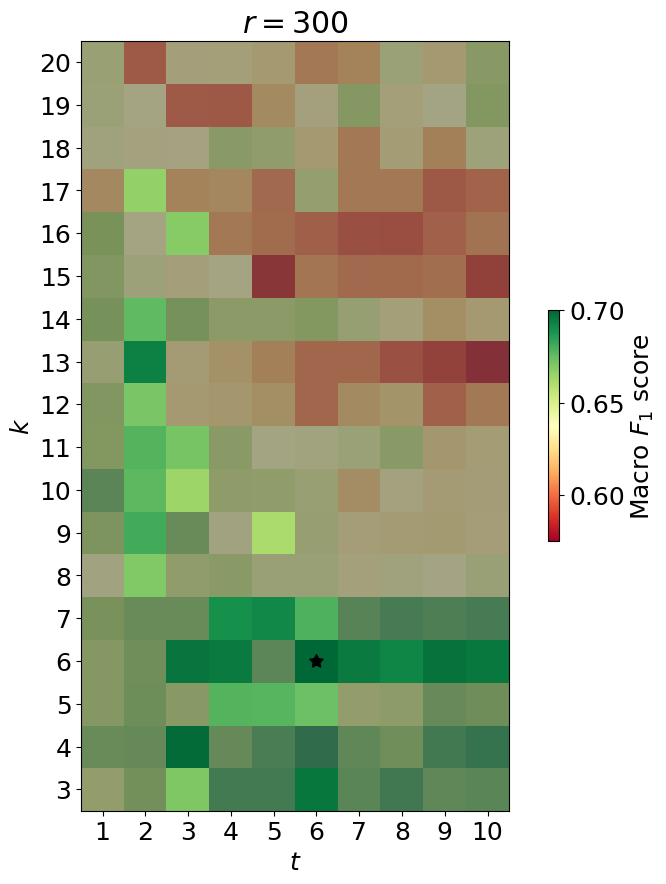

100%|██████████| 16/16 [02:06<00:00,  7.88s/it]


Number of discovered keywords: 137 

Semantic communities:

computer --> ['linux', 'kernel', 'gnu', 'server', 'unix', 'os', 'computer', 'bsd', 'nodes']
sys --> ['sys']
graphics --> ['graphics']
os --> ['os']
microsoft --> ['microsoft', 'apple', 'intel', 'ibm', 'dell', 'hewlett', 'compaq', 'packard', 'hp', 'motorola', 'toshiba', 'microsystems', 'xerox', 'ge', 'fujitsu', 'sony', 'novell']
windows --> ['windows', 'window', 'glass', 'doors', 'door', 'entrance']
pc --> ['pc', 'pcs', 'computers', 'servers', 'software']
ibm --> ['ibm', 'xerox', 'hewlett', 'intel', 'dell', 'compaq', 'packard', 'hp', 'motorola', 'toshiba', 'microsystems', 'ge', 'fujitsu', 'microsoft', 'sony', 'apple', 'novell']
hardware --> ['hardware', 'storing', 'peripherals', 'modem', 'developers', 'application', 'software', 'modems', 'wi', 'rs232', 'panasonic', 'dsl', 'pentium', 'lisp', 'jsh', 'ds']
mac --> ['mac']

Discovered words: ['adapter', 'apple', 'application', 'asteroids', 'astronaut', 'astronauts', 'authenticatio

In [57]:
########
# LGDE #
########

print("\n### LGDE ###\n")
print(f"Best hyperparameters at $r=300$:k={best_k_300d}, t={best_t_300d}")

# plot F1 score
fig, ax = plt.subplots(1, figsize=(10, 10))
im = ax.imshow(np.ones_like(fscore_lgde),cmap='Greys',origin='lower',alpha=0.7, vmin=0,vmax=1)
im = ax.imshow(fscore_lgde,cmap='RdYlGn',origin='lower',alpha=0.5,vmin=0.575,vmax=0.725)
im = ax.imshow(fscore_sc_lgde,cmap='RdYlGn',origin='lower',vmin=0.575,vmax=0.7)
ax.set(xlabel="$t$", ylabel="$k$", xticks=np.arange(len(times)),yticks=np.arange(len(ks)), xticklabels=times, yticklabels=ks)
ax.scatter(ind_lgde[1],ind_lgde[0],color='black',marker=(5, 1),s=100)
plt.colorbar(im,shrink=0.3,label="Macro $F_1$ score")
plt.title('$r=300$')
plt.savefig('figures/lgde_f1score-300d.pdf', bbox_inches='tight')
plt.show()

# expand with the optimal k and t
lgde_300d = LGDE(seed_dict,word_list,word_vecs_300d)
lgde_300d.expand(k=best_k_300d, t=best_t_300d)

print("\nNumber of discovered keywords:", lgde_300d.n_discovered,"\n")
print("Semantic communities:\n")
for keyword in lgde_300d.seed_dict[:10]:
    print(keyword,"-->",lgde_300d.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lgde_300d.discovered_dict_))

print("\nTrain scores for LGDE expanded dictionary at $r=300$:\n")
_,_,_ =  evaluate_prediction(lgde_300d.expanded_dict_, y_train, dt_train)

print("\nTest scores for LGDE expanded dictionary at $r=300$:\n")
_,_,_ = evaluate_prediction(lgde_300d.expanded_dict_, y_test, dt_test)

In [58]:
print("### LGDE 300d ###\n")
_, seed_error_300d = error_analysis(lgde_300d, likelihood_ratio_positive, return_df=True)

### LGDE 300d ###

ERROR ANALYSIS DISCOVERED KWs:


LR         Seed (sim)
biology       0.689684   science (0.705) 
ceased        0.919579      sale (0.679) 
divisions     0.000000       sale (0.73) 
door          0.666362   windows (0.621) 
doors         0.521095   windows (0.599) 
easter        0.073566     space (0.378) 
elias         0.000000      sale (0.501) 
entrance      0.574737   windows (0.558) 
evolutionary  0.204351   science (0.501) 
fairing       0.091958     space (0.342) 
glass         0.613053   windows (0.627) 
jsh           0.000000  hardware (0.701) 
milton        0.344842      sale (0.702) 
national      0.640771      sale (0.721) 
nissan        0.197053      sale (0.714) 
rocky         0.153263      sale (0.605) 
starters      0.137937      sale (0.696)

ERROR ANALYSIS SEED KWs:


Seed LR  # community  LR <= 1 (in %)      Min LR   Median LR  \
computer        8.845476            9            0.00    6.874950   20.887585   
sys            63.450967            1            0.00   63.450967   63.450967   
graphics      122.763828            1            0.00  122.763828  122.763828   
os             55.174754            1            0.00   55.174754   55.174754   
microsoft      21.610112           17            0.00    2.145685    8.276213   
windows        21.112007            6           66.67    0.521095    0.639707   
pc             33.309203            5            0.00    5.729686   25.978113   
ibm             7.147639           17            0.00    2.145685    8.276213   
hardware       26.463447           16            9.09    0.000000   14.253478   
mac            16.224005            1            0.00   16.224005   16.224005   
sale            5.562333           23           42.11    0.000000    1.992422   
science         1.609264           16           12.50    0.204351    1.708938   
cryptography   28.506956           15            0.00    2.023074   13.180636   
electronics     8.933055           11            0.00    1.287411   11.179456   
medicine        2.260632            1            0.00    2.260632    2.260632   
space           6.400271           33            8.33    0.073566    9.042529   

                 Mean LR      Max LR  # Inf LR  
computer       22.176247   55.174754         2  
sys            63.450967   63.450967         0  
graphics      122.763828  122.763828         0  
os             55.174754   55.174754         0  
microsoft      10.299885   25.748219         3  
windows         4.845336   21.112007         0  
pc             22.748779   33.309203         1  
ibm            10.299885   25.748219         3  
hardware       28.584517  125.062776         5  
mac            16.224005   16.224005         0  
sale            5.785968   55.174754         4  
science         2.557184    8.276213         0  
cryptography   40.743491  154.489311        10  
electronics    11.358740   20.018533         3  
medicine        2.260632    2.260632         0  
space          13.605125   45.059382         9

In [59]:
# compute Pearson correlations between semantic community stats
corr_p = seed_error_300d.corr()
corr_p.style.background_gradient(cmap='coolwarm')

R2: 0.249


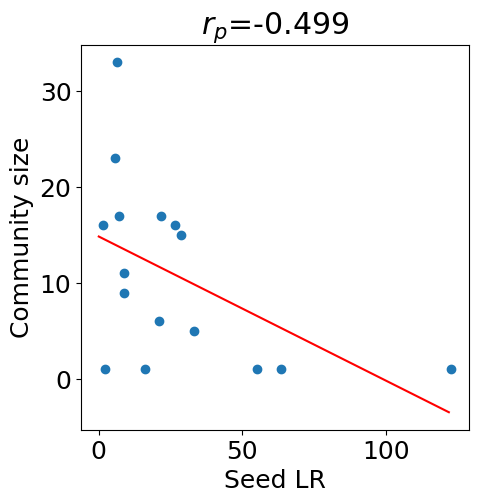

R2: 0.94


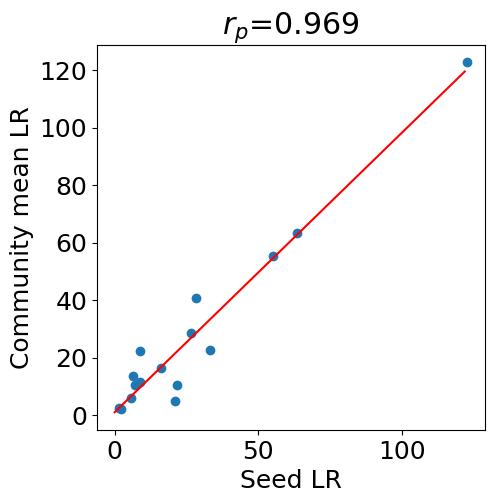

In [60]:
# plot correltaion between seed LR and community size
X = np.array(seed_error_300d["Seed LR"])
y = seed_error_300d["# community"]

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(X,y)
# plot linear regression line
reg = LinearRegression().fit(X.reshape(-1,1), y)
print("R2:", round(reg.score(X.reshape(-1,1), y),3))
ax.plot(reg.predict(np.arange(0,max(X)).reshape(-1,1)), color="red")

ax.set(xlabel="Seed LR", ylabel = "Community size", title=f"$r_p$={round(corr_p['Seed LR']['# community'],3)}")
plt.savefig('figures/lgde_corr_seed_size-300d.pdf', bbox_inches='tight')
plt.show()

# plot correlation between seed LR and mean community LR
X = np.array(seed_error_300d["Seed LR"])
y = seed_error_300d["Mean LR"]
X = X[~ np.isnan(y)]
y = y[~ np.isnan(y)]

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(X,y)
# plot linear regression line
reg = LinearRegression().fit(X.reshape(-1,1), y)
print("R2:", round(reg.score(X.reshape(-1,1), y),3))
ax.plot(reg.predict(np.arange(0,max(X)).reshape(-1,1)), color="red")

ax.set(xlabel="Seed LR", ylabel = "Community mean LR", title=f"$r_p$={round(corr_p['Seed LR']['Mean LR'],3)}")
plt.savefig('figures/lgde_corr_seed_lr-300d.pdf', bbox_inches='tight')
plt.show()

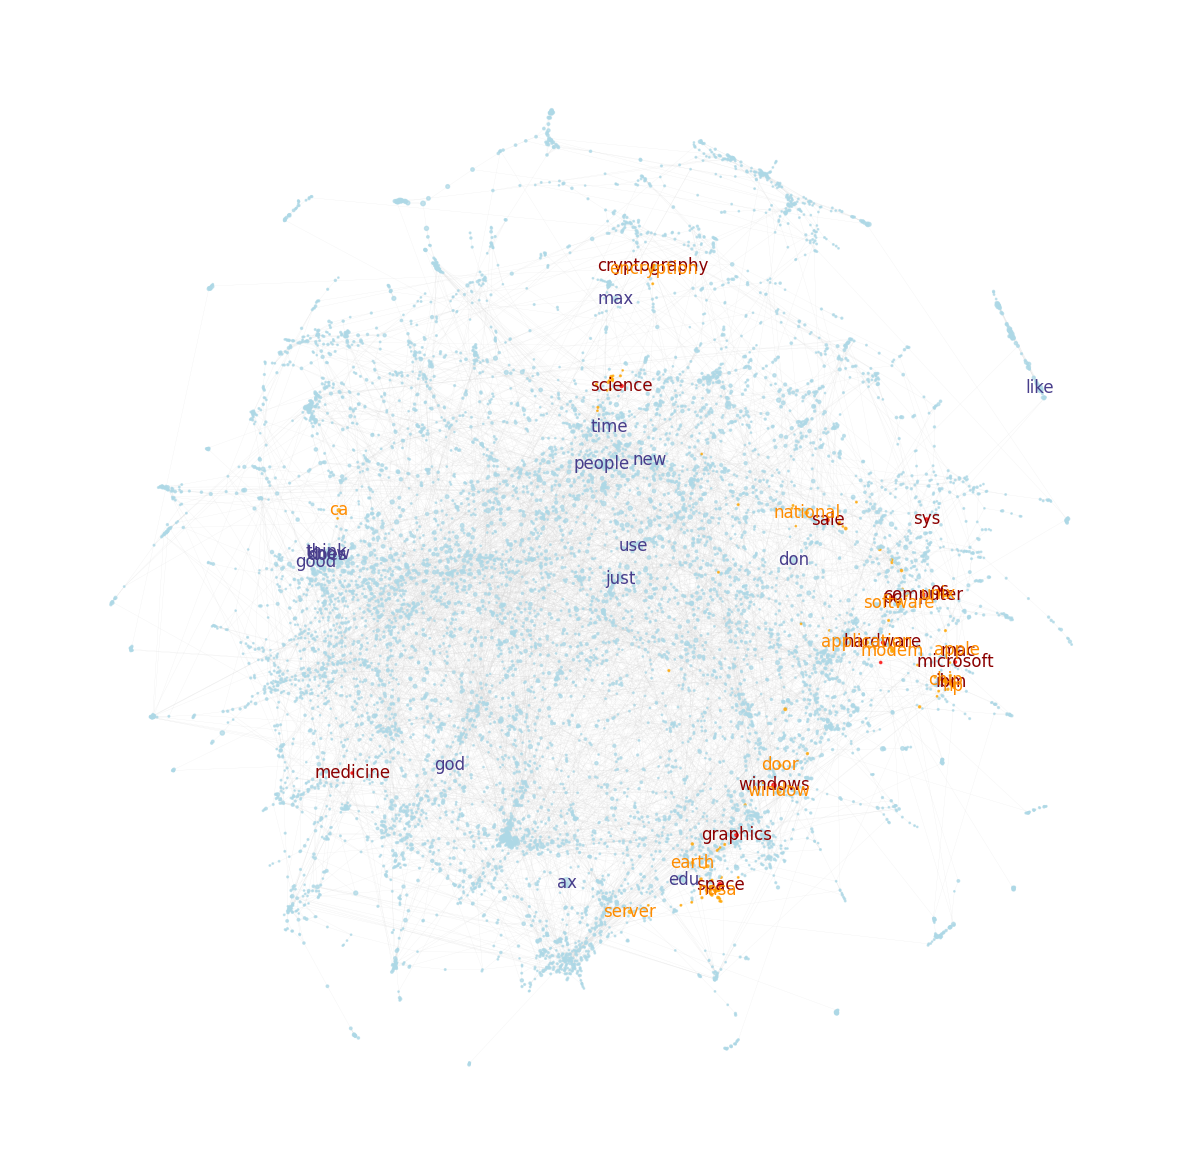

In [61]:
# visualise semantic network
lgde_300d.construct_nx_graph()
fig = lgde_300d.plot_semantic_network(n_top=15,doc_freq=list(doc_freq),lcc_only=True,node_size_factor=0.2,alpha=0.7,edge_width=0.1,plot_with_other_words=True)
fig.savefig("figures/newsgroups_semantic_network_300d.pdf",dpi=fig.dpi,bbox_inches="tight")

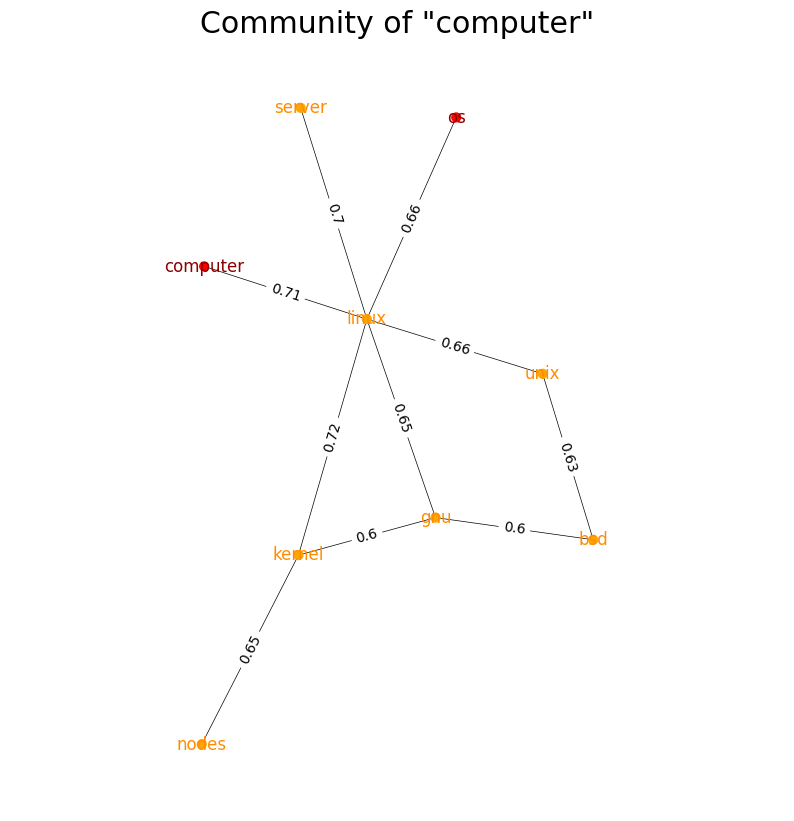

The keyword 'sys' is a singleton semantic community.
The keyword 'graphics' is a singleton semantic community.
The keyword 'os' is a singleton semantic community.


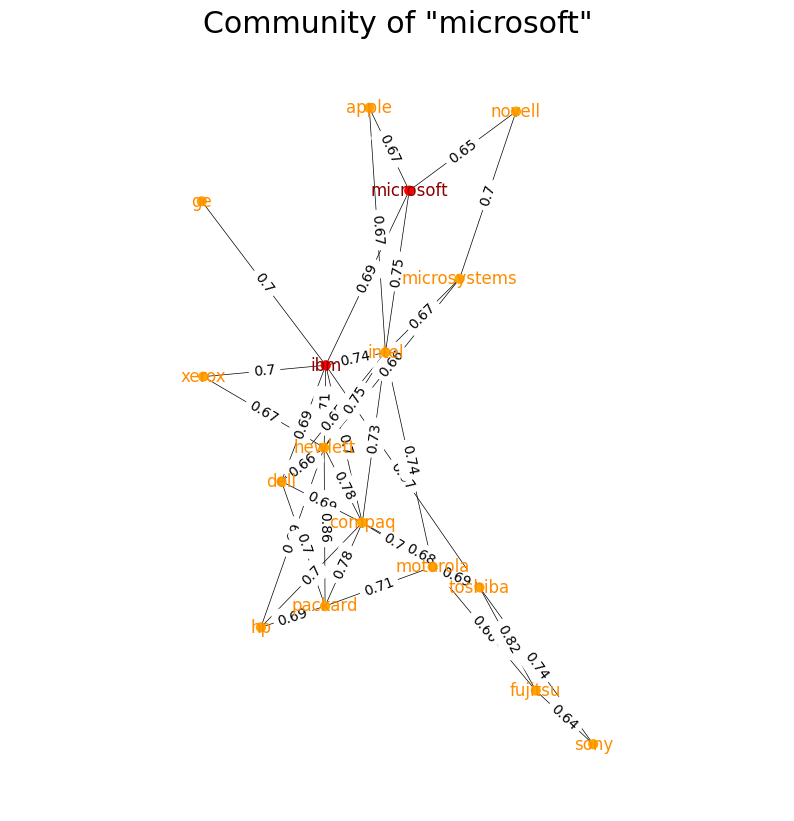

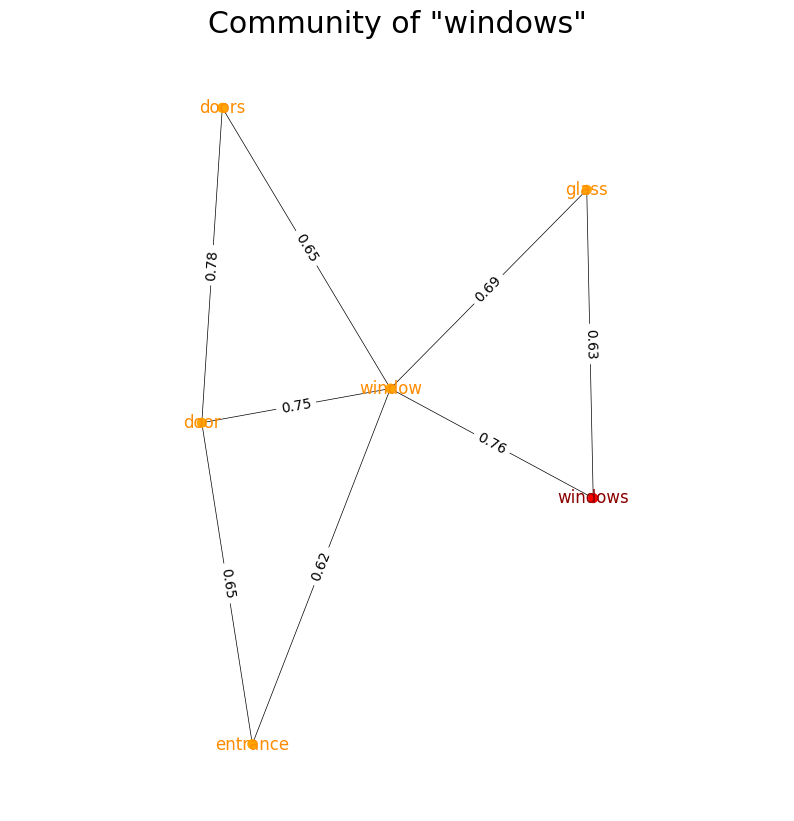

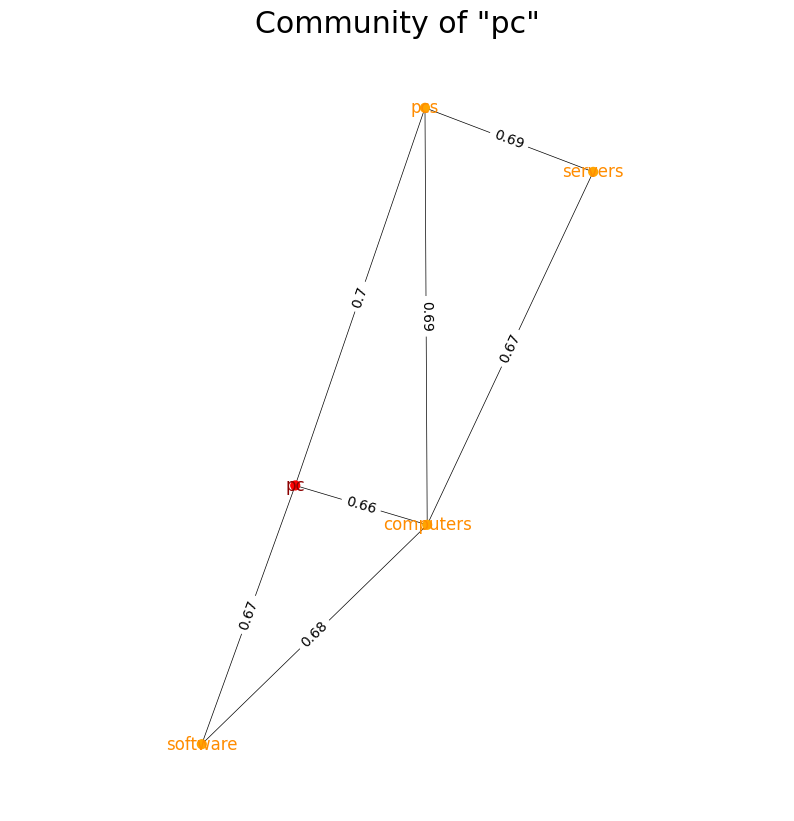

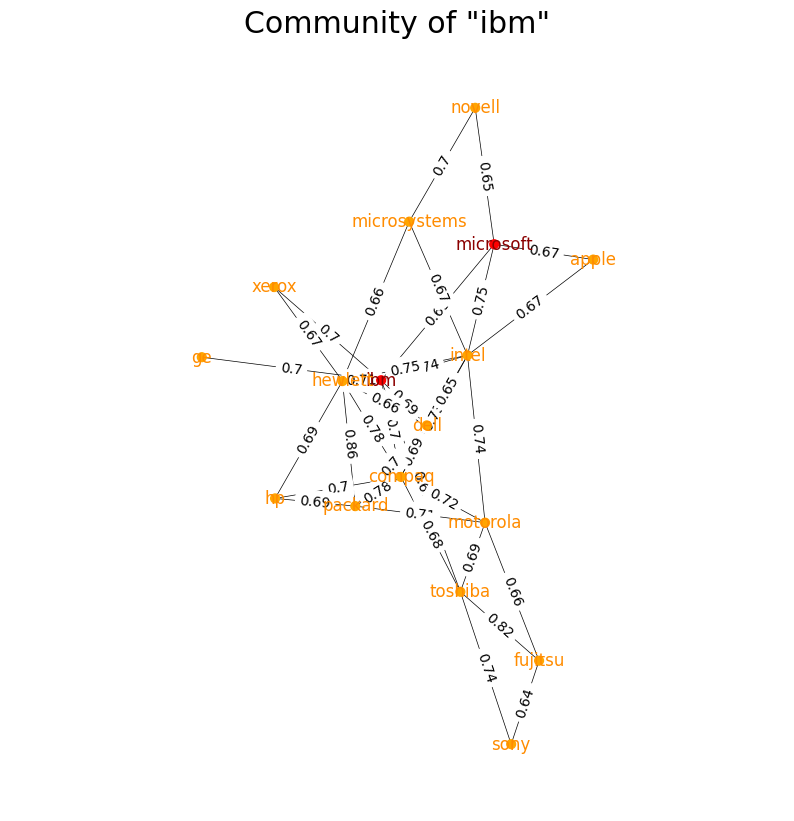

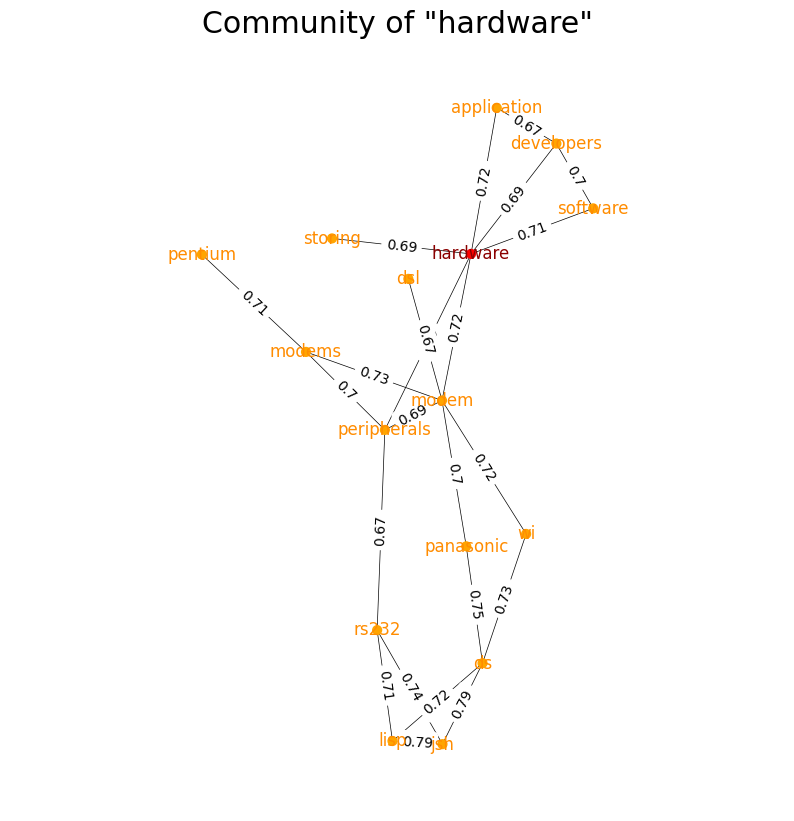

The keyword 'mac' is a singleton semantic community.


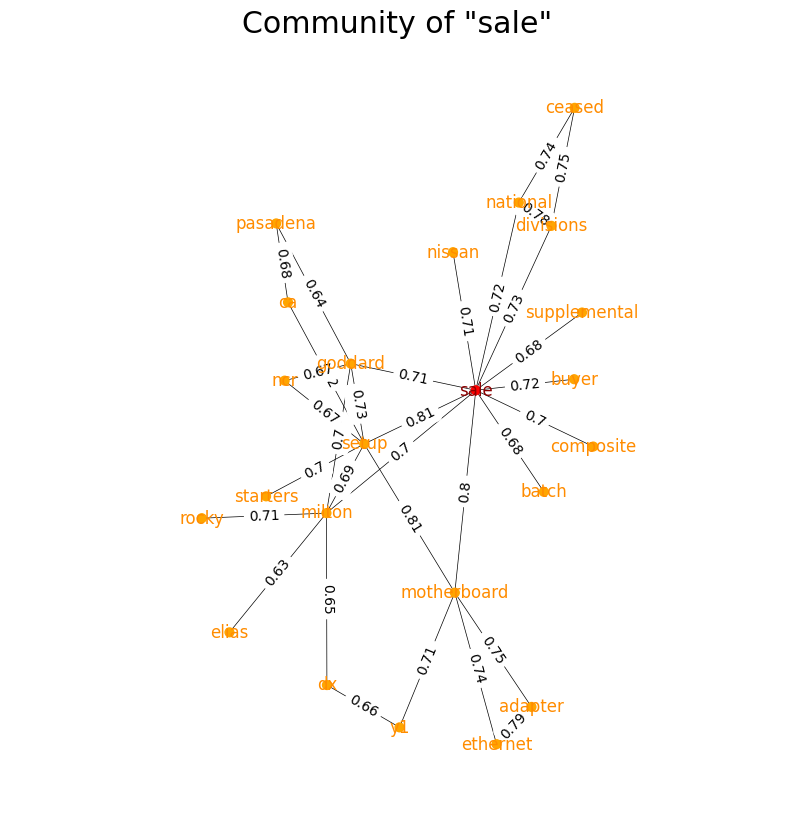

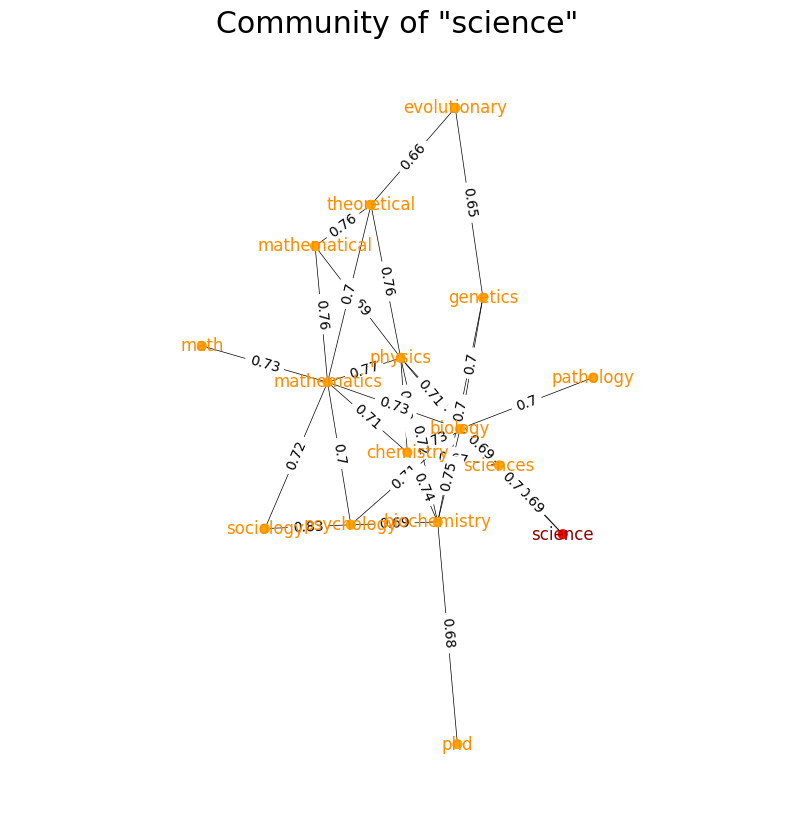

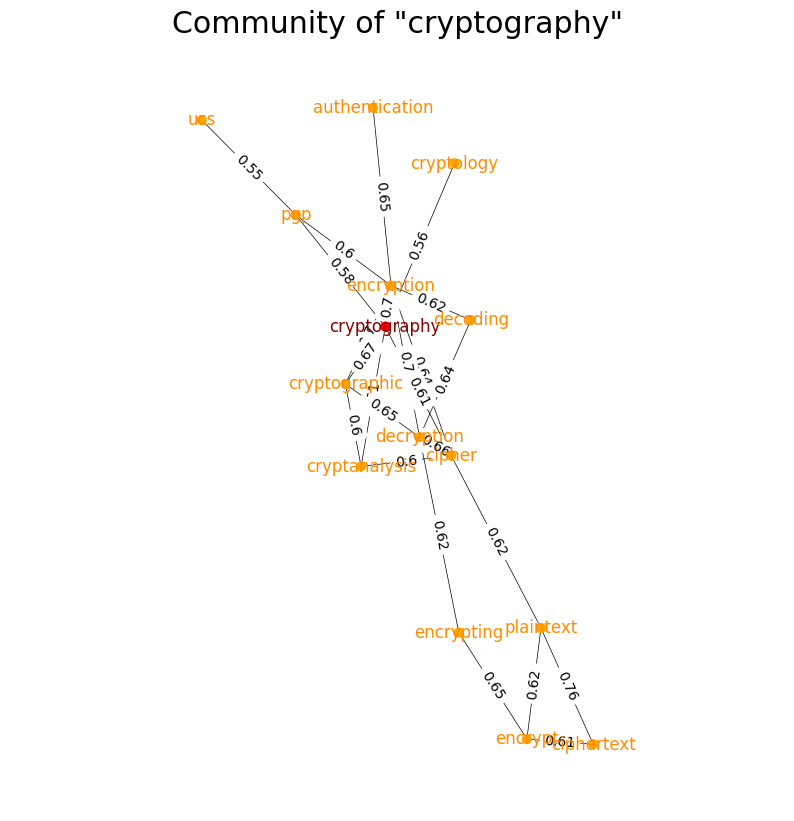

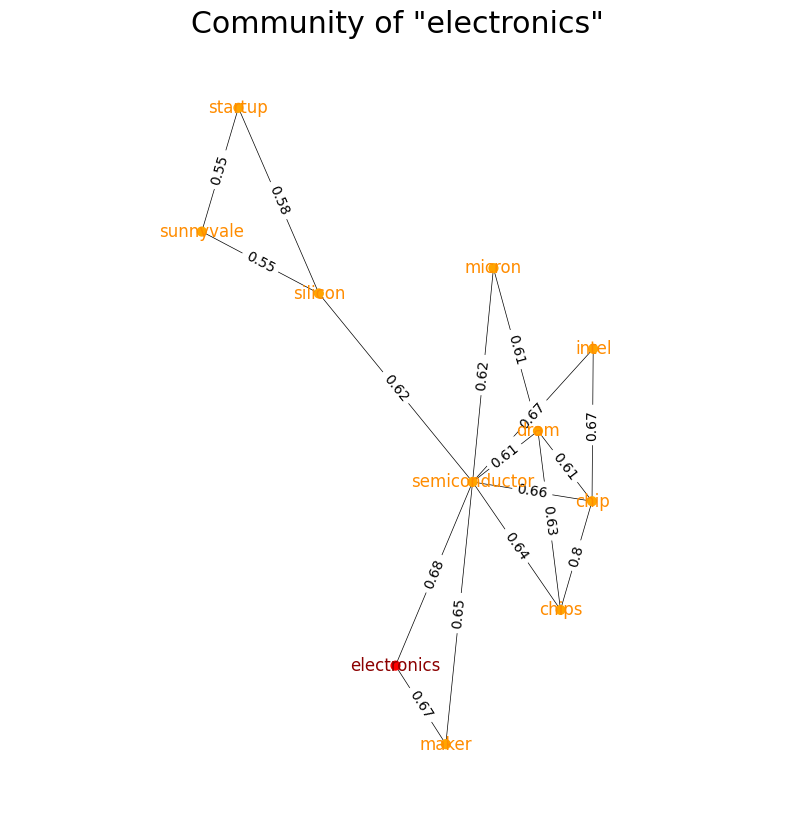

The keyword 'medicine' is a singleton semantic community.


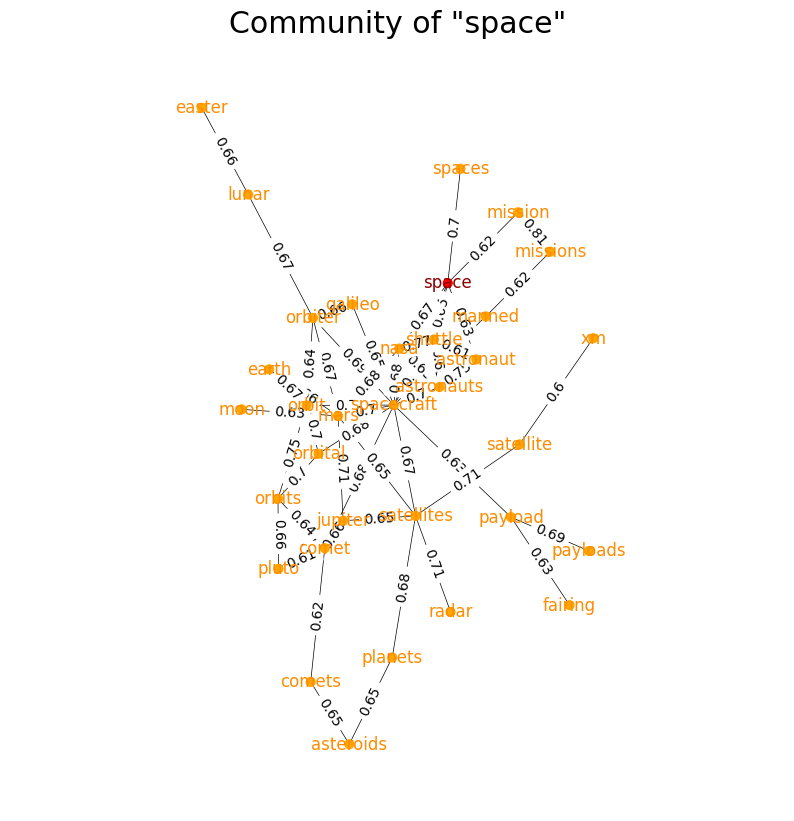

In [62]:
# plot semantic communities
lgde_300d.plot_semantic_communities(figsize=(10,10),path="figures/300d-")

### 7.5) Significance tests

In [63]:
# get thresholding of same size as LGDE
eps_samesize = eps[np.argmin(size_th>len(lgde_300d.discovered_dict_))]
thres_300d_prime = Thresholding(seed_dict,word_list,word_vecs_300d)
thres_300d_prime.expand(eps_samesize)

# evaluate thresholding on test data
print("\nTest scores for same size thresholding expanded dictionary at $r=300$:\n")
_,_,_ = evaluate_prediction(thres_300d_prime.expanded_dict_, y_test, dt_test)

# determine which words are only found by LGDE or thresholding
lgde_only_300 =  list(set(lgde_300d.discovered_dict_) -  set(thres_300d_prime.discovered_dict_))
thres_only_300_prime = list(set(thres_300d_prime.discovered_dict_) - set(lgde_300d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE")

print("\nMedian LR+ Thresholding:", round(np.median(likelihood_ratio_positive[thres_only_300_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_300]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_300],likelihood_ratio_positive[thres_only_300_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del thres_300d_prime
del thres_only_300_prime


Test scores for same size thresholding expanded dictionary at $r=300$:

              precision    recall  f1-score   support

       False      0.603     0.579     0.591      3608
        True      0.627     0.649     0.638      3924

    accuracy                          0.616      7532
   macro avg      0.615     0.614     0.614      7532
weighted avg      0.615     0.616     0.615      7532


COMPARISON BETWEEN BEST LGDE AND BEST THRESHOLDING OF SAME SIZE

Median LR+ Thresholding: 1.33
Median LR+ LGDE: 11.95
Mann-Whitney U test with alternative "greater": p = 0.0


In [64]:
#######
# kNN #
#######

# get kNN of same size as LGDE
ks_knn_samesize = ks_knn[np.argmin(np.abs(size_knn - len(lgde_300d.discovered_dict_)))]
knn_300d_prime = KNearestNeighbors(seed_dict,word_list,word_vecs_300d)
knn_300d_prime.expand(ks_knn_samesize)

# determine which words are only found by LGDE or kNN
lgde_only_300 =  list(set(lgde_300d.discovered_dict_) -  set(knn_300d_prime.discovered_dict_))
knn_only_300d_prime = list(set(knn_300d_prime.discovered_dict_) - set(lgde_300d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST kNN OF SAME SIZE")

print("\nMedian LR+ kNN:", round(np.median(likelihood_ratio_positive[knn_only_300d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_300]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_300],likelihood_ratio_positive[knn_only_300d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,5))

# free up memory
del knn_300d_prime


COMPARISON BETWEEN BEST LGDE AND BEST kNN OF SAME SIZE

Median LR+ kNN: 2.53
Median LR+ LGDE: 9.2
Mann-Whitney U test with alternative "greater": p = 0.00141


In [65]:
############
# TextRank #
############

# get TextRank of same size as LGDE
ind_tr_samesize = np.argmin(np.abs(size_tr[ind_tr[0]] - len(lgde_300d.discovered_dict_)))
tr_300d_prime = discovered_dicts_tr[ind_tr[0]][ind_tr_samesize]

# determine which words are only found by LGDE or TextRank
lgde_only_300 =  list(set(lgde_300d.discovered_dict_) -  set(tr_300d_prime))
tr_only_300d_prime = list(set(tr_300d_prime) - set(lgde_300d.discovered_dict_))

print("\nCOMPARISON BETWEEN BEST LGDE AND BEST TextRank OF SAME SIZE")

print("\nMedian LR+ TextRank:", round(np.median(likelihood_ratio_positive[tr_only_300d_prime]),2))
print("Median LR+ LGDE:", round(np.median(likelihood_ratio_positive[lgde_only_300]),2))
U, p = mannwhitneyu(likelihood_ratio_positive[lgde_only_300],likelihood_ratio_positive[tr_only_300d_prime],alternative='greater',method='exact')
print('Mann-Whitney U test with alternative "greater": p =', np.around(p,7))


COMPARISON BETWEEN BEST LGDE AND BEST TextRank OF SAME SIZE

Median LR+ TextRank: 1.15
Median LR+ LGDE: 10.12
Mann-Whitney U test with alternative "greater": p = 0.0
